In [1]:
import numpy as np
import scipy
import matplotlib as mplt
from matplotlib import pyplot as plt
import sympy as sp
from sympy import *
from scipy.optimize import fsolve
from scipy.optimize import bisect
from IPython.display import display, Latex
import mpl_toolkits.mplot3d.axes3d as axes3d
import pickle

In [2]:
"CONSTANTS in SI"
G=6.674E-11 # m^3 kg^-1 s^-2
amu=1.67e-27; ## 1 amu in kg
eps0=8.854e-12;  #vacuum permittivity
Ms=568.32E+24 #Saturn's mass in kg
Rs=60268*1e3 # Saturn's radius in m
Gamma=1#drag force factor
rho_m_mass=917 #grain density (ice) in kg/m^3
M=18.01528e-3 #molecular weight of water, kg/mol
NA=6.022e23 #Avogadro's number
rho_m= NA/M *rho_m_mass #number density of water grain m^-3
M_H2=2.016e-3 #molecular weight of H_2, kg/mol
q_e=1.60217663e-19 #electron charge in C
Mom=4.6e+18  # equatorial magnetic momment of Saturn T*m^3
Om=1.707e-4 #angular frequency of Saturn's rotation
R_synch=(G*Ms/Om**2)**(1/3)
print('Radius of synchronous orbit: ', R_synch/Rs ,' Rs')

Radius of synchronous orbit:  1.8116901384810609  Rs


In [95]:
"Time"
dt=1
t=np.arange(0,12000,dt)
print('total simulation time: ', t[-1]/(60*60), ' hrs')
N=len(t)


"Initial position, velocity"
R_dring=1.11*Rs
pos_init = np.array([0, R_dring, 0]) #r_0, θ_0, φ_0

v_kep=np.sqrt(G*Ms/np.linalg.norm(pos_init))
v_cor=Om*R_dring

#pos_der_init = np.array([-v_cor, 0, 1.65*1e3])
print('keplerian velocity: ', v_kep*1e-3, ' km/s')
print('corotation velocity: ', v_cor*1e-3, ' km/s')
1e-3*(R_dring-Rs)

total simulation time:  3.3330555555555557  hrs
keplerian velocity:  23.81138690653465  km/s
corotation velocity:  11.419399836  km/s


6629.480000000008

In [96]:
R_grain0=np.array([1, 10, 100, 10.00001])*1e-9 #ice grain initial radii in m
U0=[1, 2, 3, 4]  # assumed magnitude of grain potential in Volts (change as you wish!)
if np.sign(U0[0])<0:
    data_title='negative_U'
    
    if Gamma==0:
        data_title='mag_only'+data_title
        
elif np.sign(U0[0])>0:
    data_title='positive_U'
    if dt<0.1: data_title=data_title+'_small_dt'
    if Gamma==0:
        data_title='mag_only'+data_title
else:
    data_title='drag_only'
v0=['cor', 'cor', 'cor', 'kep']
#R_NH=(2/3 * G*Ms/(Om-G*Ms/3 * m0* 1/(abs(Q0)*Mom))**2)**(1/3)
m_init=rho_m_mass*4/3* np.pi* R_grain0**3 #inital grain masses in kg
C_init=4*np.pi*eps0*R_grain0 #initial capacitance in C/V, capacitance of sphere is C = 4*pi*eps_0*r (assume rel perm ≈ 1)

for U in U0:
    Q_init=C_init*U # initial grain charge in SI
    print('For U = ', U, ' Volts \n R = ', R_grain0*1e9, ' nm \n', ' Q_0/m_0 = ', Q_init/m_init * (amu/q_e), ' e/amu')

particle={}
for U in U0:
    particle[U]={}
    for i, Rg0 in enumerate(R_grain0):
        C0=4*np.pi*eps0*Rg0
        particle[U][Rg0]={'m0':rho_m_mass*4/3* np.pi* Rg0**3, 'Q0':C0*U, 'Q_0/m_0': C0*U/(rho_m_mass*4/3*np.pi*Rg0**3) * (amu/q_e), 'fate':'moving'}
        if v0[i]=='kep':
            particle[U][Rg0].update({'v0':np.array([-v_kep, 0, 0]), 'v0_txt':'$v_{kep}$'})
        elif v0[i]=='cor':
            particle[U][Rg0].update({'v0':np.array([-v_cor, 0, 0]), 'v0_txt':'$v_{cor}$'})

For U =  1  Volts 
 R =  [  1.       10.      100.       10.00001]  nm 
  Q_0/m_0 =  [3.01923916e-04 3.01923916e-06 3.01923916e-08 3.01923312e-06]  e/amu
For U =  2  Volts 
 R =  [  1.       10.      100.       10.00001]  nm 
  Q_0/m_0 =  [6.03847831e-04 6.03847831e-06 6.03847831e-08 6.03846624e-06]  e/amu
For U =  3  Volts 
 R =  [  1.       10.      100.       10.00001]  nm 
  Q_0/m_0 =  [9.05771747e-04 9.05771747e-06 9.05771747e-08 9.05769935e-06]  e/amu
For U =  4  Volts 
 R =  [  1.       10.      100.       10.00001]  nm 
  Q_0/m_0 =  [1.20769566e-03 1.20769566e-05 1.20769566e-07 1.20769325e-05]  e/amu


In [97]:
from functions_cart import gravity, rho_a, drag, vel_RHS, temp, mass, magnetic

def RK4(dt, pos, pos_der, R_grain, Q, m):

    k1r=vel_RHS(pos, pos_der)
    
    k1v=gravity(pos, pos_der, G, Ms) + \
        drag(pos, pos_der, R_grain, rho_m, Gamma) + \
        magnetic(pos, pos_der, Q, m, Rs, Mom, Om)[0] + \
        magnetic(pos, pos_der, Q, m, Rs, Mom, Om)[1]

    k2r=vel_RHS(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v)
    
    k2v=gravity(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v, G, Ms) + \
        drag(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v, R_grain, rho_m, Gamma) + \
        magnetic(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v, Q, m, Rs, Mom, Om)[0] + \
        magnetic(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v, Q, m, Rs, Mom, Om)[1]

    k3r=vel_RHS(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v)
    
    k3v=gravity(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v, G, Ms) + \
        drag(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v, R_grain, rho_m, Gamma) + \
        magnetic(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v, Q, m, Rs, Mom, Om)[0] + \
        magnetic(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v, Q, m, Rs, Mom, Om)[1]

    k4r=vel_RHS(pos+dt*k3r, pos_der+dt*k3v)
    
    k4v=gravity(pos+dt*k3r, pos_der+dt*k3v, G, Ms) + \
        drag(pos+dt*k3r, pos_der+dt*k3v, R_grain, rho_m, Gamma) + \
        magnetic(pos+dt*k3r, pos_der+dt*k3v, Q, m, Rs, Mom, Om)[0] + \
        magnetic(pos+dt*k3r, pos_der+dt*k3v, Q, m, Rs, Mom, Om)[1]

    pos_new=pos + dt/6 * (k1r+2*k2r+2*k3r+k4r)
    pos_der_new=pos_der + dt/6 * (k1v+2*k2v+2*k3v+k4v)

    return pos_new, pos_der_new

In [98]:
data_title

'mag_onlypositive_U'

In [99]:
%%time
"SOLVER"
for U in U0:
    print('U = ', U, 'Volts')
    for Rg0 in R_grain0:
        print('Rg0 = ', Rg0*1e9, ' nm ', end='')
        pos_init = np.array([0, R_dring, 0]) #r_0, θ_0, φ_0
        pos_der_init = particle[U][Rg0]['v0']
        
        x = []; y = []; z = []
        r = []
        vx=[]; vy=[]; vz=[]; vtot=[];
        state=np.array([[pos_init],[pos_der_init]])
        pos=pos_init; pos_der=pos_der_init
        m0=particle[U][Rg0]['m0']
        Q0=particle[U][Rg0]['Q0']
        a_gr=[]; a_drag=[]; a_mag=[]; a_Ec=[]; gr_mag=[]; drag_mag=[]; mag_mag=[]; Ec_mag=[]
        T=[]; m=[]; R_grain=[]; Q=[]
        m_bef=m0
        pos=pos_init; pos_der=pos_der_init
        
        for i in range(1,N):  
            x.append(pos[0]); y.append(pos[1]); z.append(pos[2])
            r.append(np.sqrt(x[i-1]**2+y[i-1]**2+z[i-1]**2))
            vx.append(pos_der[0]); vy.append(pos_der[1]); vz.append(pos_der[2])
            vtot.append(np.sqrt(vx[i-1]**2+vy[i-1]**2+vz[i-1]**2)*1e-3)
            
            T_sol=temp(pos, pos_der, vtot[i-1]*1e3)
            T.append(T_sol[0])
            
            if i==1 or Gamma==0:
                m.append(m0)
            else:
                m.append(mass(T[i-1], m_bef, t[i], dt, rho_m_mass))
            m_bef=m[i-1]
            
            R_grain.append((3/(4*np.pi) *m[i-1]/rho_m_mass)**(1/3))
            Q.append(4*np.pi*eps0*R_grain[i-1]*U)      
            
            a_gr.append(gravity(pos, pos_der, G, Ms)*1e-3); gr_mag.append(np.linalg.norm(a_gr[i-1]))
            a_drag.append(drag(pos, pos_der, R_grain[i-1], rho_m, Gamma)*1e-3); drag_mag.append(np.linalg.norm(a_drag[i-1]))
            a_Ec.append(magnetic(pos, pos_der, Q[i-1], m[i-1], Rs, Mom, Om)[0]*1e-3); Ec_mag.append(np.linalg.norm(a_Ec[i-1]))
            a_mag.append(magnetic(pos, pos_der, Q[i-1], m[i-1], Rs, Mom, Om)[1]*1e-3); mag_mag.append(np.linalg.norm(a_mag[i-1]))
            
            if (r[i-1]/Rs-1)<=0.0001:
                particle[U][Rg0]['fate']='fell'
                m.pop(); T.pop(); Q.pop()
                x.pop(); y.pop(); z.pop(); r.pop()
                vx.pop(); vy.pop(); vz.pop(); vtot.pop()
                a_gr.pop(); a_drag.pop(); a_Ec.pop(); a_mag.pop()
                gr_mag.pop(); drag_mag.pop(); Ec_mag.pop(); mag_mag.pop()
                break
                
            if m[i-1]/m0<=0.0001:
                particle[U][Rg0]['fate']='sublimated'
                m.pop(); T.pop(); Q.pop()
                x.pop(); y.pop(); z.pop(); r.pop()
                vx.pop(); vy.pop(); vz.pop(); vtot.pop()
                a_gr.pop(); a_drag.pop(); a_Ec.pop(); a_mag.pop()
                gr_mag.pop(); drag_mag.pop(); Ec_mag.pop(); mag_mag.pop()
                break
                
            if vtot[i-1]<=0.01:
                particle[U][Rg0]['fate']='slowed'
                m.pop(); T.pop(); Q.pop()
                x.pop(); y.pop(); z.pop(); r.pop()
                vx.pop(); vy.pop(); vz.pop(); vtot.pop()
                a_gr.pop(); a_drag.pop(); a_Ec.pop(); a_mag.pop()
                gr_mag.pop(); drag_mag.pop(); Ec_mag.pop(); mag_mag.pop()
                break
            
            state = RK4(dt, pos, pos_der, R_grain[i-1], Q[i-1], m[i-1])
            pos=state[0]; pos_der=state[1]
            
        print('fate: ', particle[U][Rg0]['fate'], ' t: ', t[i-1]/(60*60), ' hours')
        particle[U][Rg0].update({'x':x, 'y':y, 'z':z, 'r':r, 'vx':vx, 'vy':vy, 'vz':vz, 'vtot':vtot, 'T':T, 'm':m, 'Q':Q, 
                                 'a_gr':a_gr, 'a_drag':a_drag, 'a_Ec':a_Ec, 'a_mag':a_mag, 'gr_mag':gr_mag, 'drag_mag':drag_mag, 'mag_mag':mag_mag,
                                 'Ec_mag':Ec_mag, 'dt':dt, 't_final': t[i-2]})

U =  1 Volts
Rg0 =  1.0  nm fate:  fell  t:  1.6005555555555555  hours
Rg0 =  10.0  nm fate:  fell  t:  1.5133333333333334  hours
Rg0 =  100.00000000000001  nm fate:  fell  t:  0.38916666666666666  hours
Rg0 =  10.00001  nm fate:  fell  t:  1.9461111111111111  hours
U =  2 Volts
Rg0 =  1.0  nm fate:  fell  t:  1.6011111111111112  hours
Rg0 =  10.0  nm fate:  fell  t:  1.5508333333333333  hours
Rg0 =  100.00000000000001  nm fate:  fell  t:  0.3883333333333333  hours
Rg0 =  10.00001  nm fate:  fell  t:  2.7175  hours
U =  3 Volts
Rg0 =  1.0  nm fate:  fell  t:  1.6011111111111112  hours
Rg0 =  10.0  nm fate:  fell  t:  1.568888888888889  hours
Rg0 =  100.00000000000001  nm fate:  fell  t:  0.3877777777777778  hours
Rg0 =  10.00001  nm fate:  fell  t:  2.7569444444444446  hours
U =  4 Volts
Rg0 =  1.0  nm fate:  fell  t:  1.601388888888889  hours
Rg0 =  10.0  nm fate:  fell  t:  1.5775  hours
Rg0 =  100.00000000000001  nm fate:  fell  t:  0.38722222222222225  hours
Rg0 =  10.00001  nm fat

In [100]:
with open('particles_'+data_title+'.pkl', 'wb') as fp:
    pickle.dump(particle, fp)

In [101]:
data_to_open=data_title

In [102]:
with open('particles_'+data_to_open+'.pkl', 'rb') as f:
    particle = pickle.load(f)

In [103]:
U_plot=list(particle.keys())
R_g0_plot=list(particle[U_plot[0]].keys())
particle[U_plot[0]].keys()

dict_keys([1e-09, 1e-08, 1.0000000000000001e-07, 1.000001e-08])

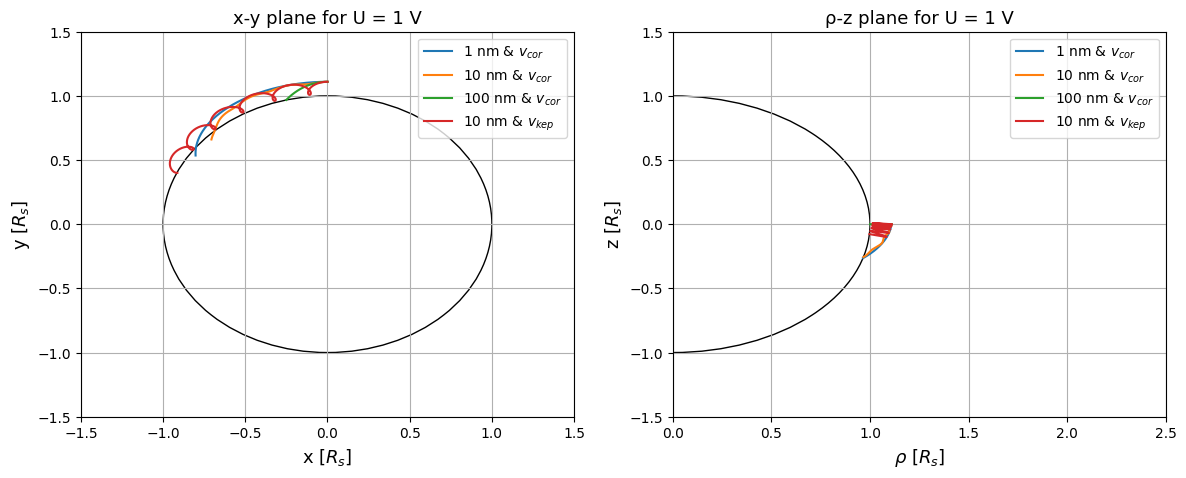

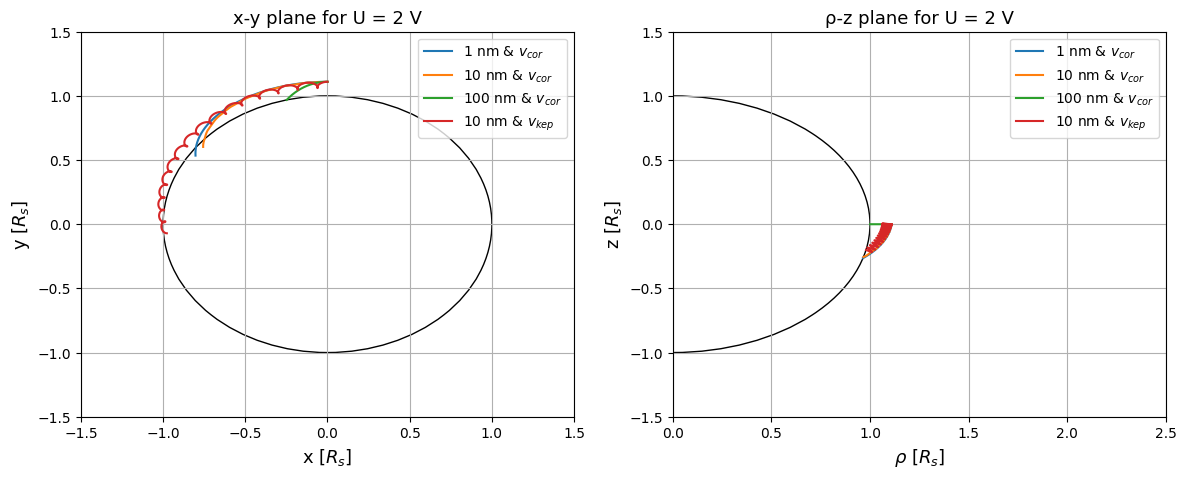

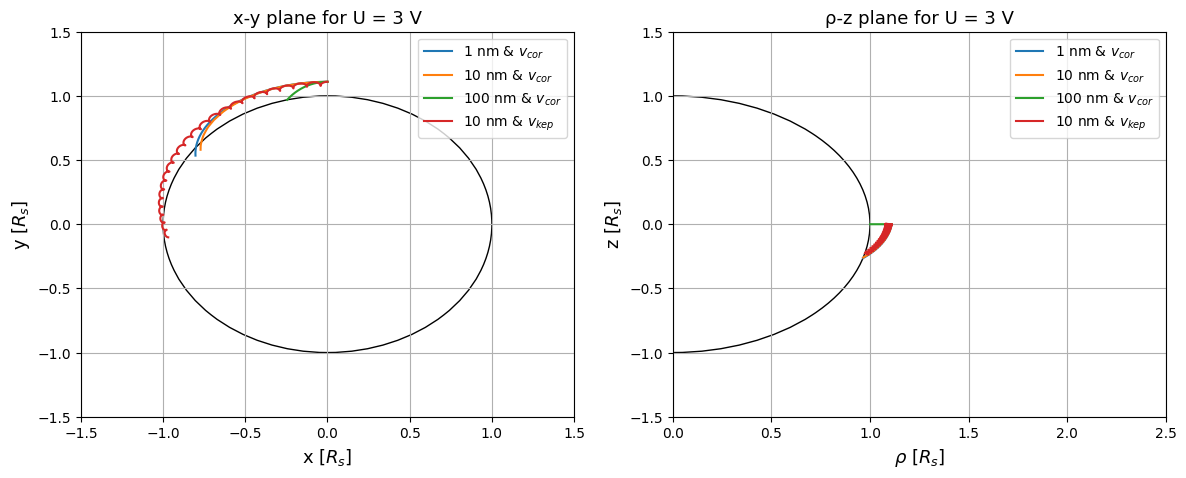

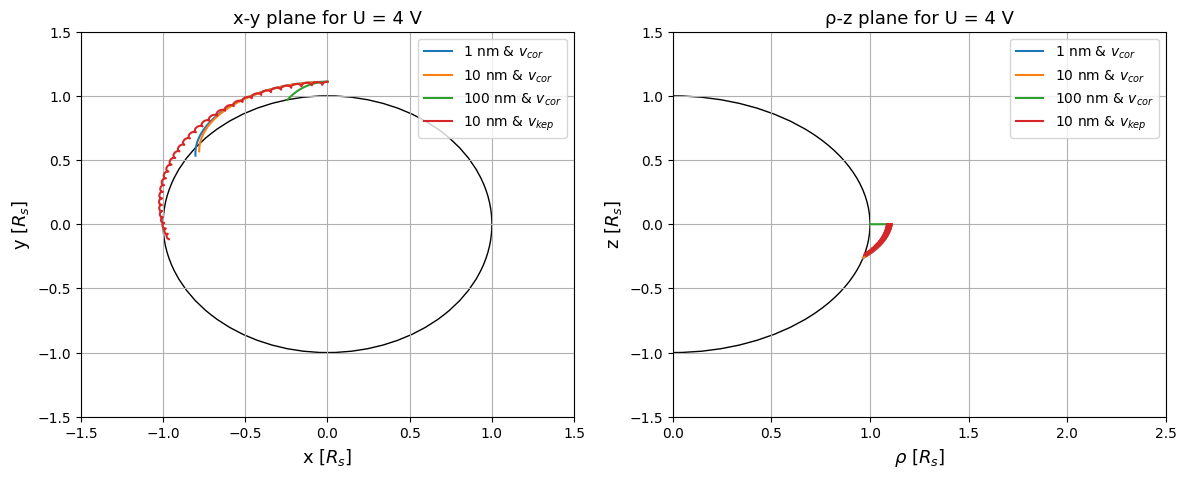

In [104]:
for U in U_plot:
    if np.sign(U)<0:
        V_txt='U = m_'+str(int(abs(U)))+' V'
        title='for U = '+str(U)+' V'
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    elif np.sign(U)>0:
        V_txt='U = p_'+str(int(abs(U)))+' V'
        title='for U = '+str(U)+' V'
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    else:
        V_txt='drag_only_'
        title=''
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    Sat_xy=plt.Circle((0,0),Rs/Rs, color='k',fill=False)
    Sat_xz=plt.Circle((0,0),Rs/Rs, color='k',fill=False)
    axs[0].add_patch(Sat_xy)
    axs[1].add_patch(Sat_xz)
    for Rg0 in R_g0_plot:
        x = particle[U][Rg0]['x']; y = particle[U][Rg0]['y']; z = particle[U][Rg0]['z']
        if particle[U][Rg0]['v0_txt']=='$v_{kep}$':
            line='-'
        elif particle[U][Rg0]['v0_txt']=='$v_{cor}$':
            line='-'
        axs[0].plot(np.array(x)/Rs,np.array(y)/Rs,linestyle=line, label=str(int(Rg0*1e+9))+' nm & '+ particle[U][Rg0]['v0_txt'])
        axs[1].plot(np.sqrt(np.array(x)**2+np.array(y)**2)/Rs,np.array(z)/Rs,linestyle=line, label=str(int(Rg0*1e+9))+' nm & '+ particle[U][Rg0]['v0_txt'])
        
    axs[0].set_title('x-y plane '+title, fontsize=13)
    axs[0].set_xlabel('x [$R_s$]', fontsize=13)
    axs[0].set_ylabel('y [$R_s$]', fontsize=13)
    axs[0].set_xlim([-1.5,1.5])
    axs[0].set_ylim([-1.5,1.5])
    axs[0].grid()
    axs[0].legend()
    
    axs[1].set_title('ρ-z plane '+title, fontsize=13)
    axs[1].set_xlabel(r'$\rho$ [$R_s$]', fontsize=13)
    axs[1].set_ylabel('z [$R_s$]', fontsize=13)
    axs[1].set_xlim([0,2.5])
    axs[1].set_ylim([-1.5,1.5])
    axs[1].grid()
    axs[1].legend()
    fig.savefig('traj_'+V_txt+'.png', dpi='figure')

In [105]:
for U in U_plot:
    print('U = ', U)
    for Rg0 in R_g0_plot:
        print('Rg0 = ',Rg0*1e9, ' final mass: m/m0 = ', particle[U][Rg0]['m'][-1]/particle[U][Rg0]['m0'])

U =  1
Rg0 =  1.0  final mass: m/m0 =  1.0
Rg0 =  10.0  final mass: m/m0 =  1.0
Rg0 =  100.00000000000001  final mass: m/m0 =  1.0
Rg0 =  10.00001  final mass: m/m0 =  1.0
U =  2
Rg0 =  1.0  final mass: m/m0 =  1.0
Rg0 =  10.0  final mass: m/m0 =  1.0
Rg0 =  100.00000000000001  final mass: m/m0 =  1.0
Rg0 =  10.00001  final mass: m/m0 =  1.0
U =  3
Rg0 =  1.0  final mass: m/m0 =  1.0
Rg0 =  10.0  final mass: m/m0 =  1.0
Rg0 =  100.00000000000001  final mass: m/m0 =  1.0
Rg0 =  10.00001  final mass: m/m0 =  1.0
U =  4
Rg0 =  1.0  final mass: m/m0 =  1.0
Rg0 =  10.0  final mass: m/m0 =  1.0
Rg0 =  100.00000000000001  final mass: m/m0 =  1.0
Rg0 =  10.00001  final mass: m/m0 =  1.0


In [106]:
def B_coord(Bx, By, Bz):
    B=np.array([Bx, By, Bz])
    Bt=B/np.linalg.norm(B)
    Bp1_non_unit=np.cross(Bt, np.array([0, 0, 1]))
    Bp1=Bp1_non_unit/np.linalg.norm(Bp1_non_unit)
    Bp2=np.cross(Bt, Bp1)
    return Bt, Bp1, Bp2

def transf(Bt, Bp1, Bp2, A):
    return np.dot(A, Bt), np.dot(A, Bp1), np.dot(A, Bp2)
    
def B_cart(x, y, z, Mom, Rs):
    z_s = 0.04*Rs
    r_s = np.sqrt(x**2+y**2+(z-z_s)**2)
    Bx = 3*Mom*x*(z-z_s)/r_s**5  
    By = 3*Mom*y*(z-z_s)/r_s**5  
    Bz = Mom*(3*(z-z_s)**2-r_s**2)/r_s**5
        
    return Bx, By, Bz

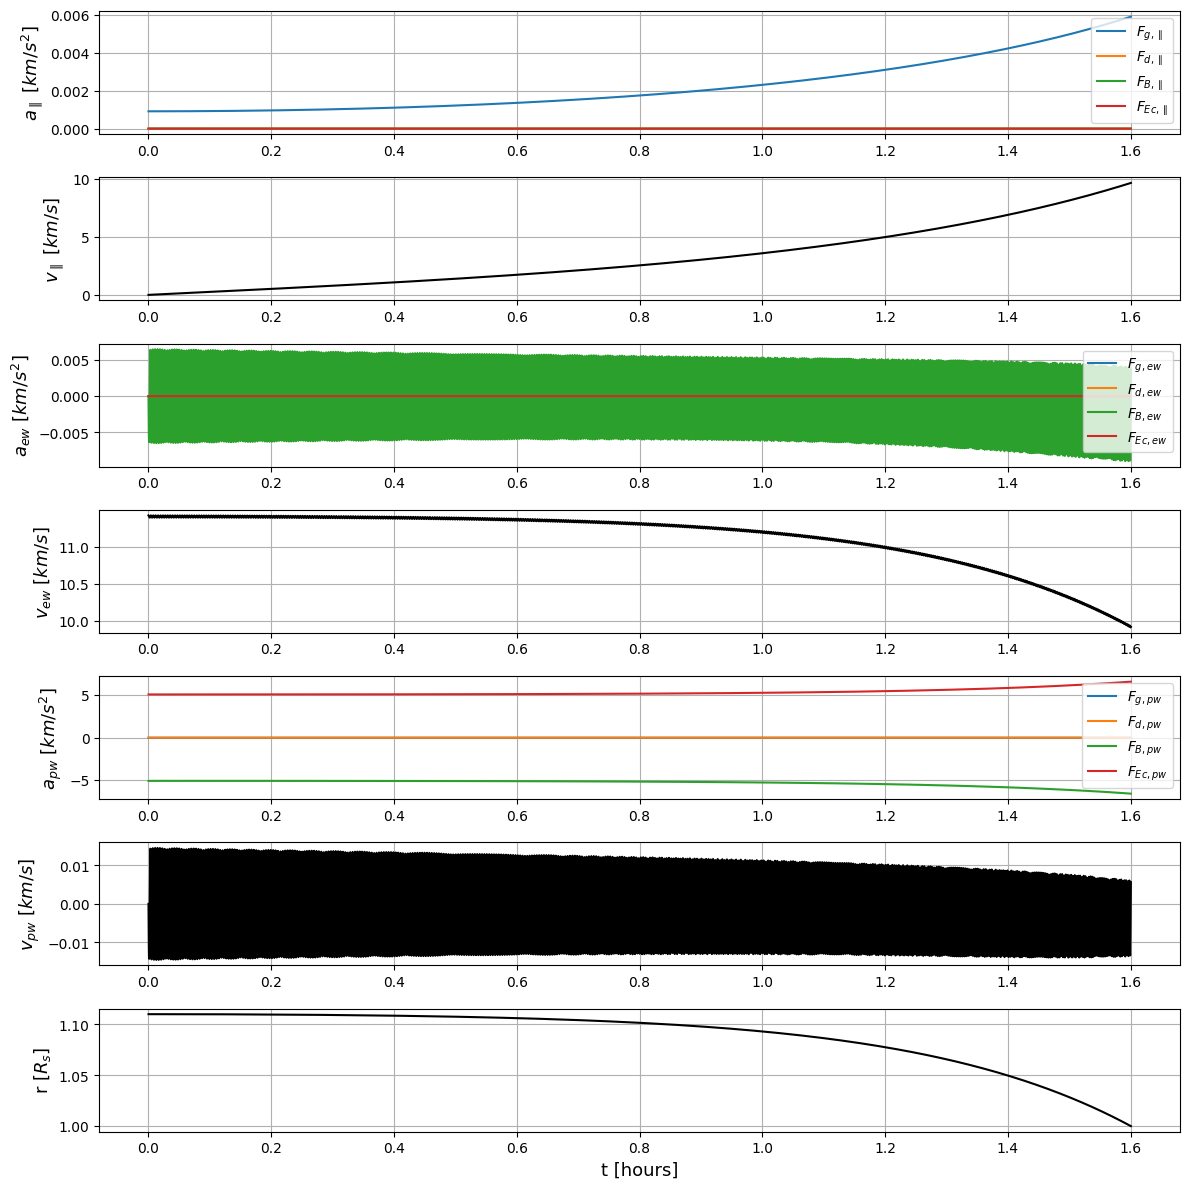

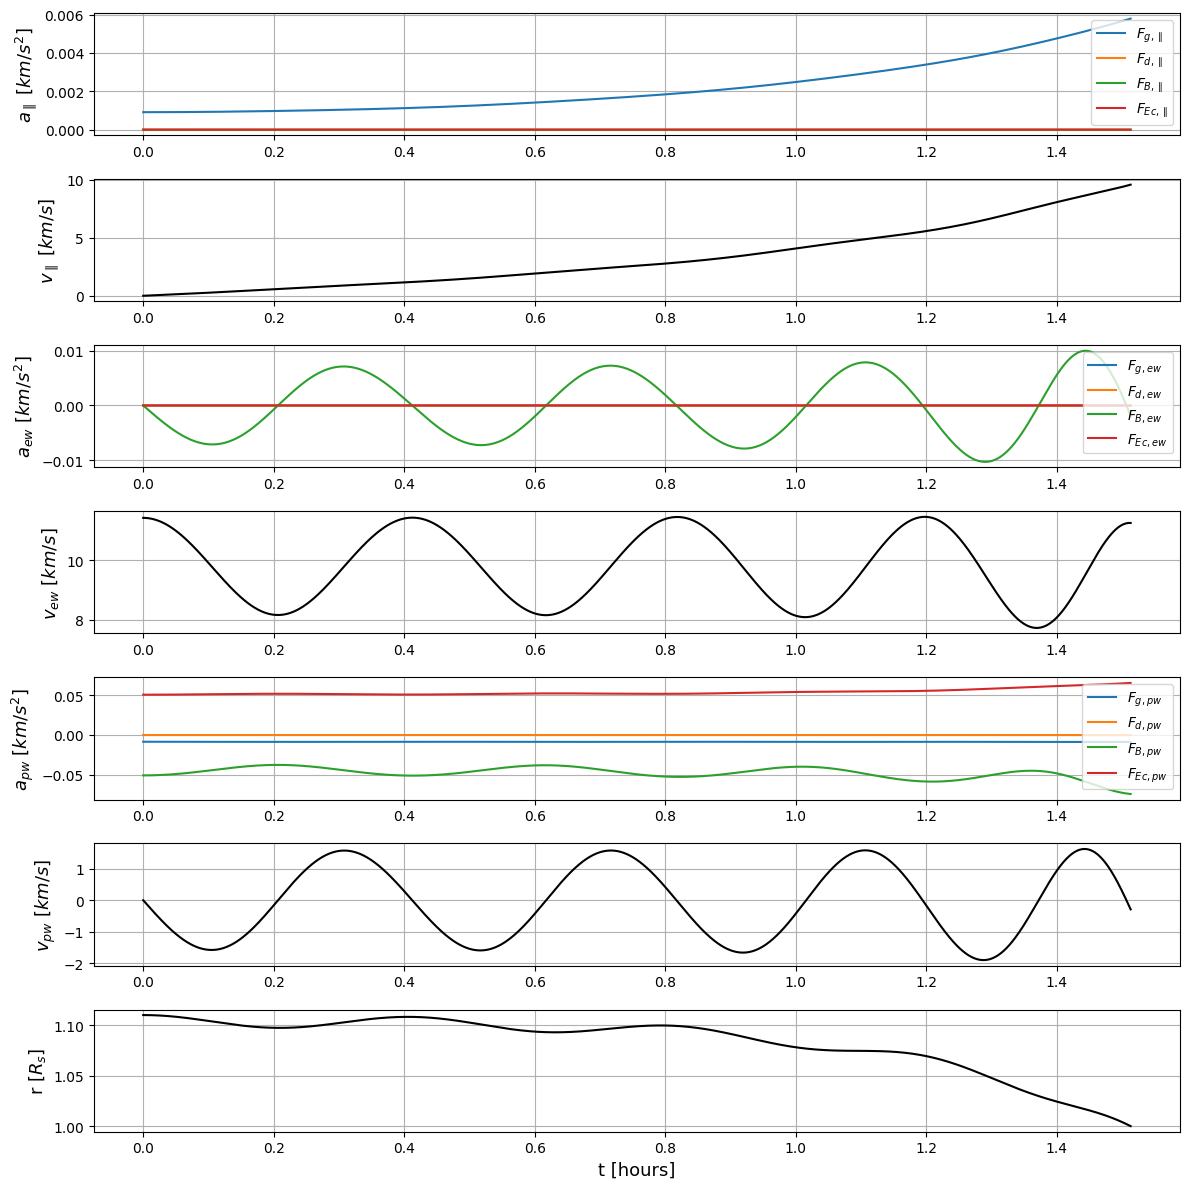

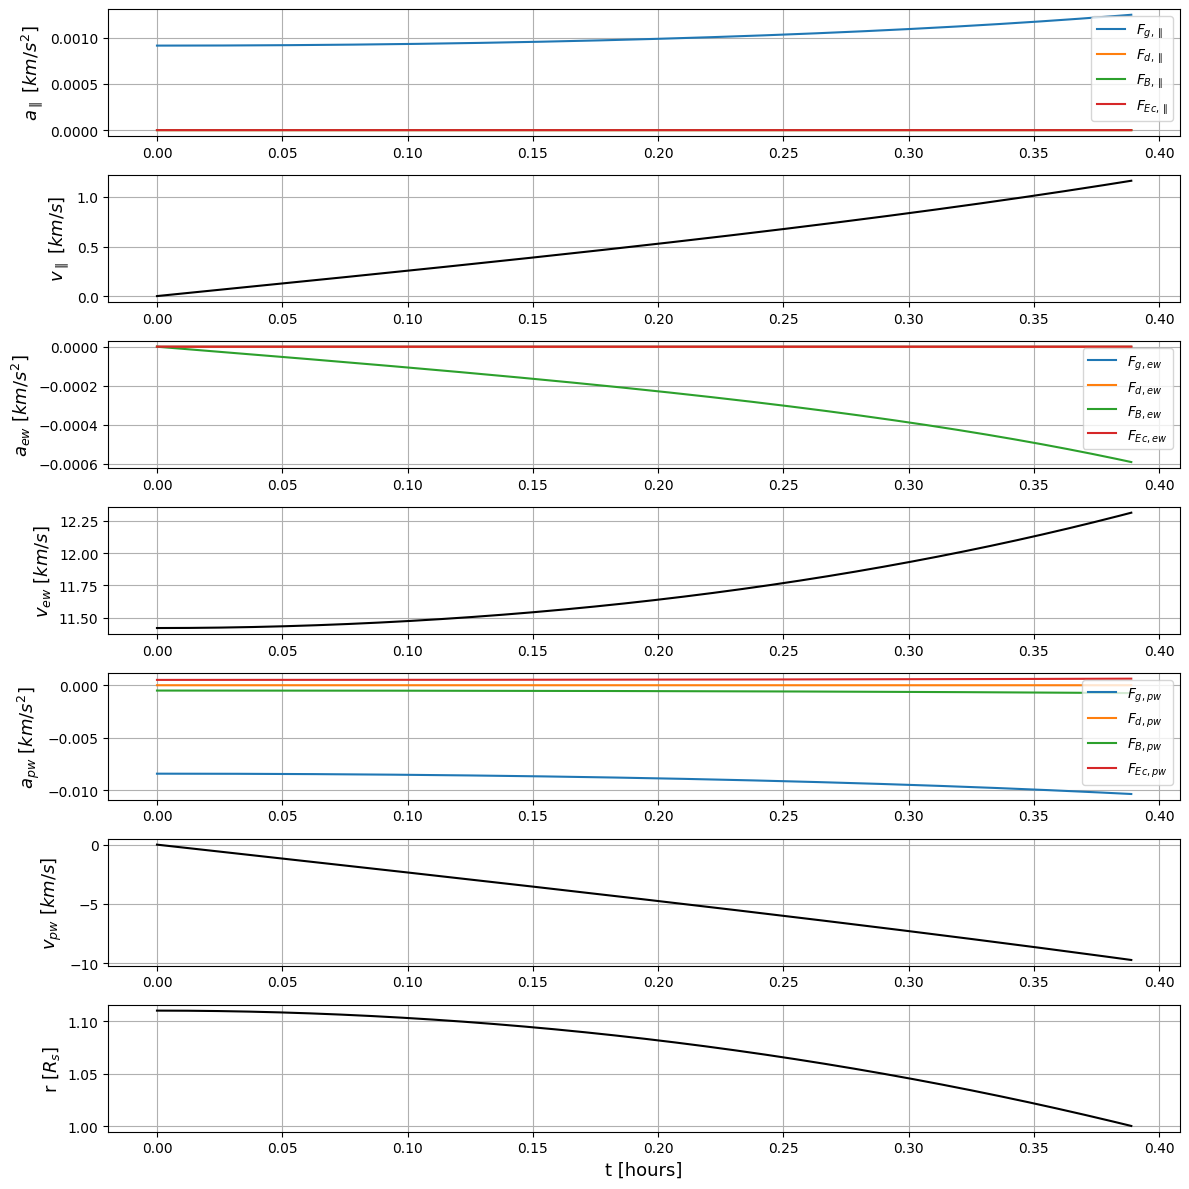

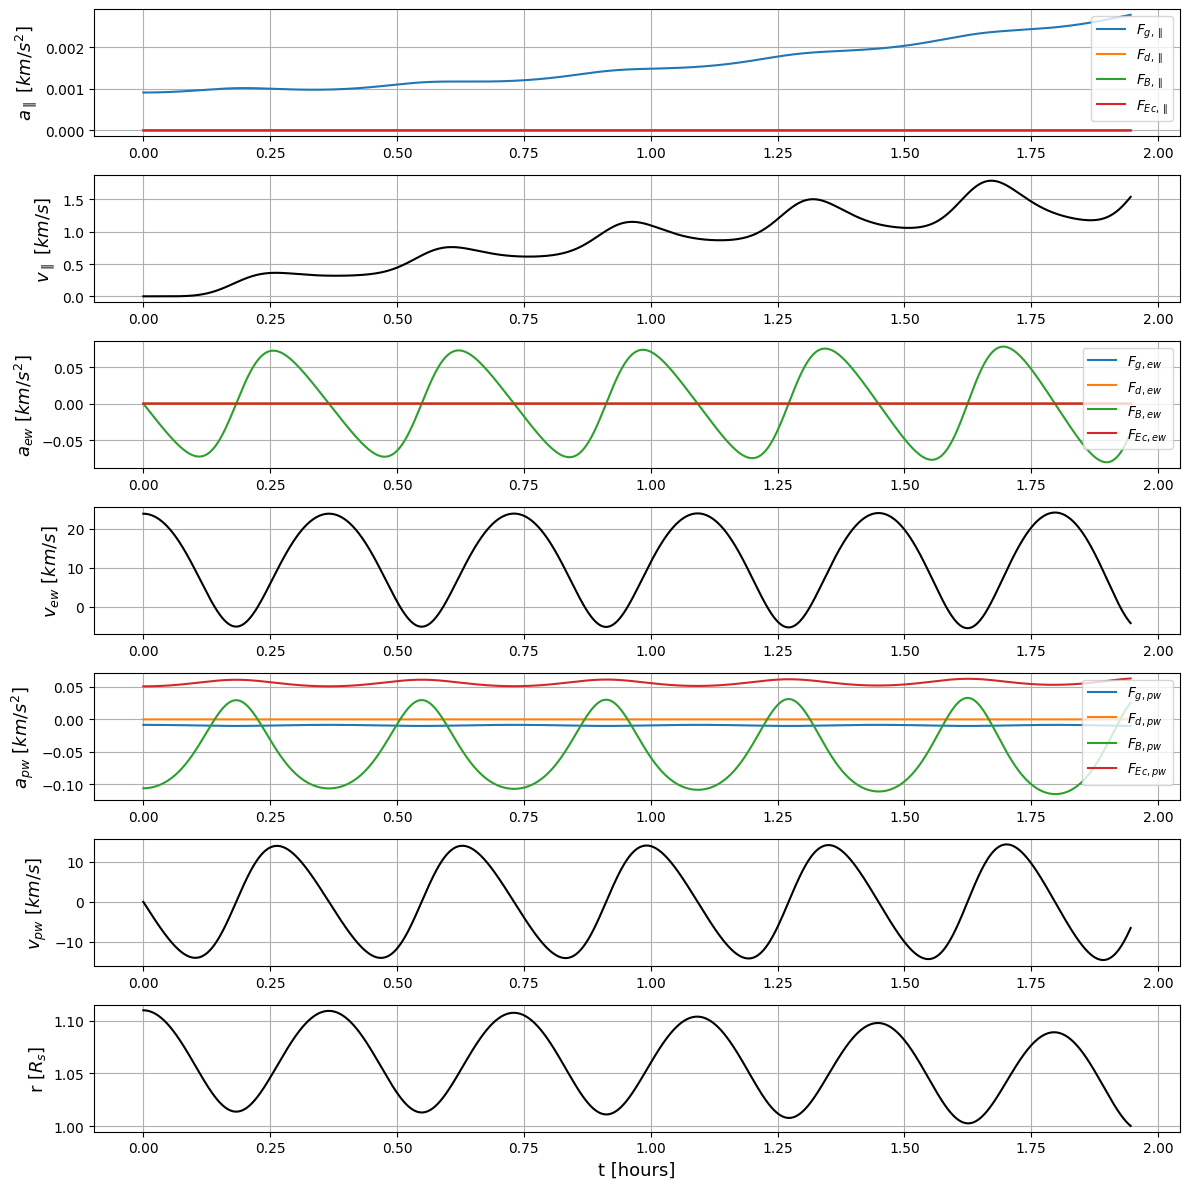

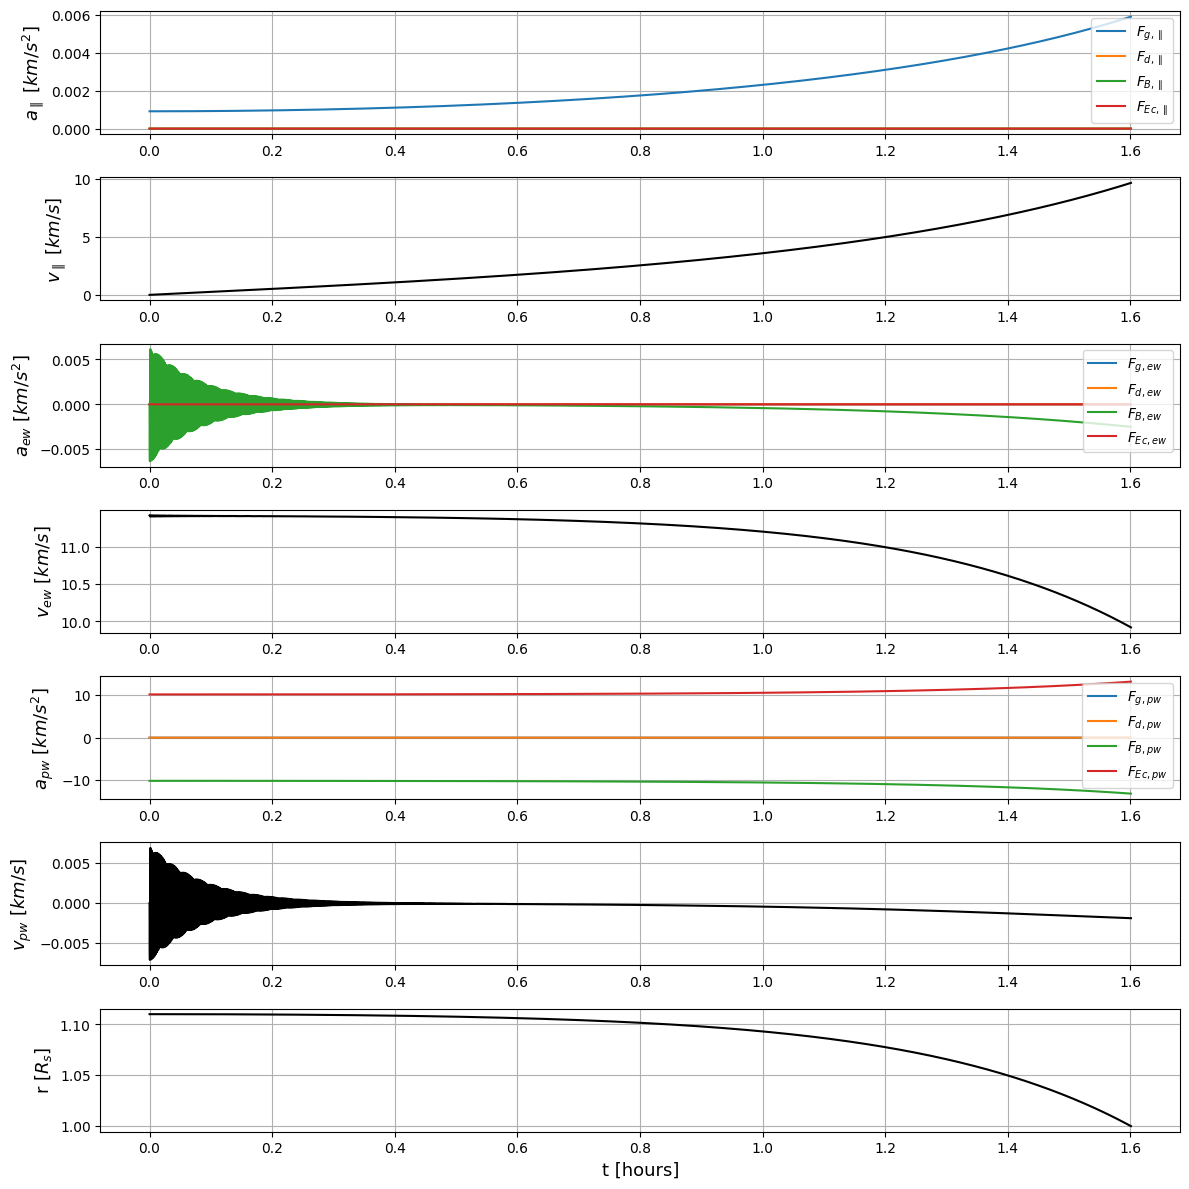

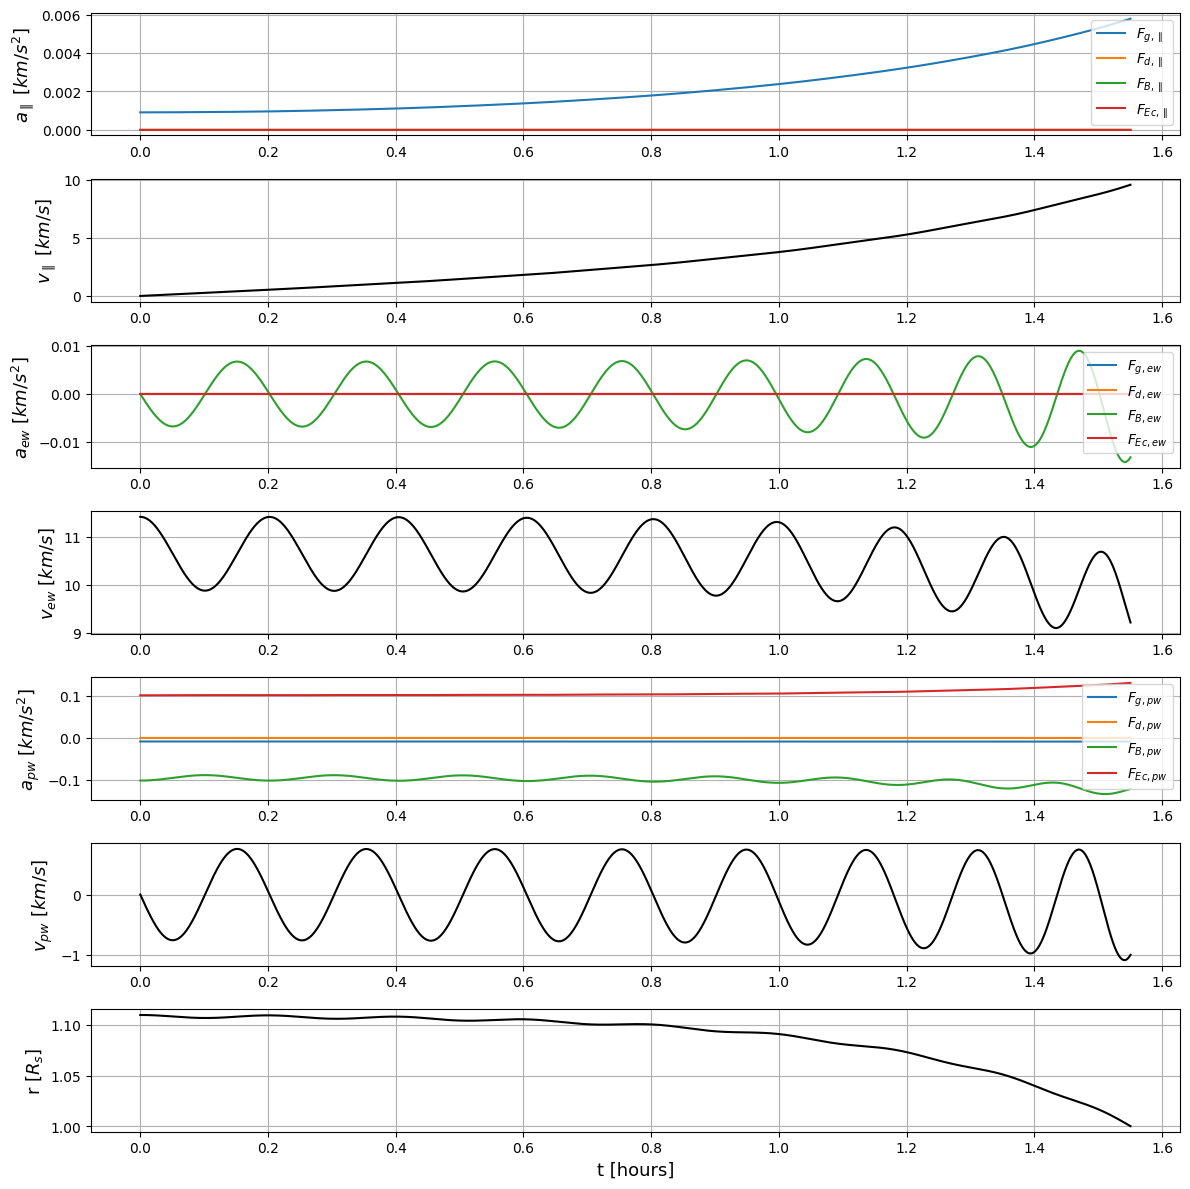

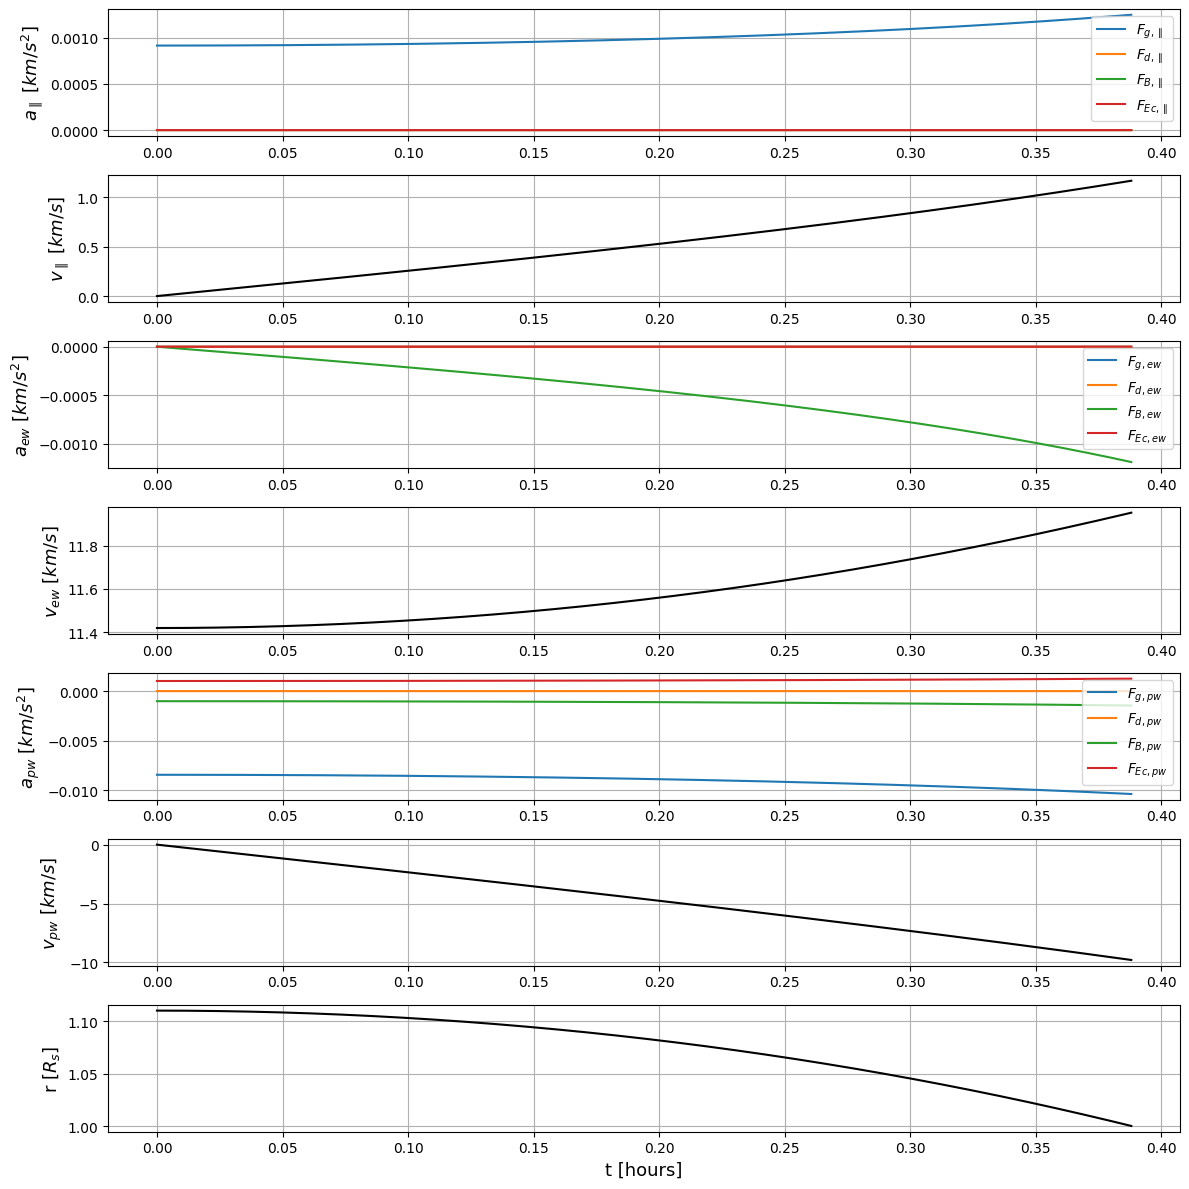

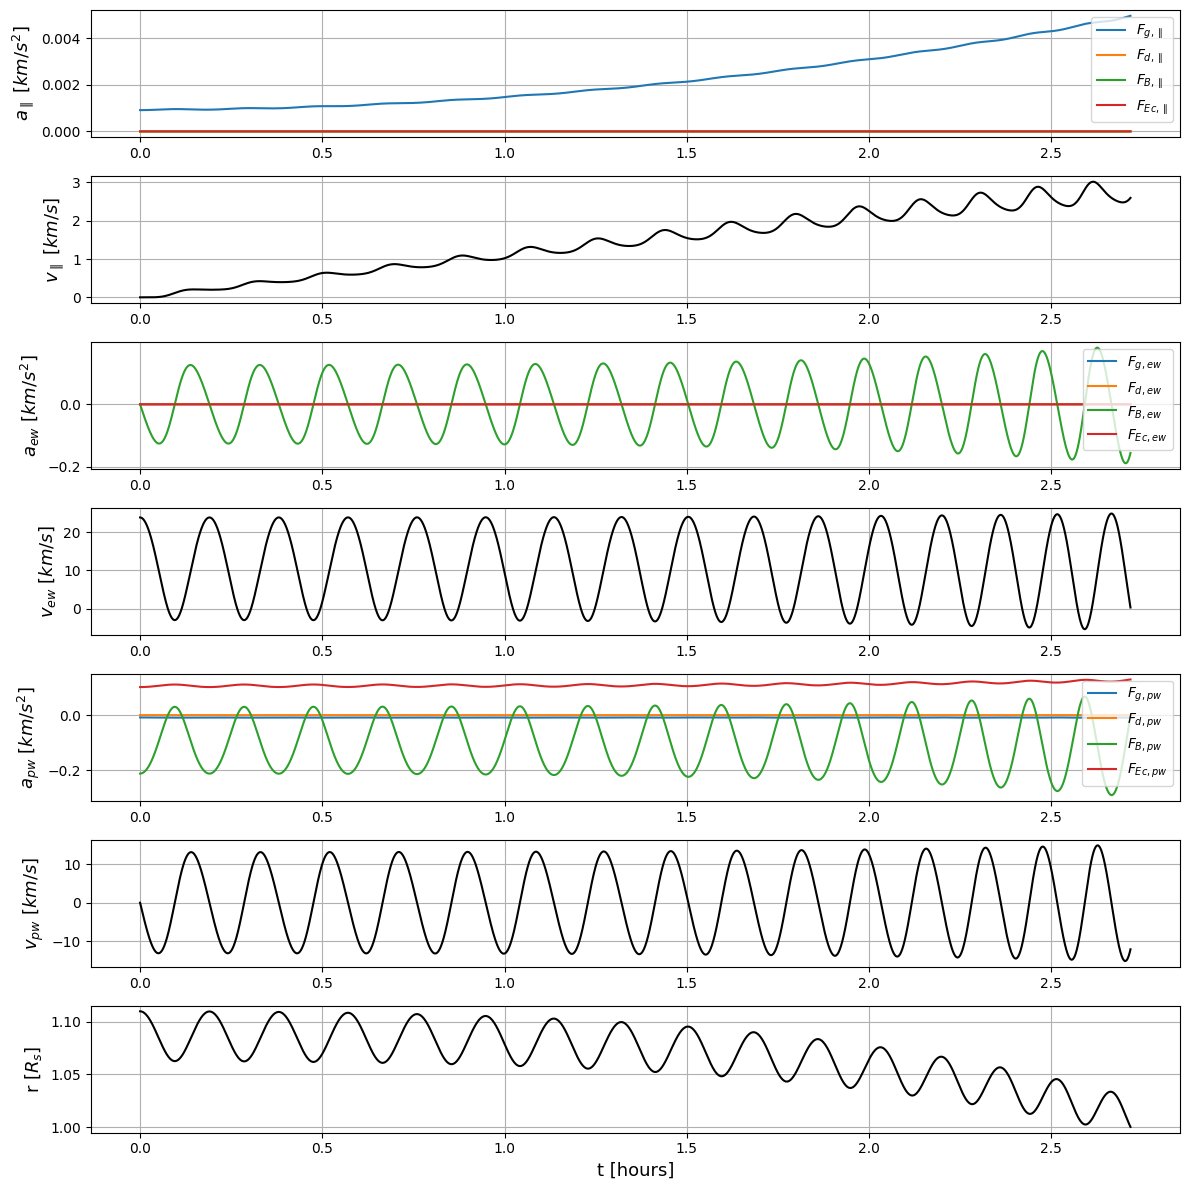

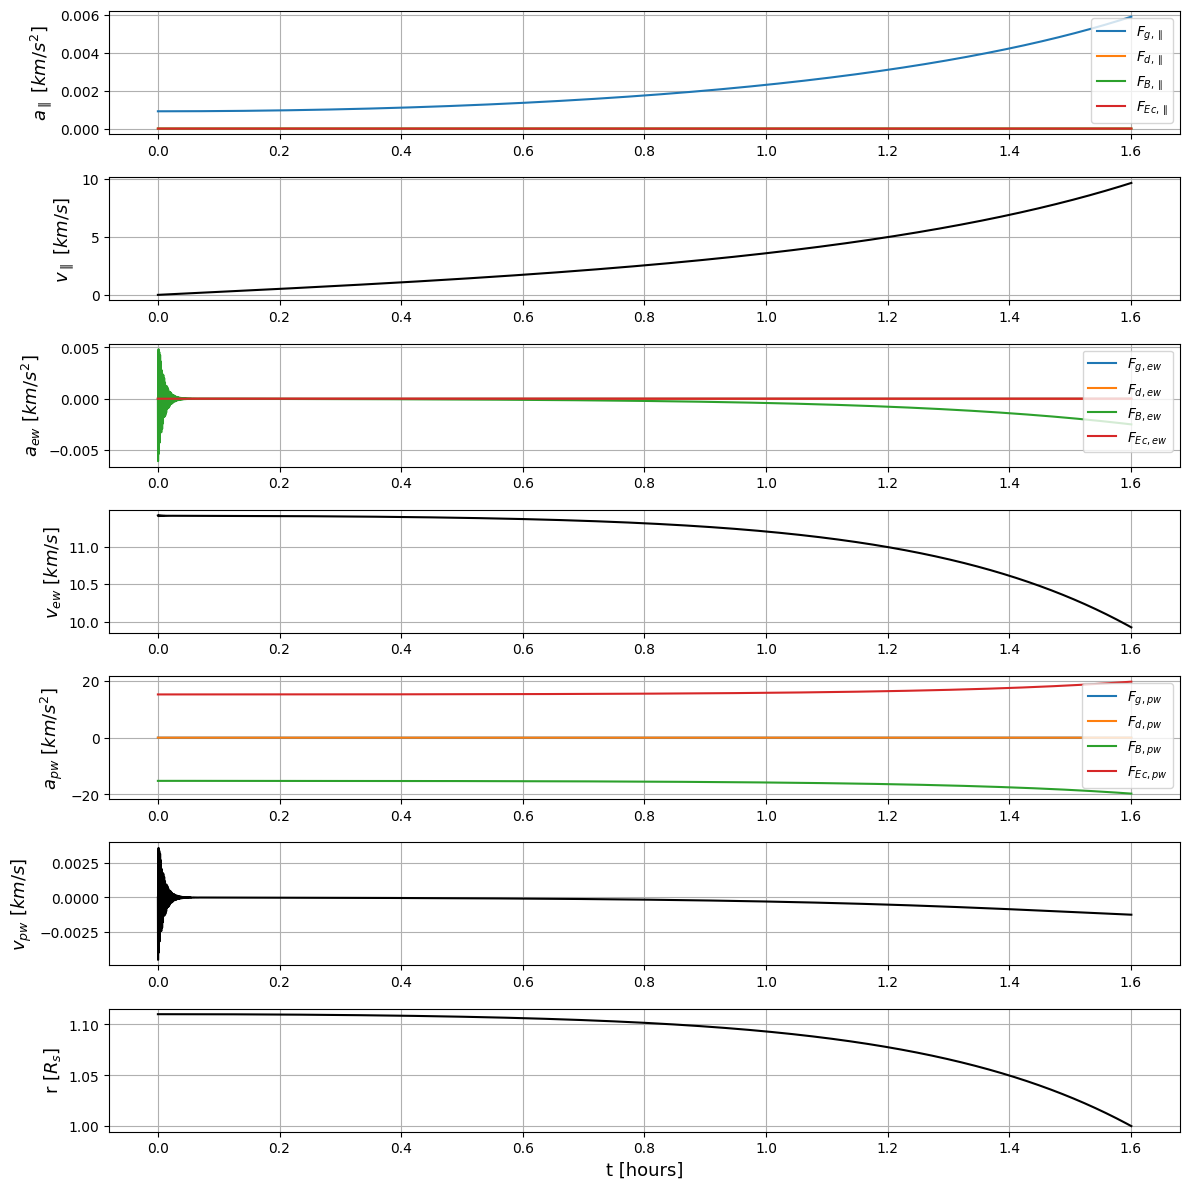

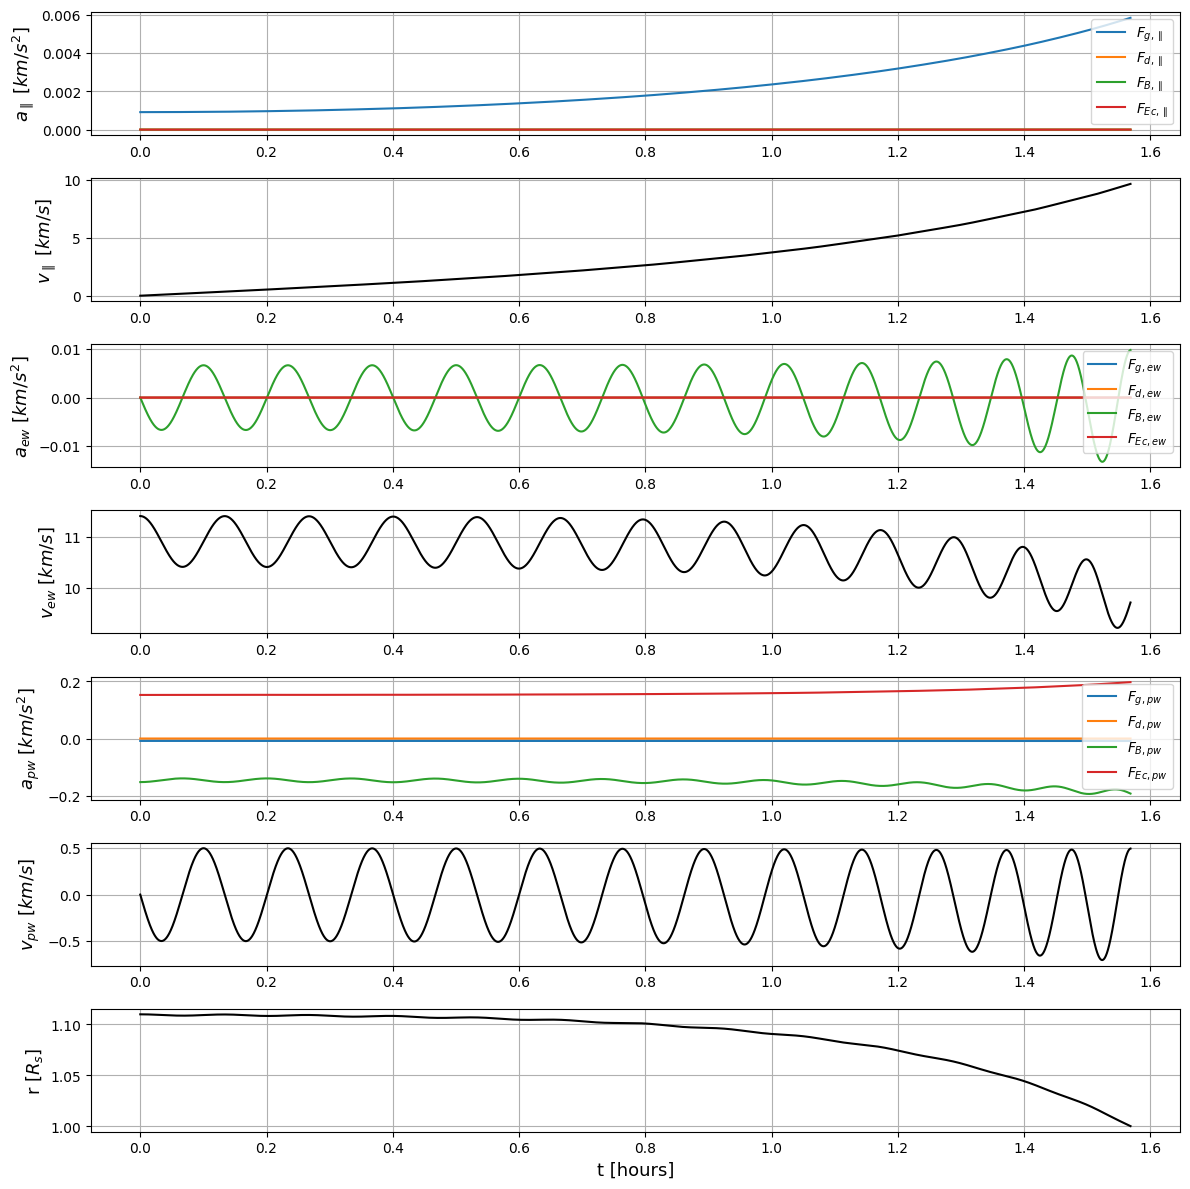

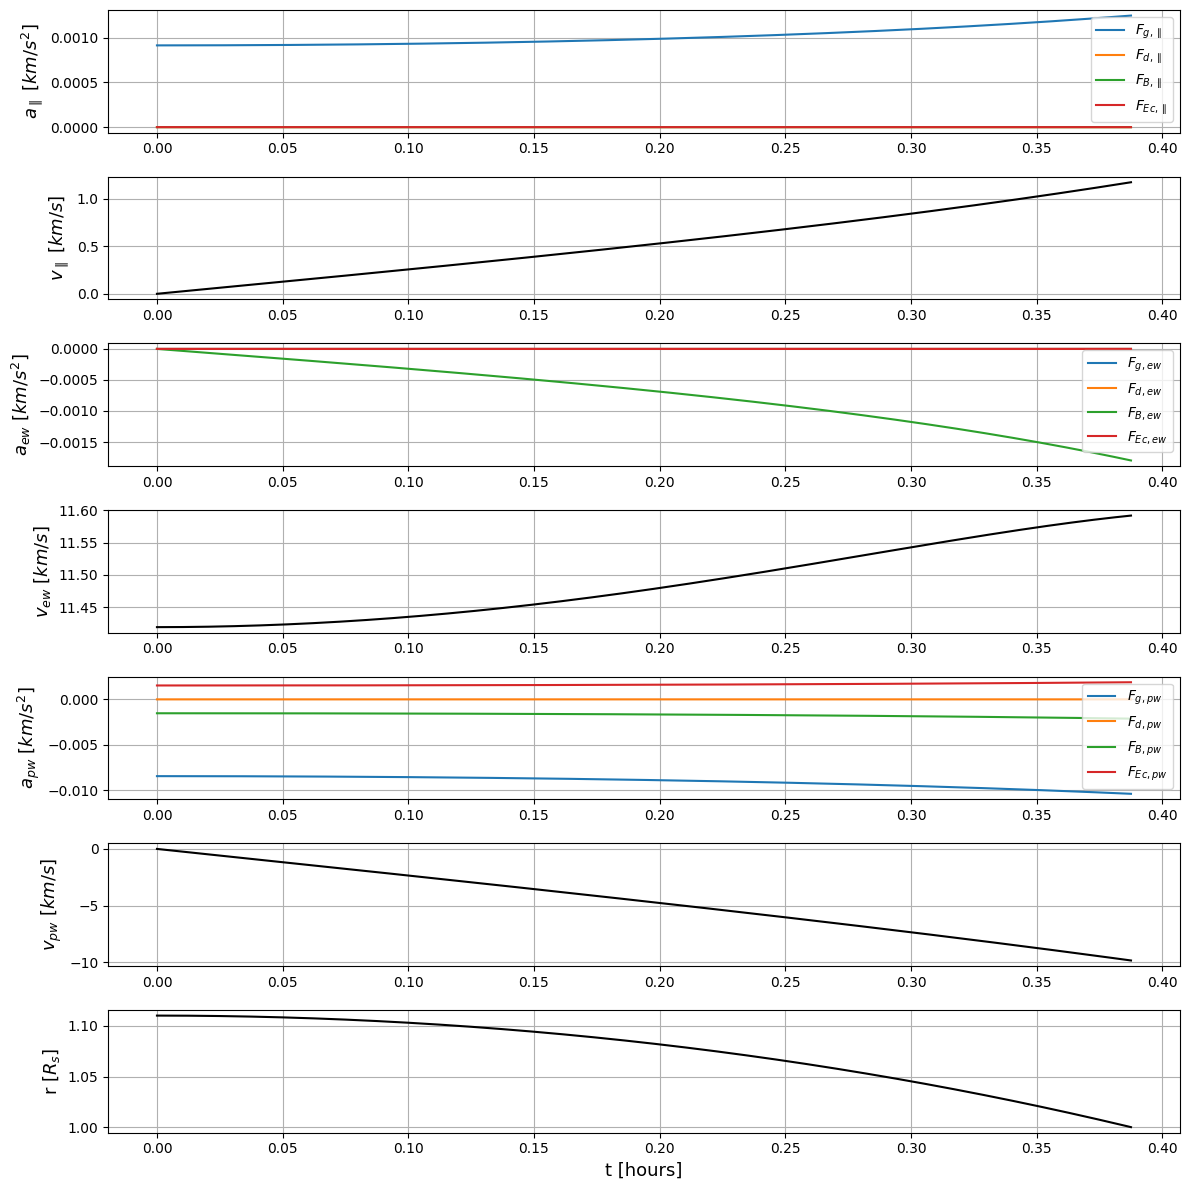

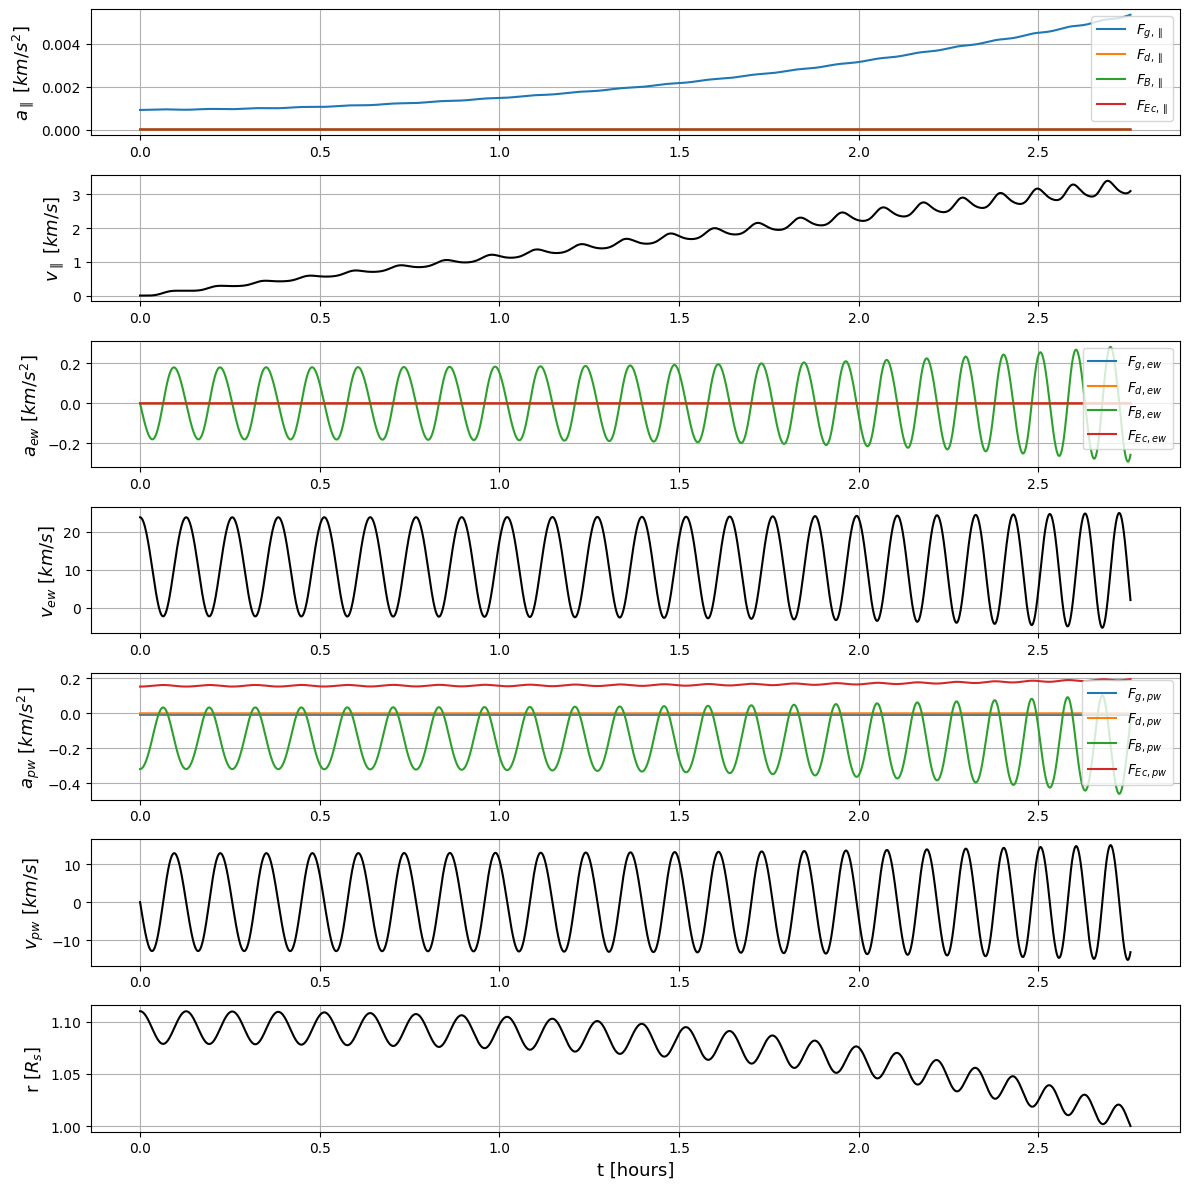

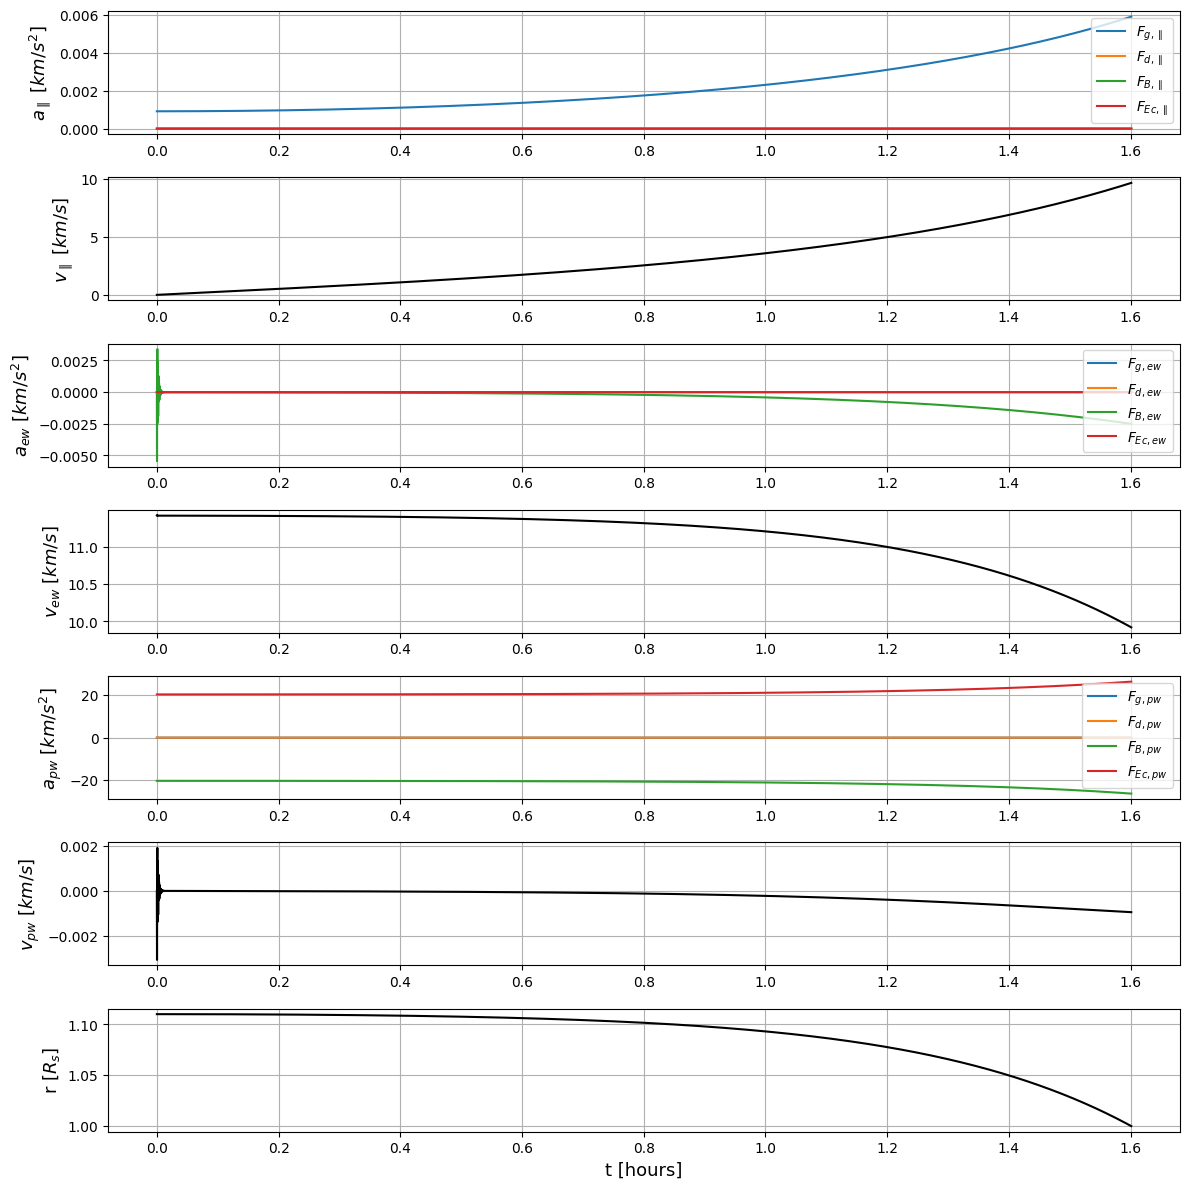

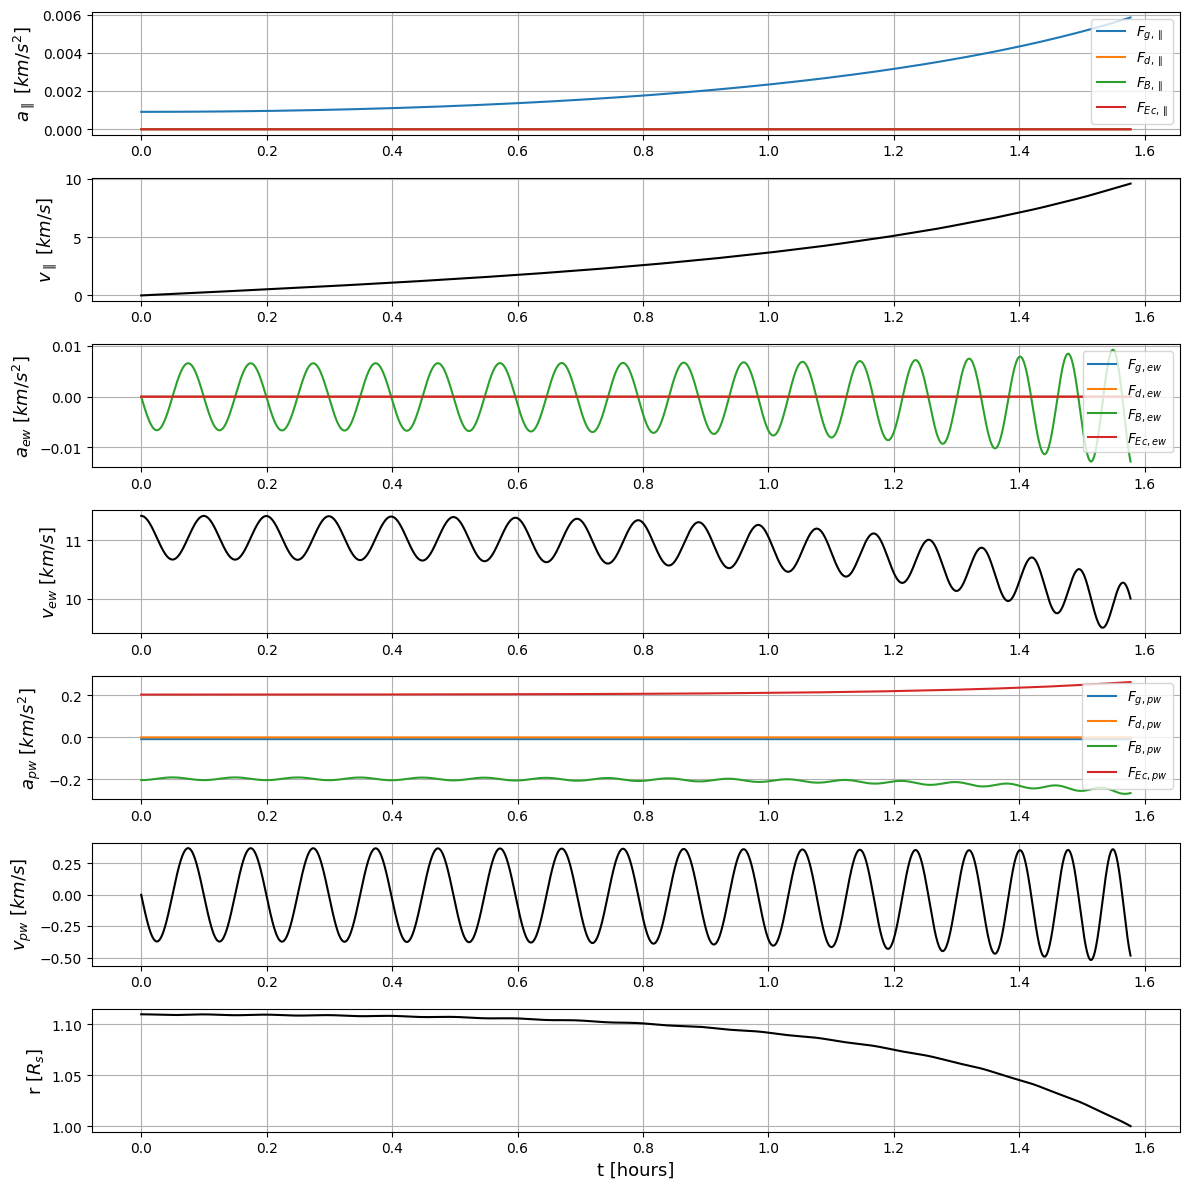

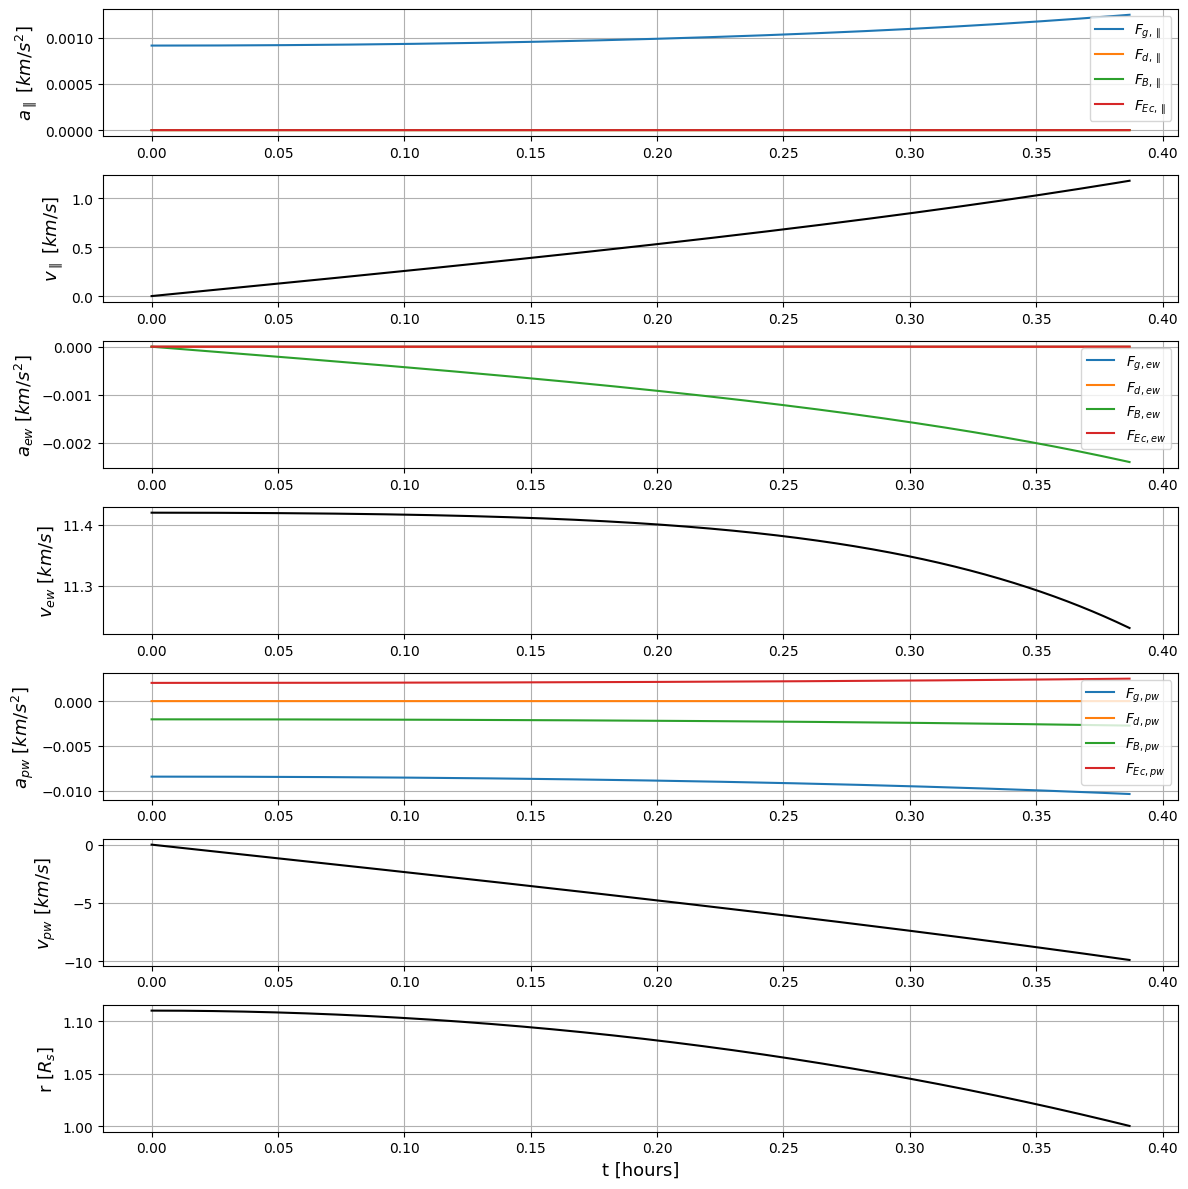

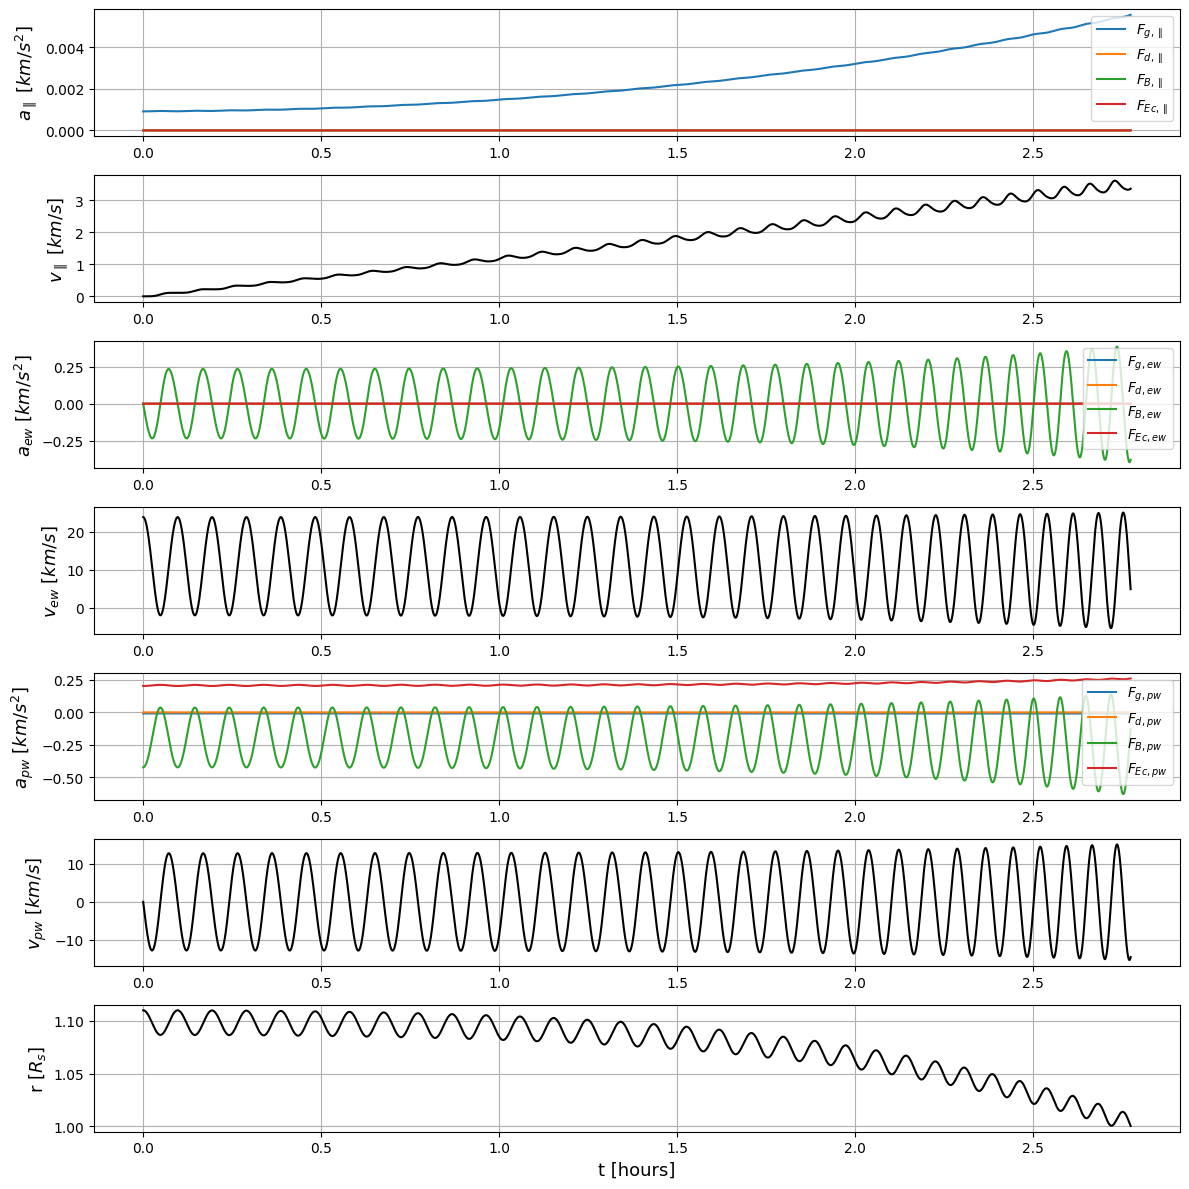

In [107]:
## using the variable axs for multiple Axes
U_plot=list(particle.keys())#np.array([U0[0], U0[3]])
R_g0_plot=list(particle[U_plot[0]].keys())#np.array([R_grain0[1], R_grain0[-1]])

for U in U_plot:
    if U==0: break
    if np.sign(U)<0:
        V_txt='U = m_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    elif np.sign(U)>0:
        V_txt='U = p_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    else:
        V_txt='drag_only_'
    for Rg0 in R_g0_plot:
        le=int(len(particle[U][Rg0]['r']))
        tt=np.linspace(0, particle[U][Rg0]['t_final'], le)/(60*60)
        #tt=np.arange(0, particle[U][Rg0]['t_final']+particle[], particle[U][Rg0]['dt'])/(60*60)
        x=np.array(particle[U][Rg0]['x']); y=np.array(particle[U][Rg0]['y']); z=np.array(particle[U][Rg0]['z']); r=np.array(particle[U][Rg0]['r']);

        fig, axs = plt.subplots(7, 1, figsize=(12,12))
       # fig.suptitle('Force components field line coordinates: '+V_txt+'Rg_0 = ' + str(int(Rg0*1e9)) + ' nm & '+particle[U][Rg0]['v0_txt'])
        vx=[]; vy=[]; vz=[]
        gr_x=[]; gr_y=[]; gr_z=[]; dr_x=[]; dr_y=[]; dr_z=[]; mag_x=[]; mag_y=[]; mag_z=[]; Ec_x=[]; Ec_y=[]; Ec_z=[]
        Bx=[]; By=[]; Bz=[]; B=[]; Bt=[]; Bp1=[]; Bp2=[]
        
        gr_f1=[]; gr_f2=[]; gr_f3=[]; dr_f1=[]; dr_f2=[]; dr_f3=[]; mag_f1=[]; mag_f2=[]; mag_f3=[]; Ec_f1=[]; Ec_f2=[]; Ec_f3=[];
        v_f1=[]; v_f2=[]; v_f3=[]
        for i in range(le):
            vx.append(particle[U][Rg0]['vx'][i]); vy.append(particle[U][Rg0]['vy'][i]); vz.append(particle[U][Rg0]['vz'][i])
            gr_x.append(particle[U][Rg0]['a_gr'][i][0]); gr_y.append(particle[U][Rg0]['a_gr'][i][1]); gr_z.append(particle[U][Rg0]['a_gr'][i][2]);
            dr_x.append(particle[U][Rg0]['a_drag'][i][0]); dr_y.append(particle[U][Rg0]['a_drag'][i][1]); dr_z.append(particle[U][Rg0]['a_drag'][i][2]);
            mag_x.append(particle[U][Rg0]['a_mag'][i][0]); mag_y.append(particle[U][Rg0]['a_mag'][i][1]); mag_z.append(particle[U][Rg0]['a_mag'][i][2]);
            Ec_x.append(particle[U][Rg0]['a_Ec'][i][0]); Ec_y.append(particle[U][Rg0]['a_Ec'][i][1]); Ec_z.append(particle[U][Rg0]['a_Ec'][i][2]); 
            Bx.append(B_cart(x[i], y[i], z[i], Mom, Rs)[0]); By.append(B_cart(x[i], y[i], z[i], Mom, Rs)[1]); Bz.append(B_cart(x[i], y[i], z[i], Mom, Rs)[2])
            
            Bt, Bp1, Bp2 = B_coord(Bx[i], By[i], Bz[i])
            
            gr=np.array([gr_x[i], gr_y[i], gr_z[i]]); dr=np.array([dr_x[i], dr_y[i], dr_z[i]]); mag=np.array([mag_x[i], mag_y[i], mag_z[i]])
            Ec=np.array([Ec_x[i], Ec_y[i], Ec_z[i]]); v=np.array([vx[i], vy[i], vz[i]])
            gr_f1.append(transf(Bt, Bp1, Bp2, gr)[0]); gr_f2.append(transf(Bt, Bp1, Bp2, gr)[1]); gr_f3.append(transf(Bt, Bp1, Bp2, gr)[2]);
            dr_f1.append(transf(Bt, Bp1, Bp2, dr)[0]); dr_f2.append(transf(Bt, Bp1, Bp2, dr)[1]); dr_f3.append(transf(Bt, Bp1, Bp2, dr)[2]);
            mag_f1.append(transf(Bt, Bp1, Bp2, mag)[0]);  mag_f2.append(transf(Bt, Bp1, Bp2, mag)[1]);  mag_f3.append(transf(Bt, Bp1, Bp2, mag)[2]);
            Ec_f1.append(transf(Bt, Bp1, Bp2, Ec)[0]); Ec_f2.append(transf(Bt, Bp1, Bp2, Ec)[1]); Ec_f3.append(transf(Bt, Bp1, Bp2, Ec)[2]); 
            v_f1.append(transf(Bt, Bp1, Bp2, v)[0]); v_f2.append(transf(Bt, Bp1, Bp2, v)[1]); v_f3.append(transf(Bt, Bp1, Bp2, v)[2]); 
            
        axs[0].plot(tt, gr_f1, label='$F_{g,\parallel}$')
        axs[0].plot(tt, dr_f1, label='$F_{d,\parallel}$')
        axs[0].plot(tt, mag_f1, label='$F_{B,\parallel}$')
        axs[0].plot(tt, Ec_f1, label='$F_{Ec,\parallel}$')
        axs[0].set_ylabel('$a_{\parallel}$ [$km/s^2$]', fontsize=13)
        axs[0].grid()
        axs[0].legend(loc='upper right')
        
        axs[1].plot(tt, np.array(v_f1)*1e-3, 'k')
        axs[1].set_ylabel('$v_{\parallel}$ [$km/s$]', fontsize=13)
        axs[1].grid()
        
        axs[2].plot(tt, gr_f2, label='$F_{g, ew}$')
        axs[2].plot(tt, dr_f2, label='$F_{d, ew}$')
        axs[2].plot(tt, mag_f2, label='$F_{B, ew}$')
        axs[2].plot(tt, Ec_f2, label='$F_{Ec, ew}$')
        axs[2].set_ylabel('$a_{ew}$ [$km/s^2$]', fontsize=13)
        axs[2].grid()
        axs[2].legend(loc='upper right')

        axs[3].plot(tt, np.array(v_f2)*1e-3, 'k')
        axs[3].grid()
        axs[3].set_ylabel('$v_{ew}$ [$km/s$]', fontsize=13)
        
        axs[4].plot(tt, gr_f3, label='$F_{g, pw}$')
        axs[4].plot(tt, dr_f3, label='$F_{d, pw}$')
        axs[4].plot(tt, mag_f3, label='$F_{B, pw}$')
        axs[4].plot(tt, Ec_f3, label='$F_{Ec, pw}$')
        axs[4].set_ylabel('$a_{pw}$ [$km/s^2$]', fontsize=13)
        axs[4].grid()
        axs[4].legend(loc='upper right')
        
        axs[5].plot(tt, np.array(v_f3)*1e-3, 'k')
        axs[5].grid()
        axs[5].set_ylabel('$v_{pw}$ [$km/s$]', fontsize=13)
        
        axs[6].plot(tt, r/Rs, 'k', label='r')
        axs[6].grid()
        axs[6].set_ylabel('r [$R_s$]', fontsize=13)
        axs[6].set_xlabel('t [hours]', fontsize=13)
        fig.tight_layout()
        fig.savefig('Field_coordinates_force_components_' +V_txt+str(int(Rg0*1e9))+' nm &'+particle[U][Rg0]['v0_txt'], dpi=500)

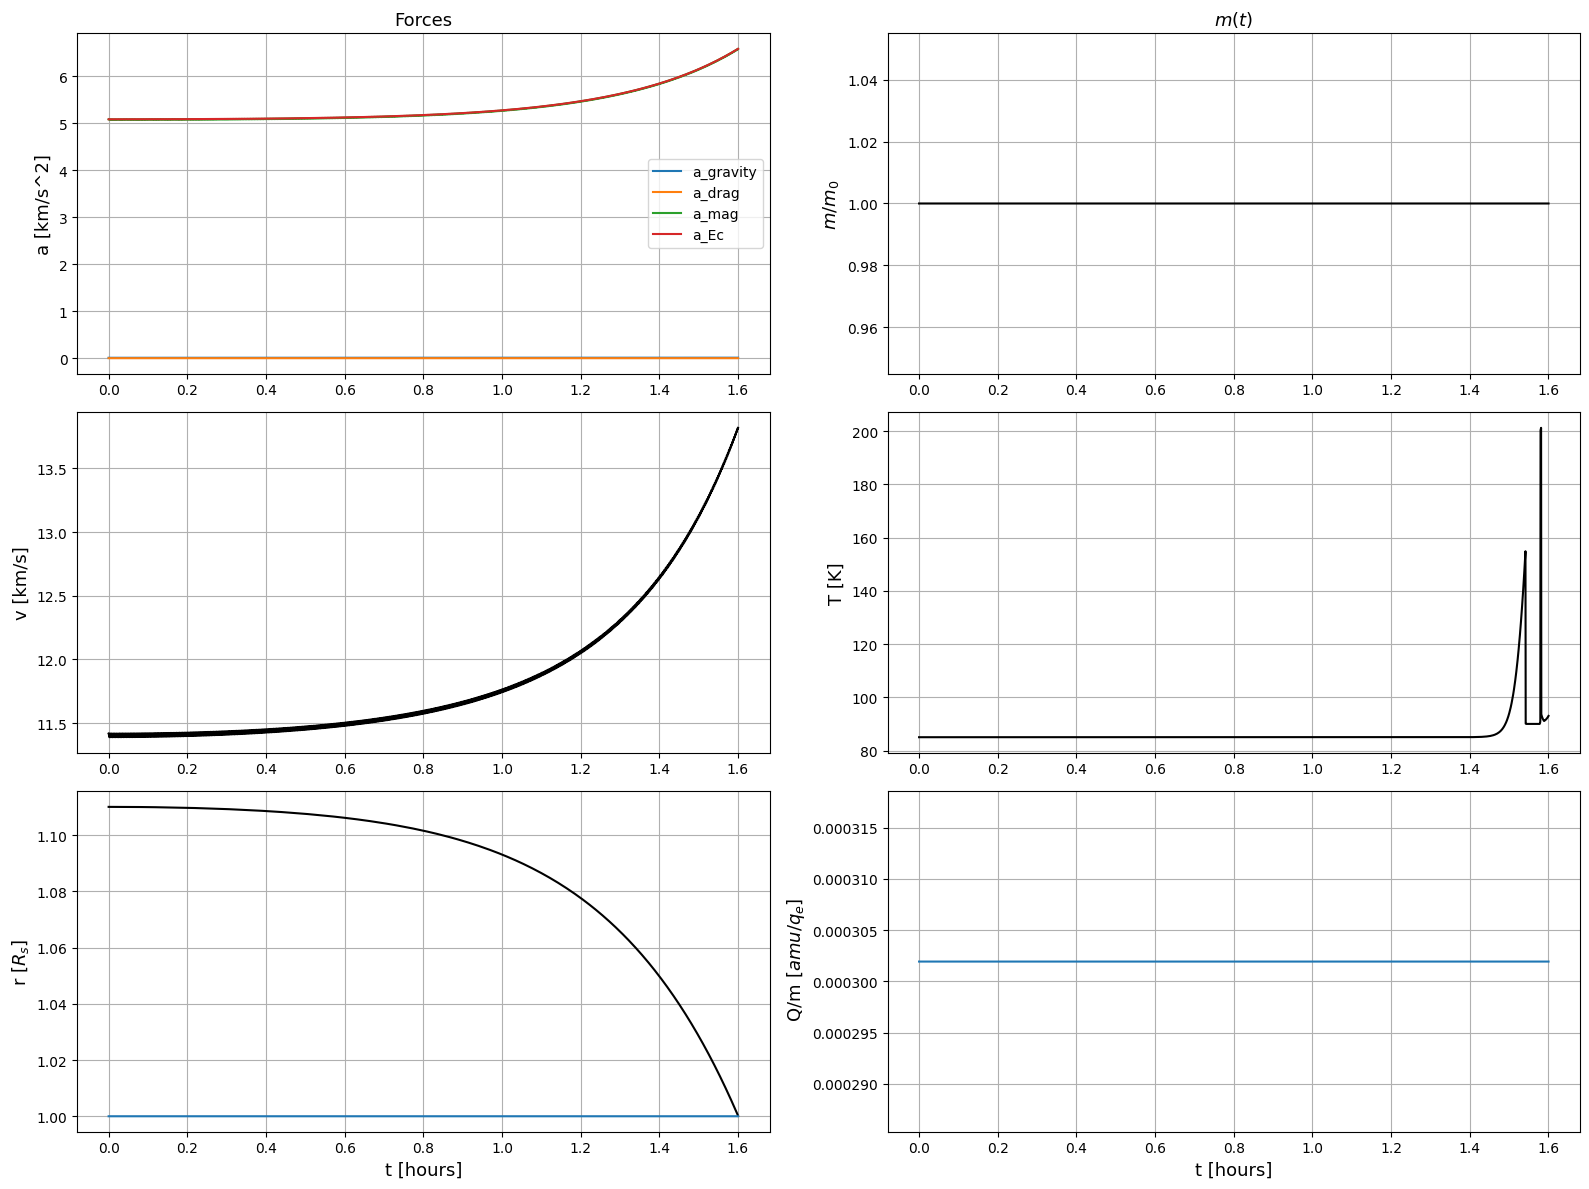

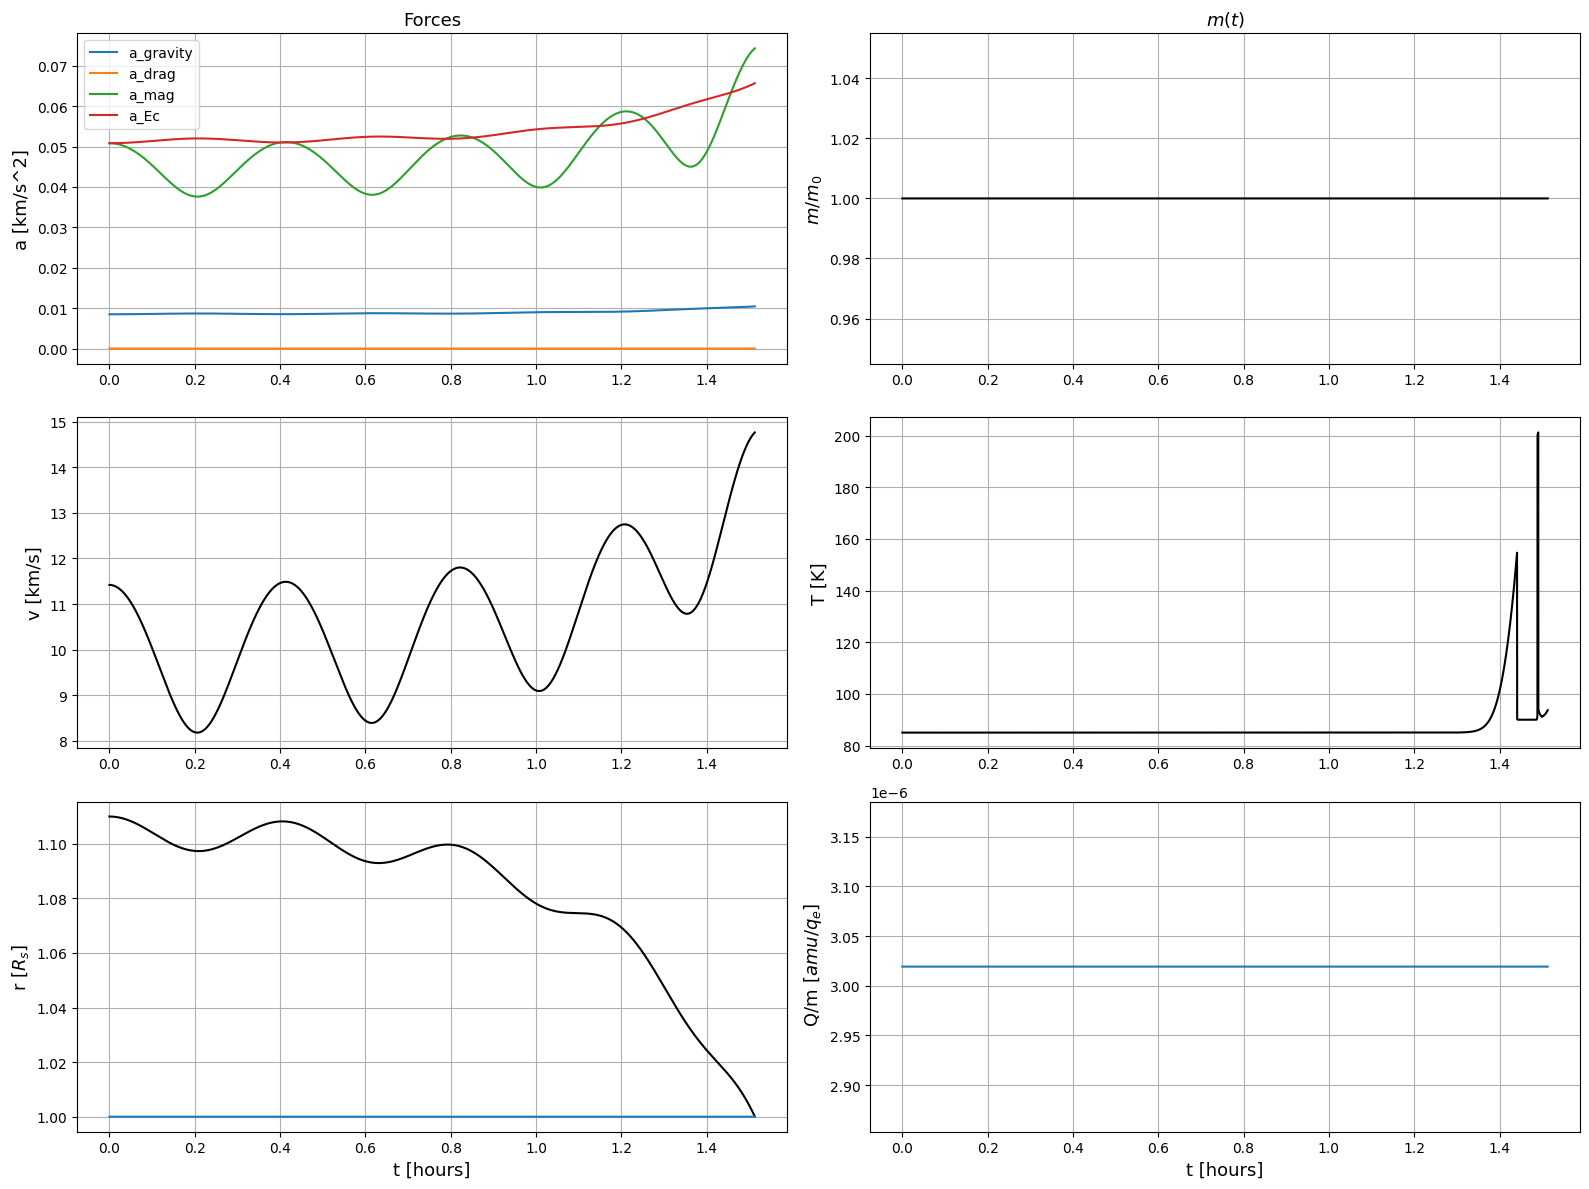

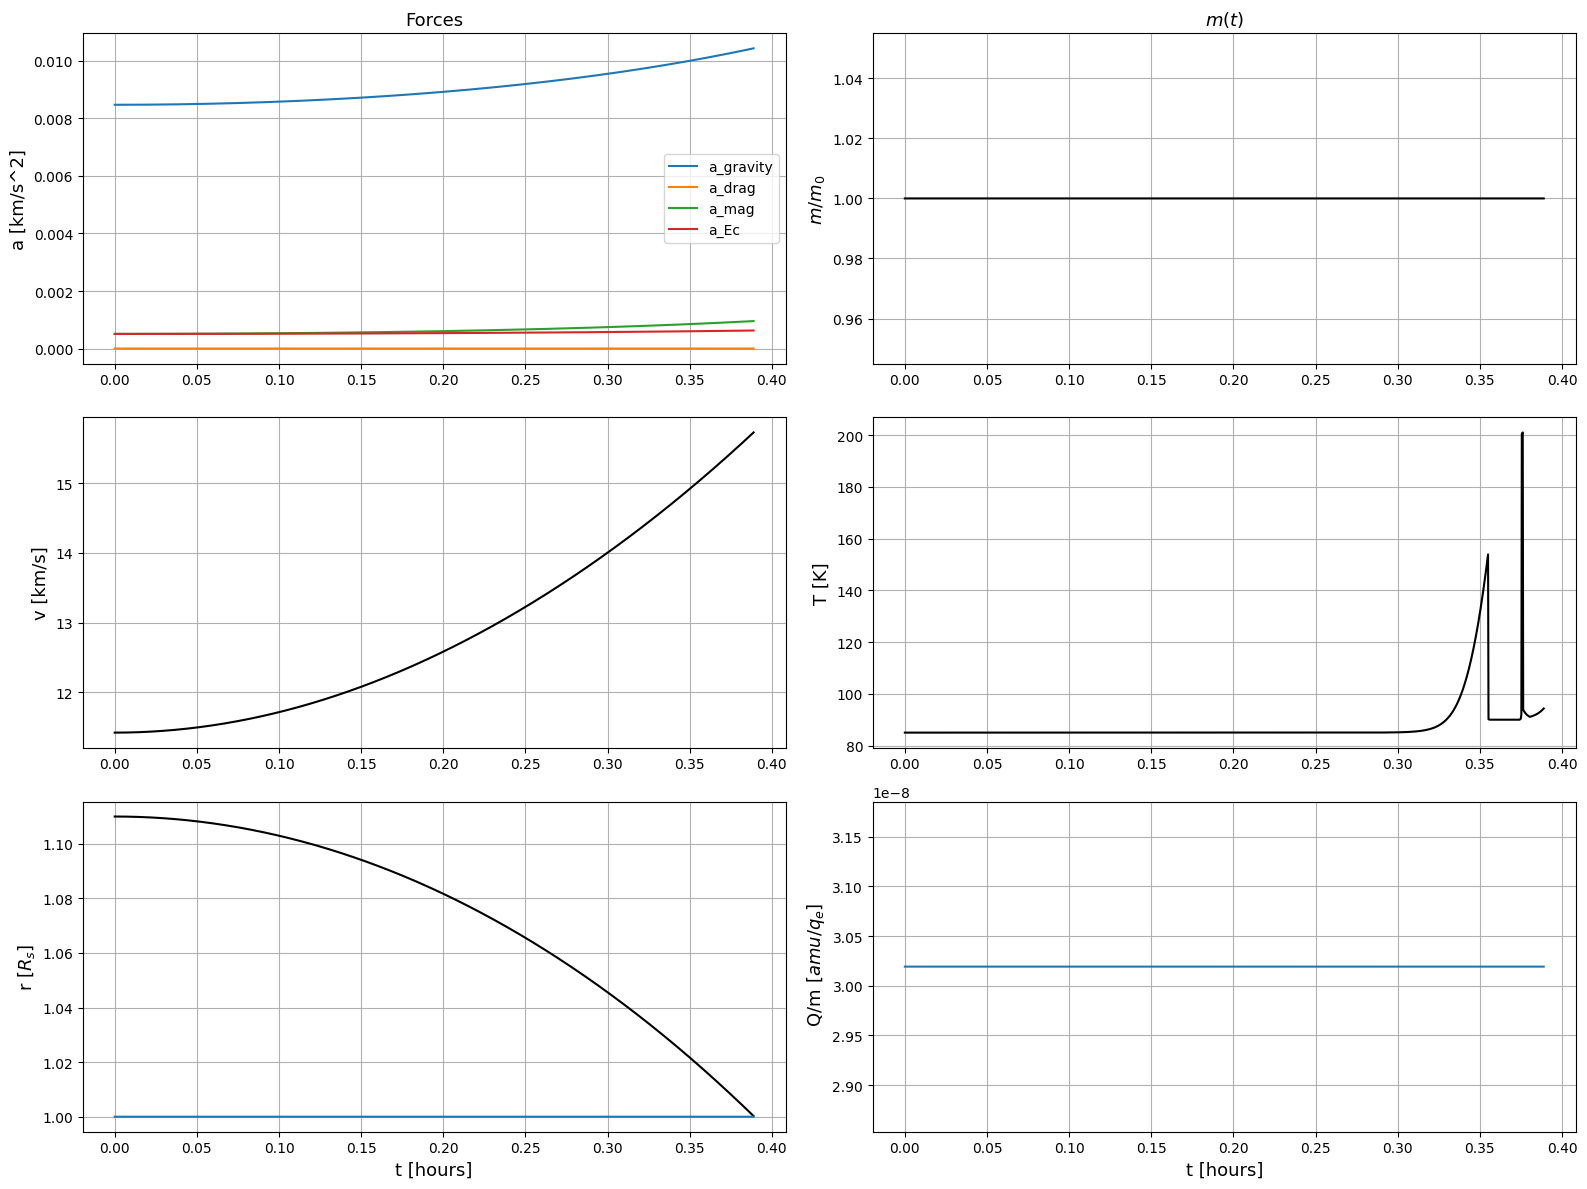

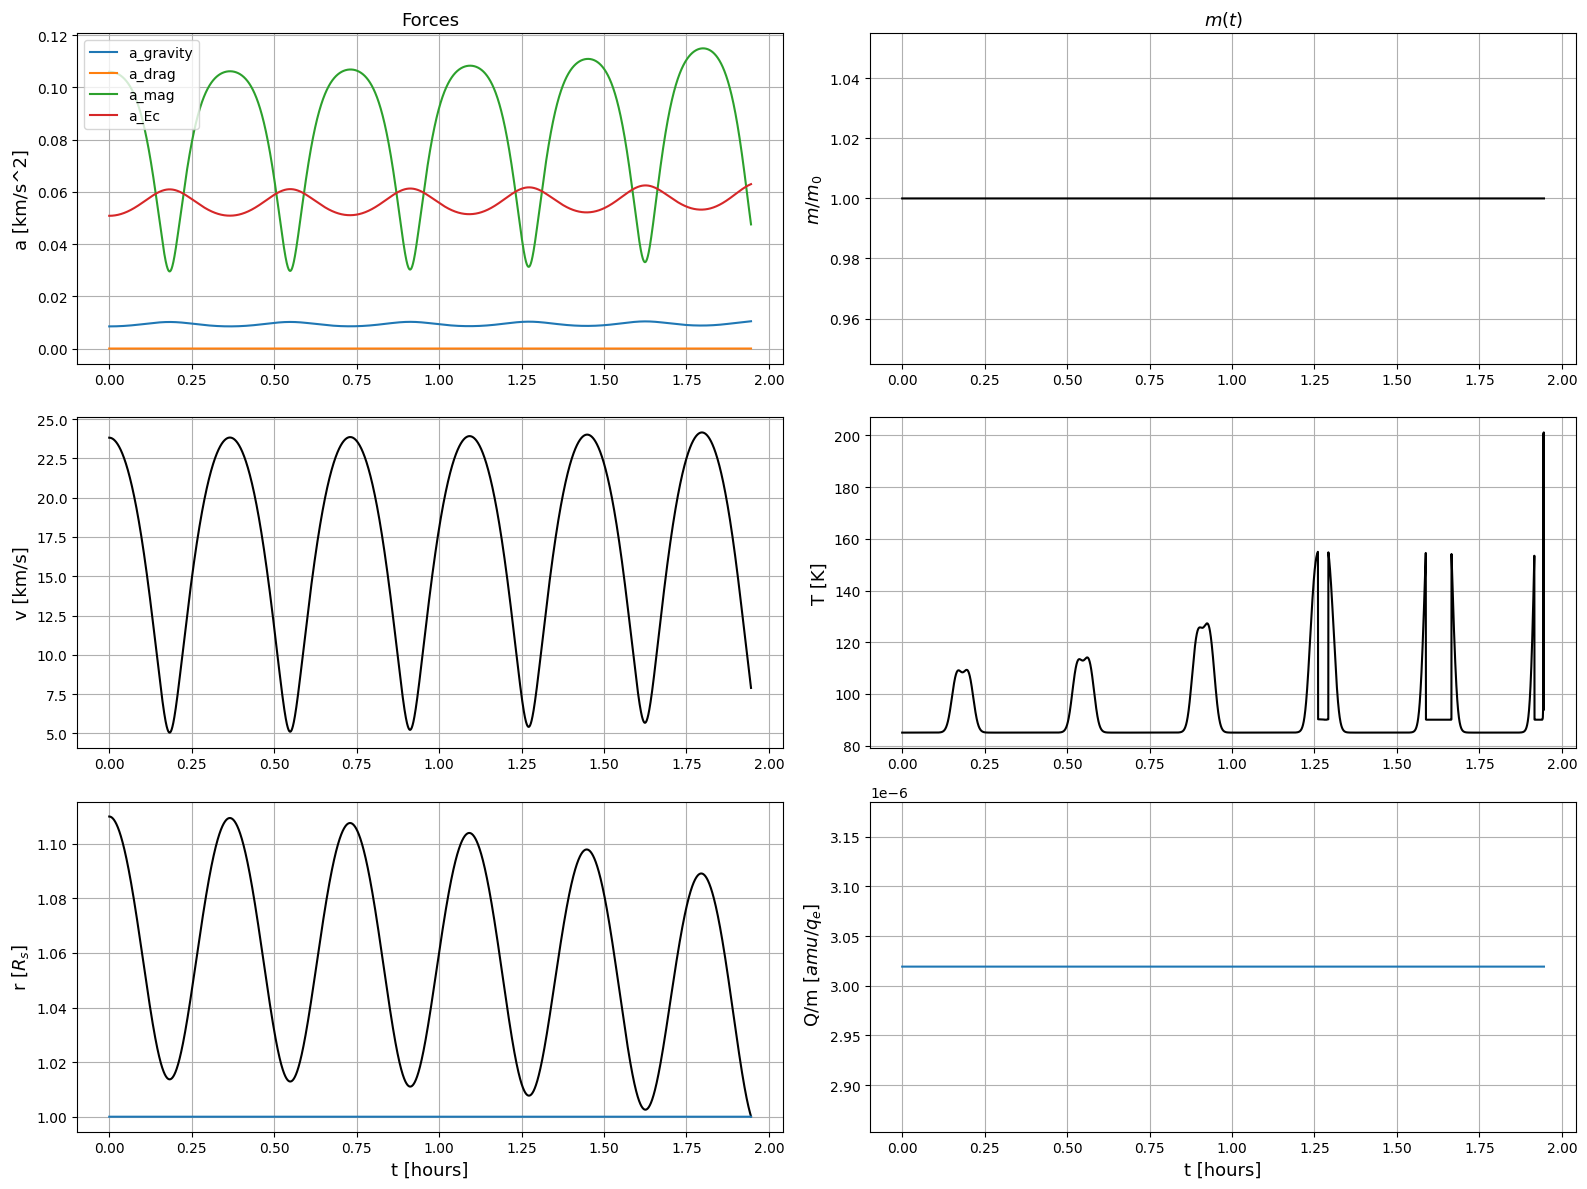

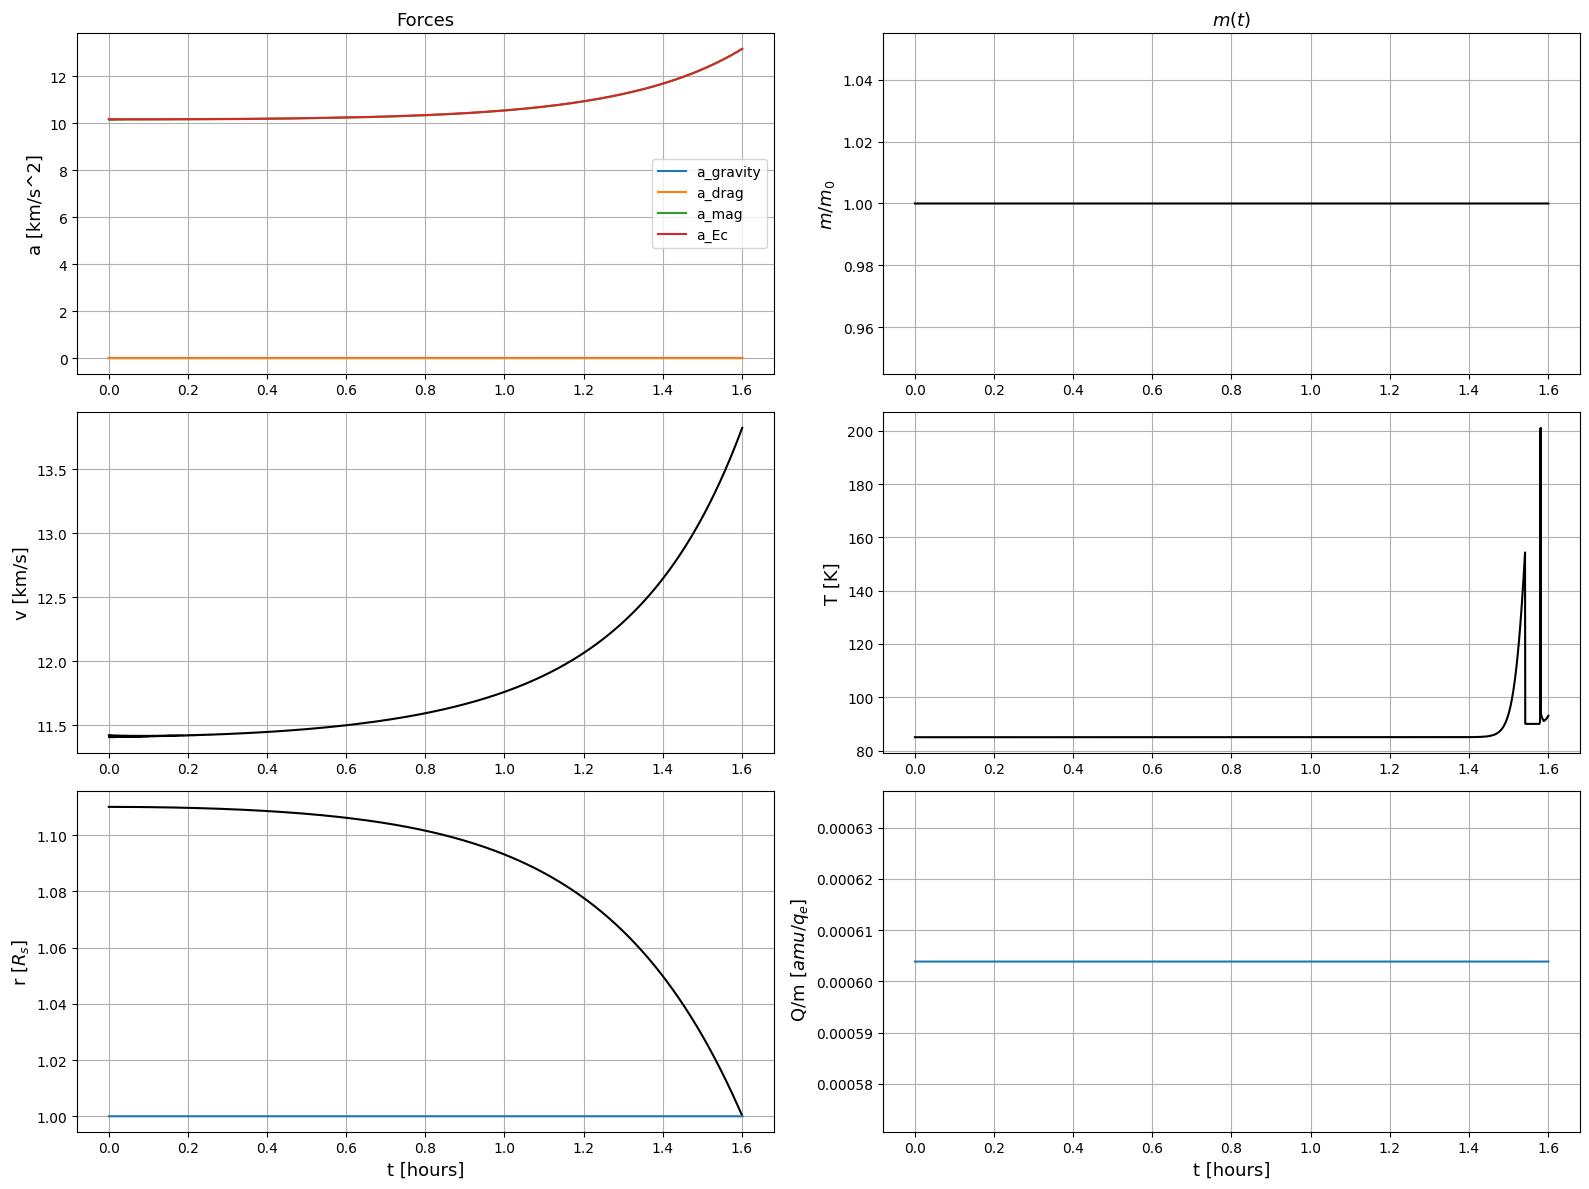

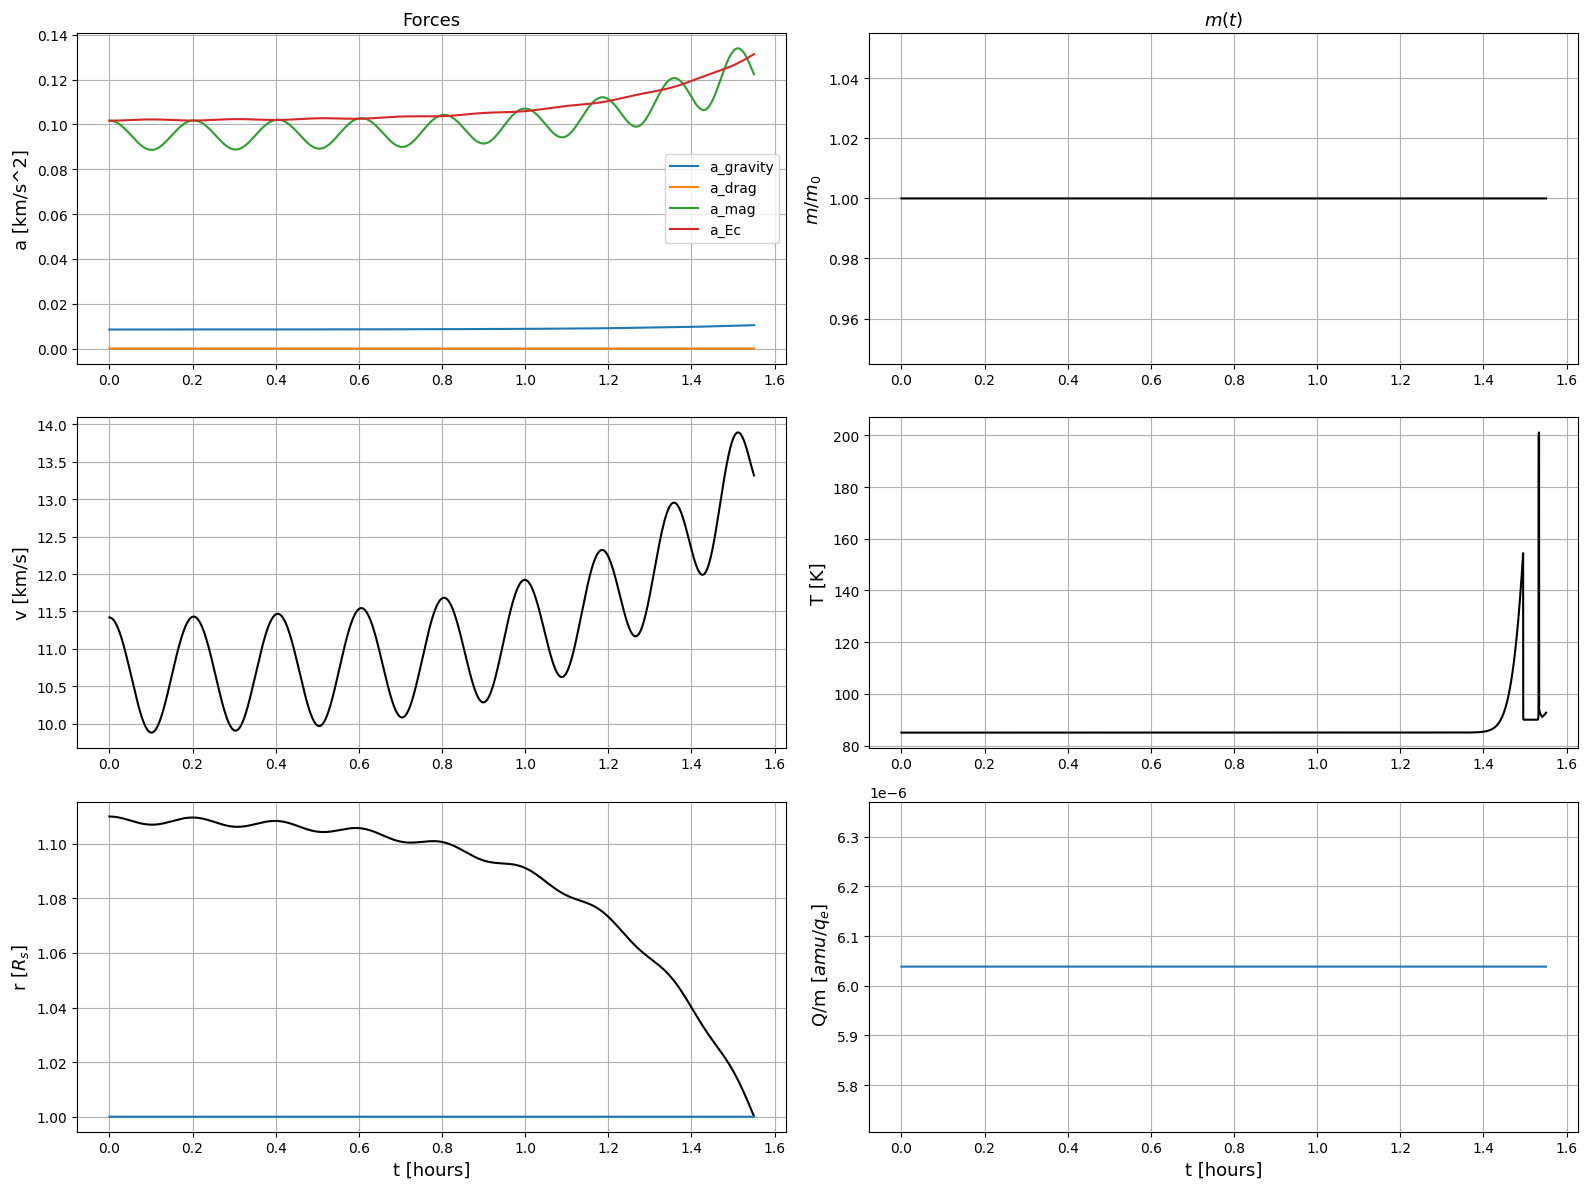

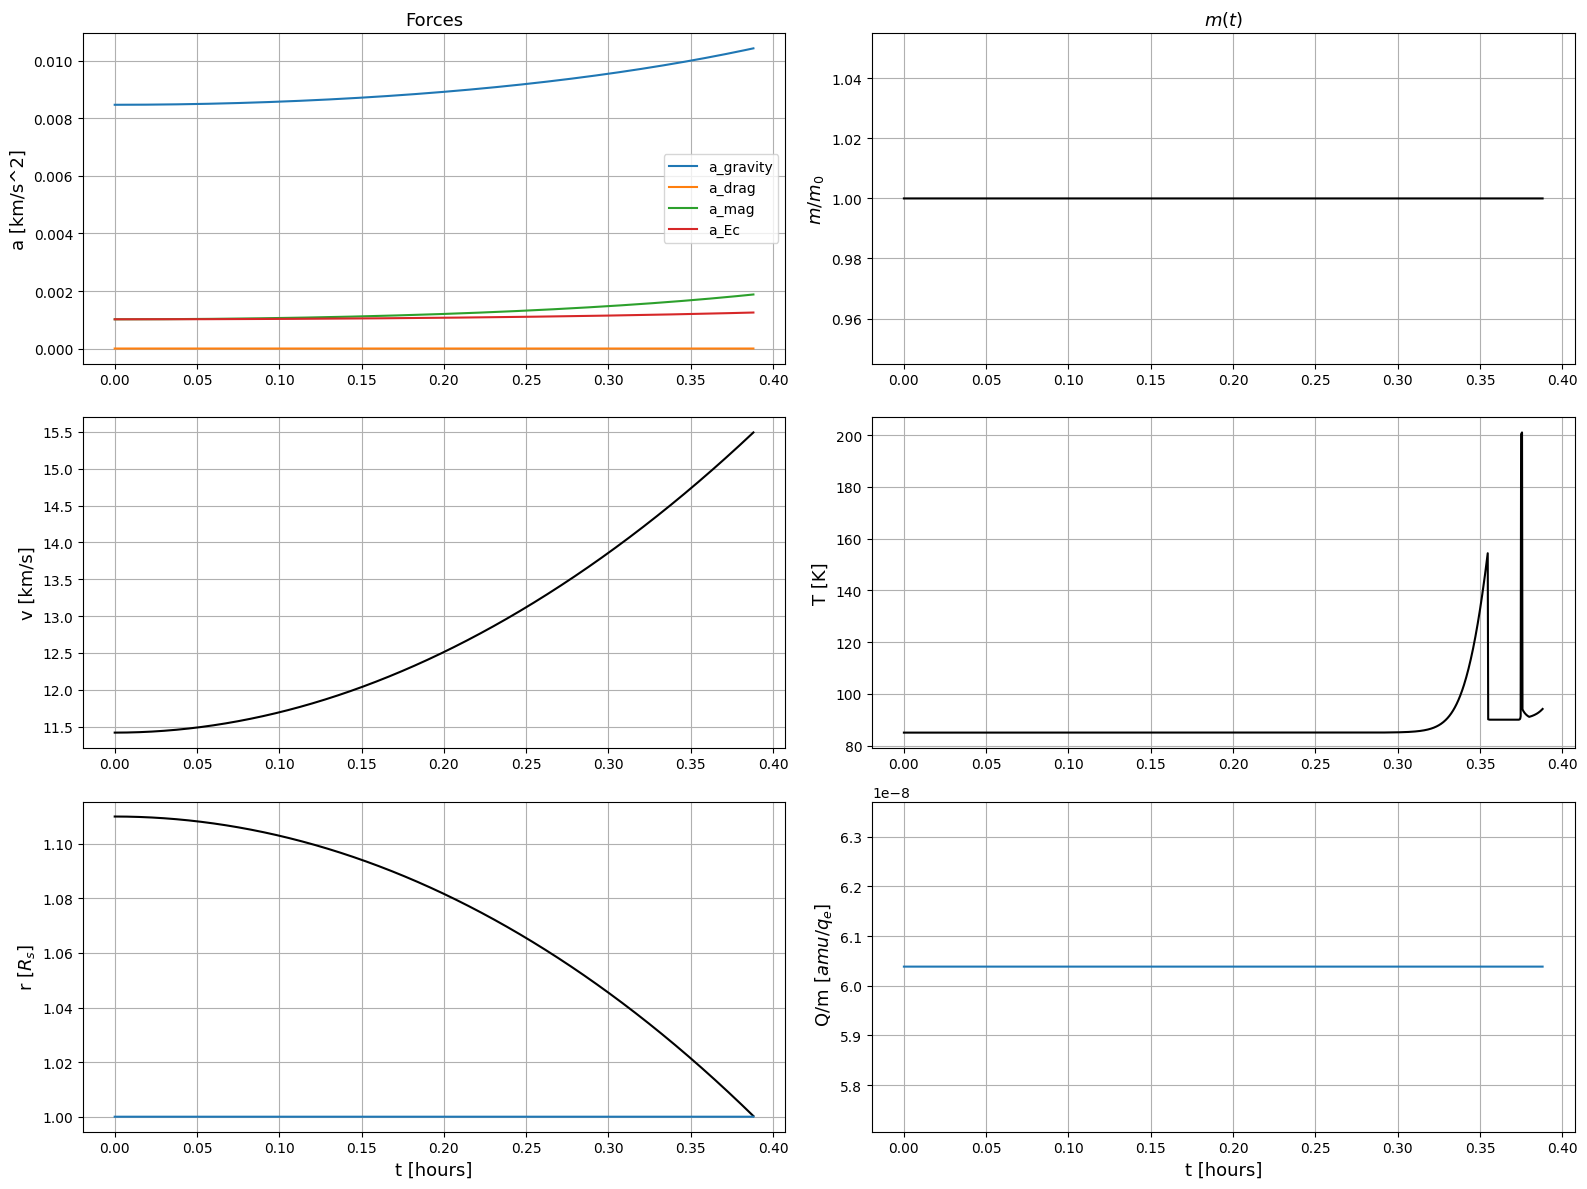

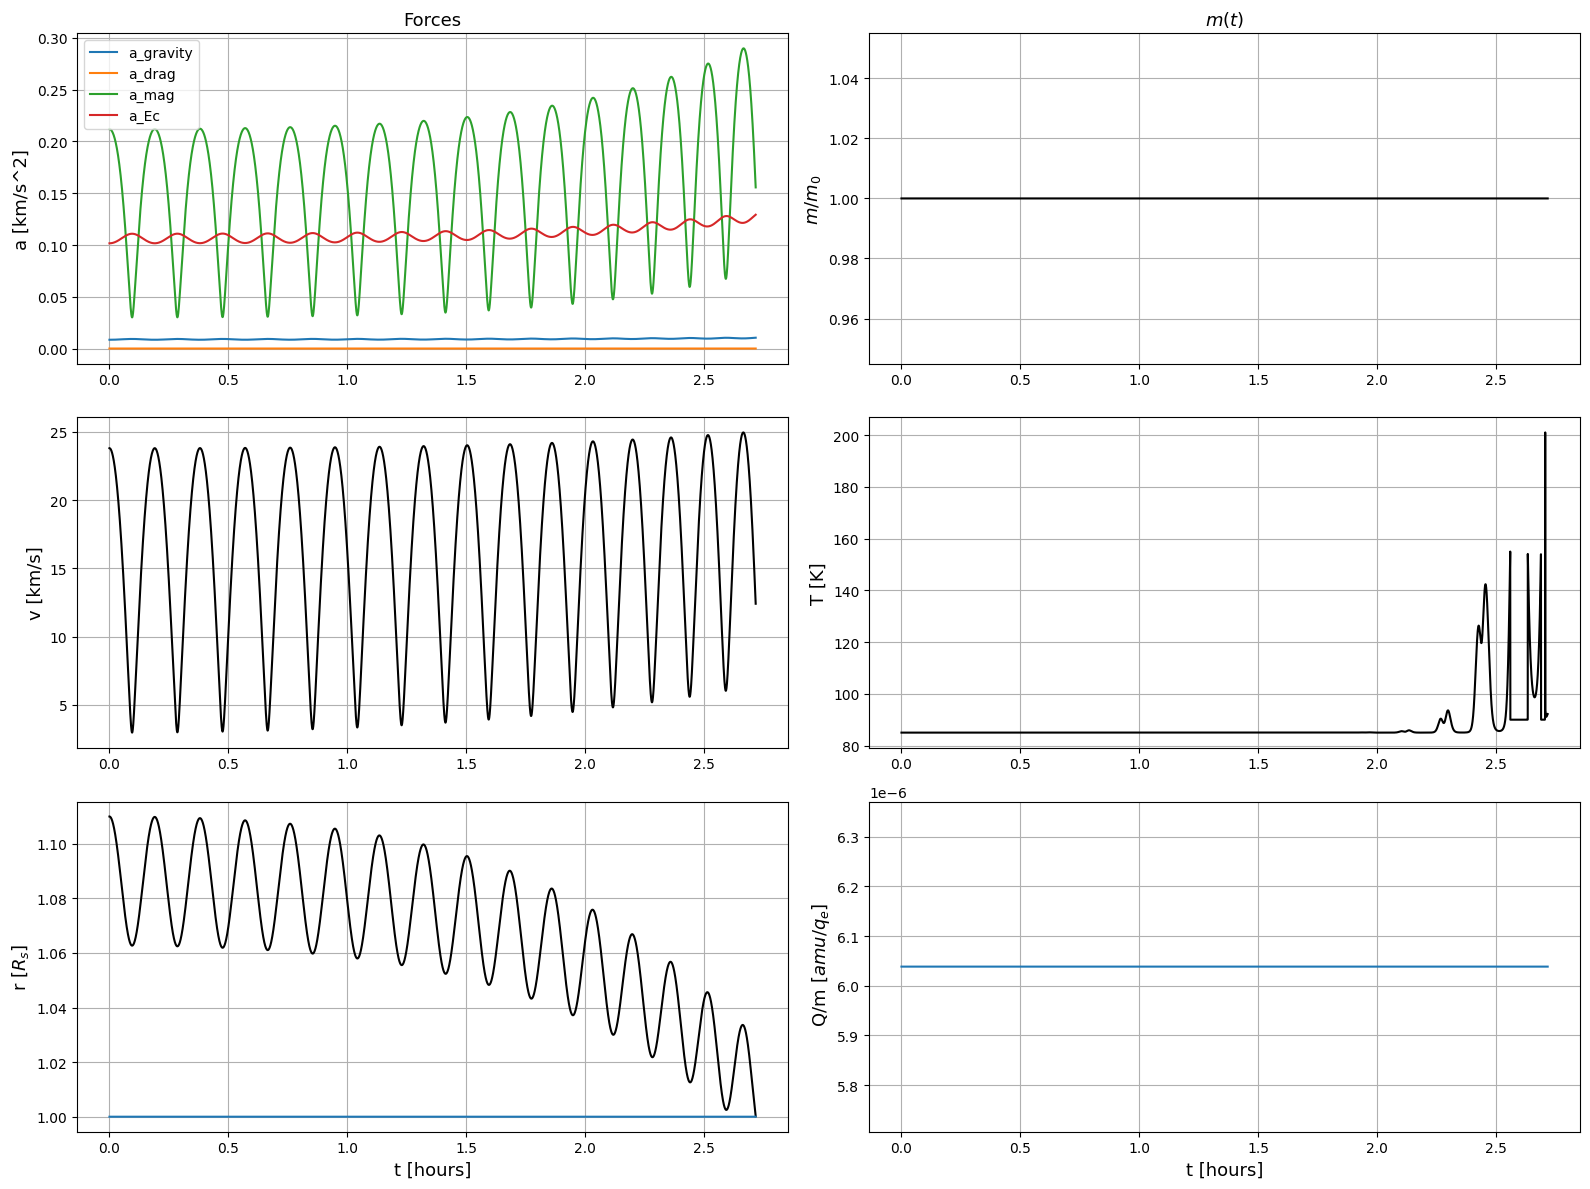

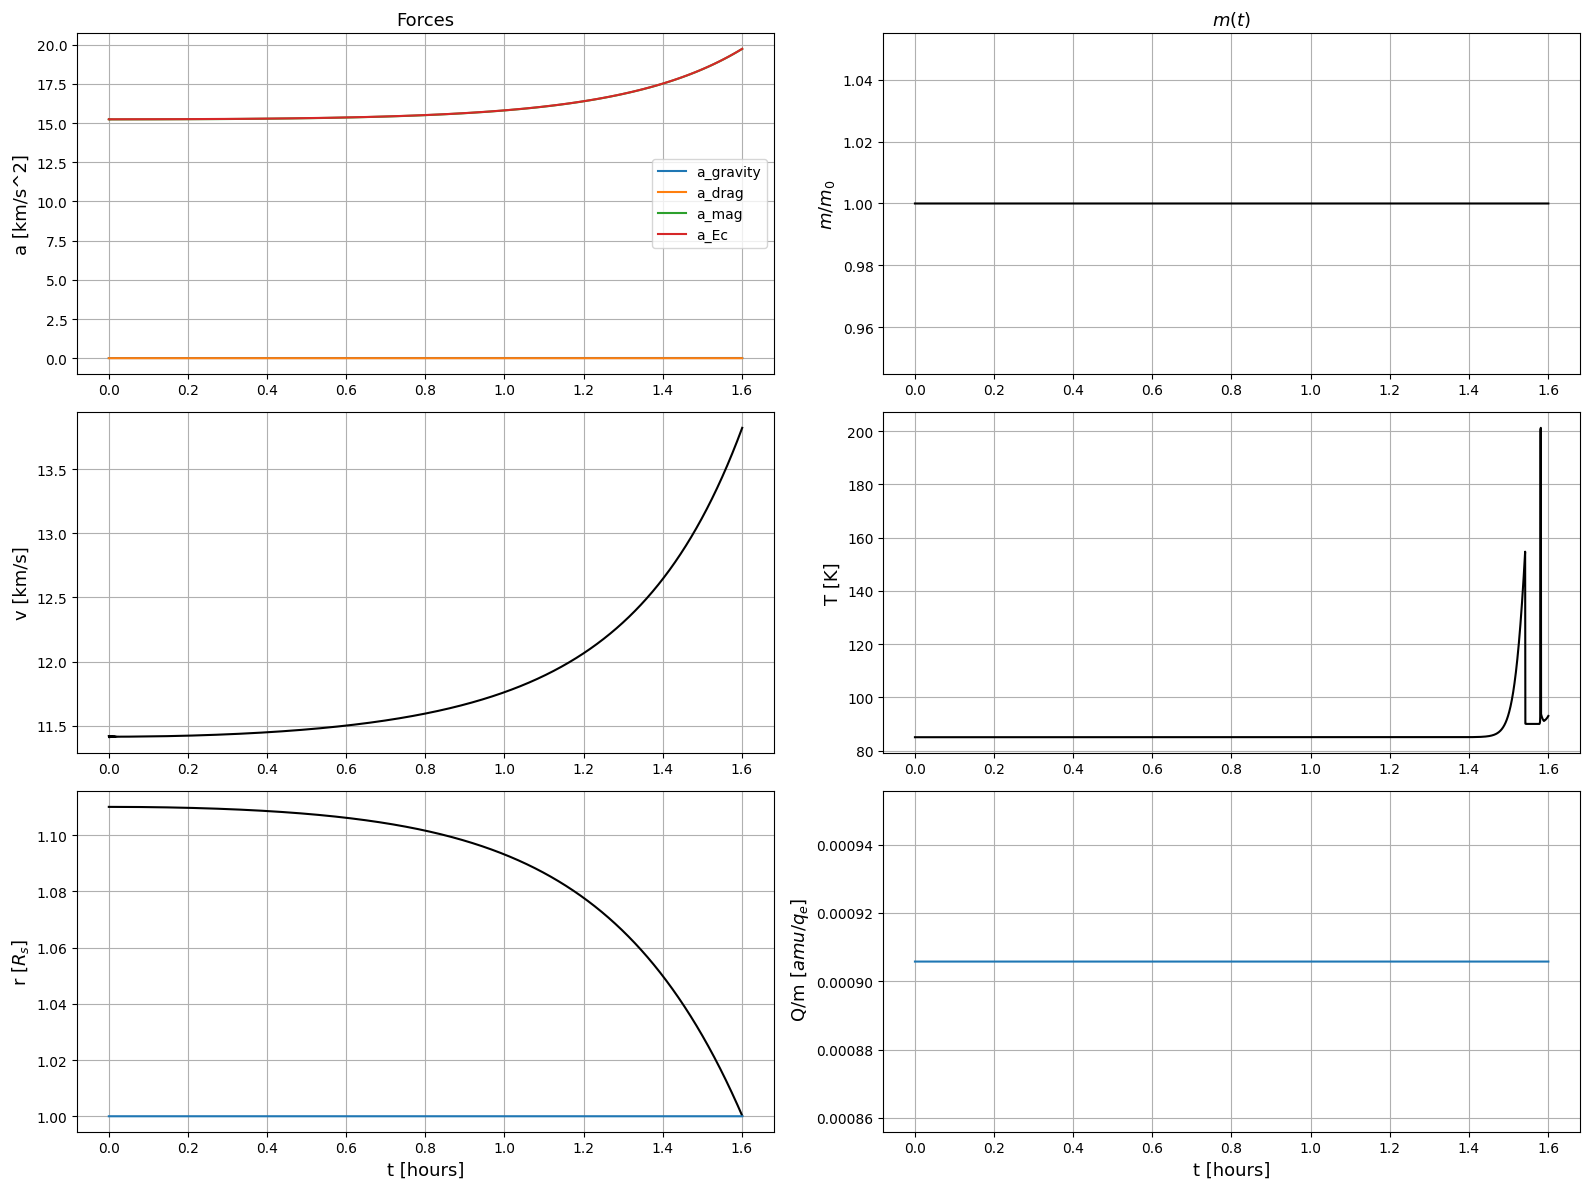

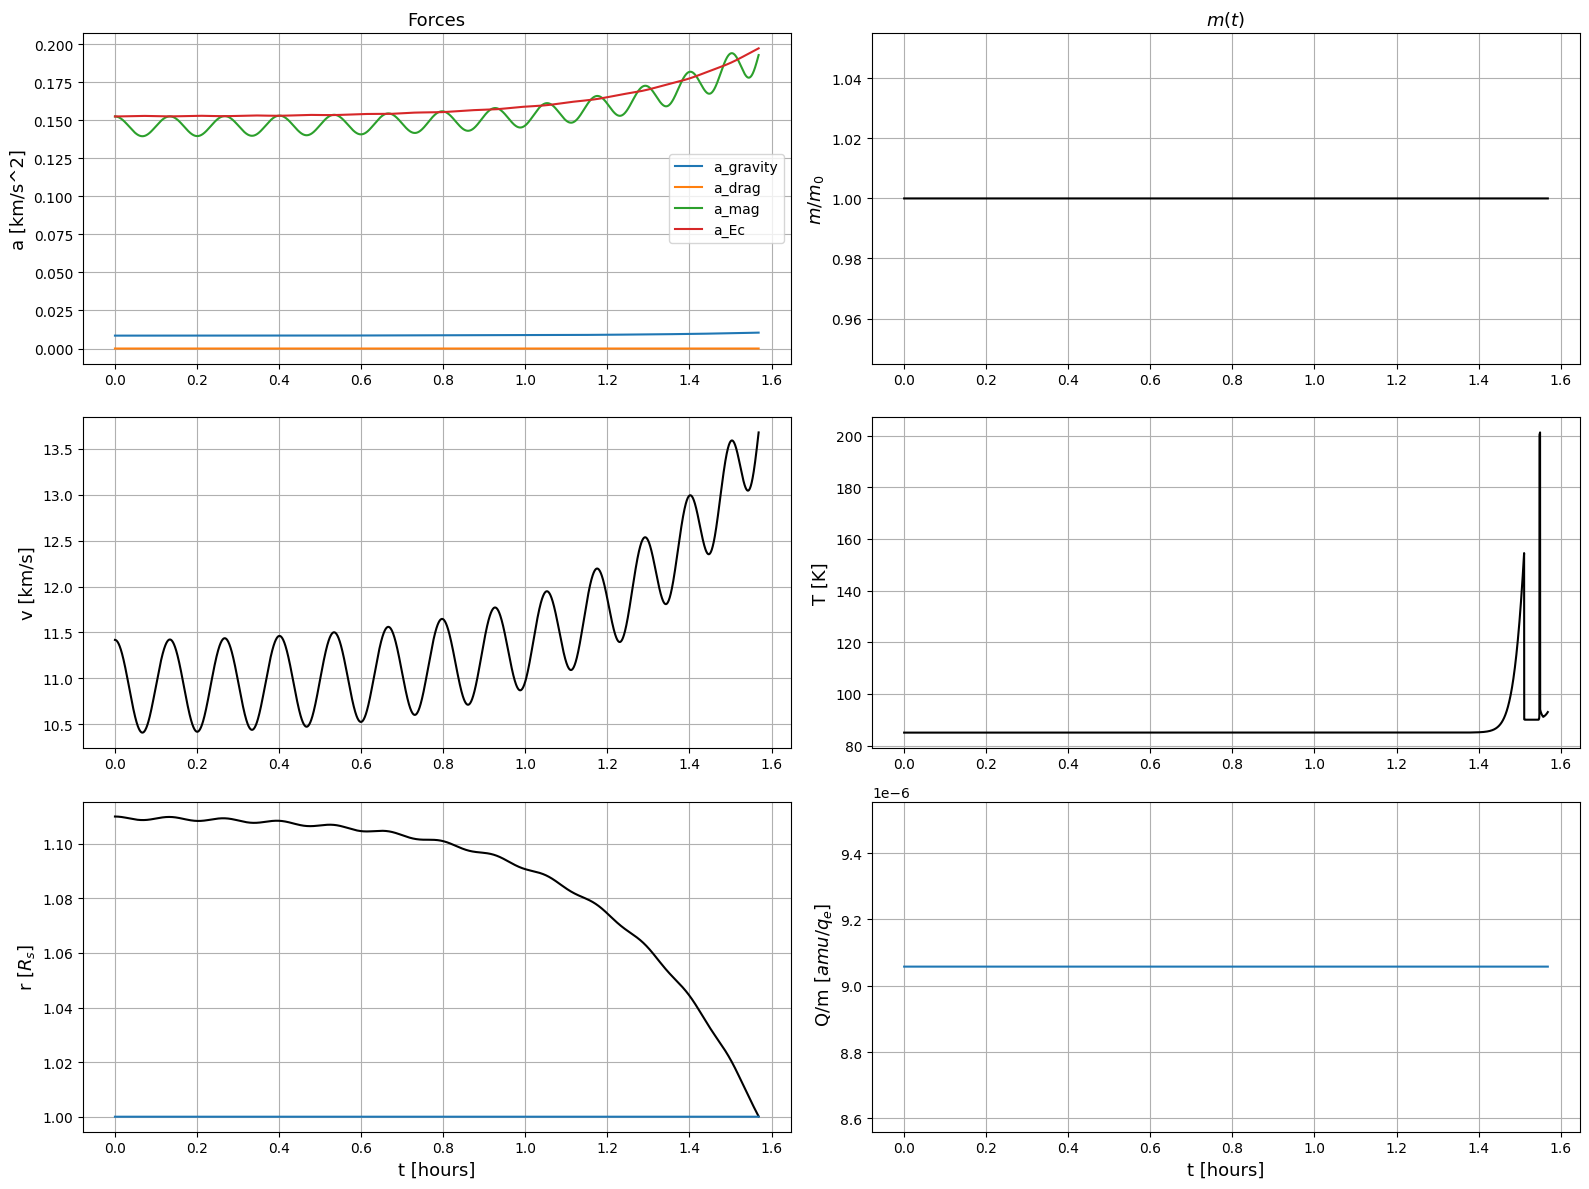

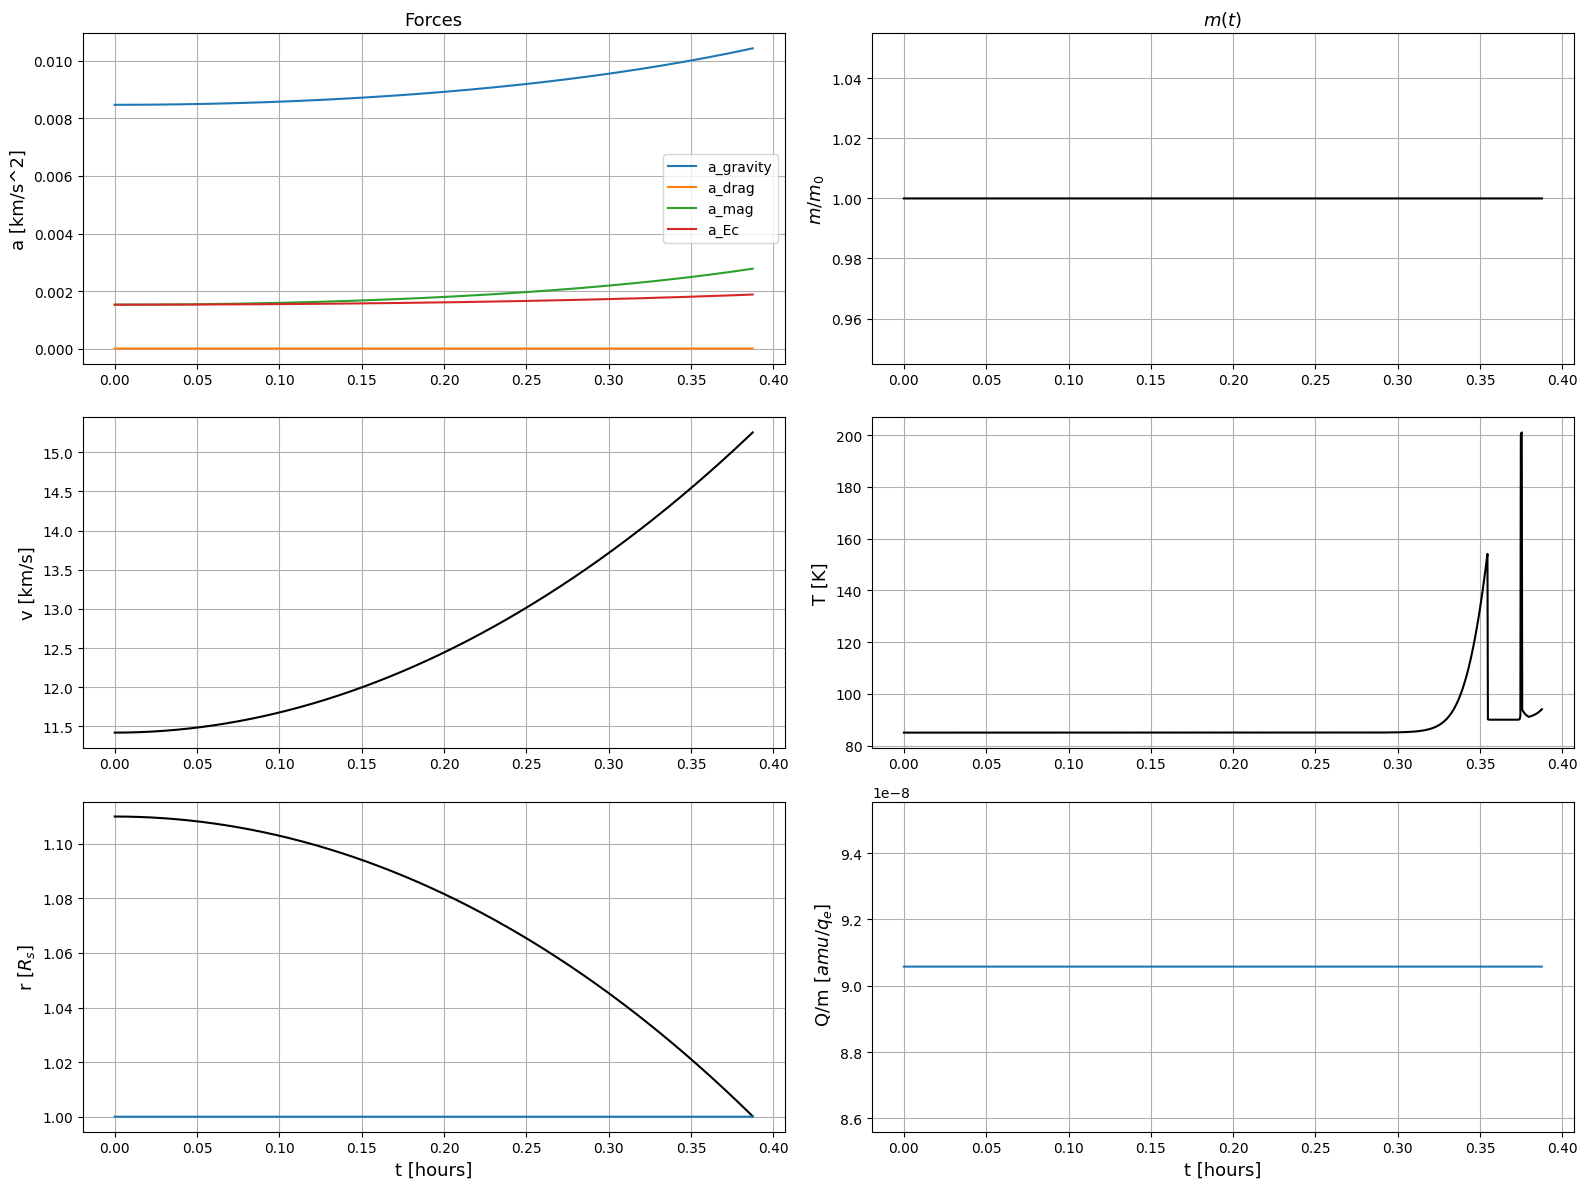

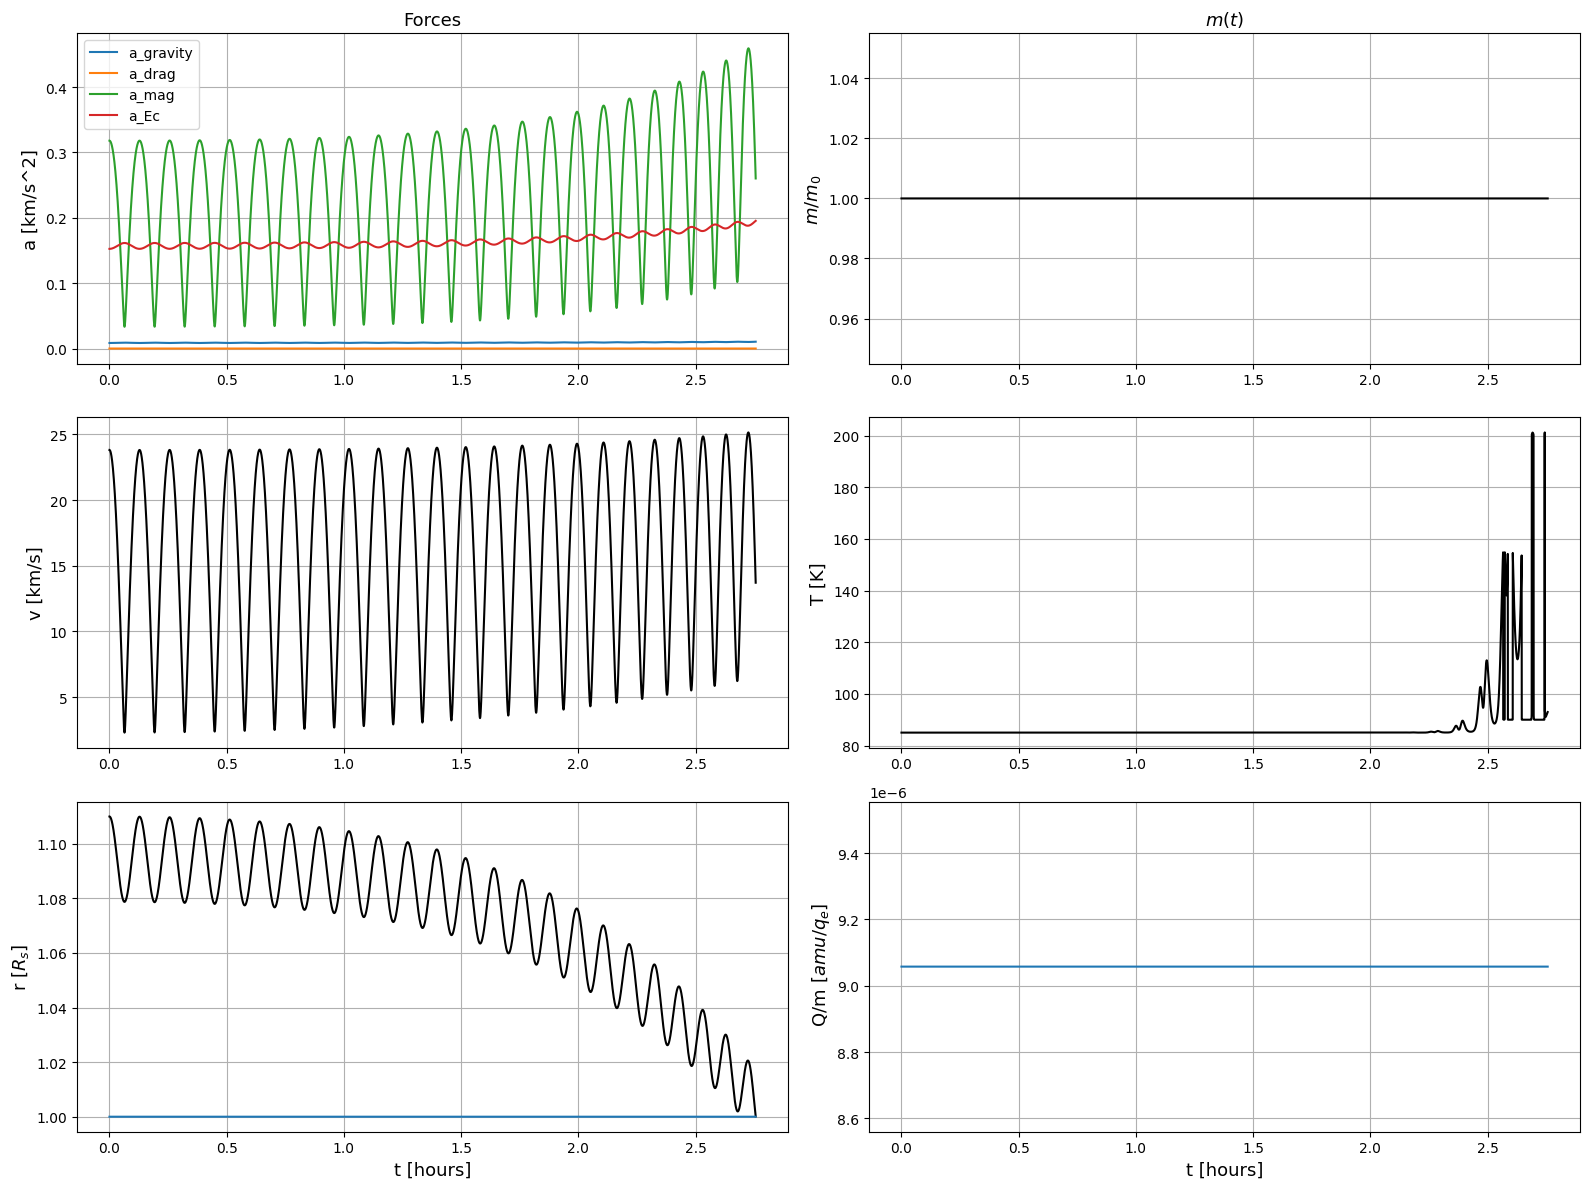

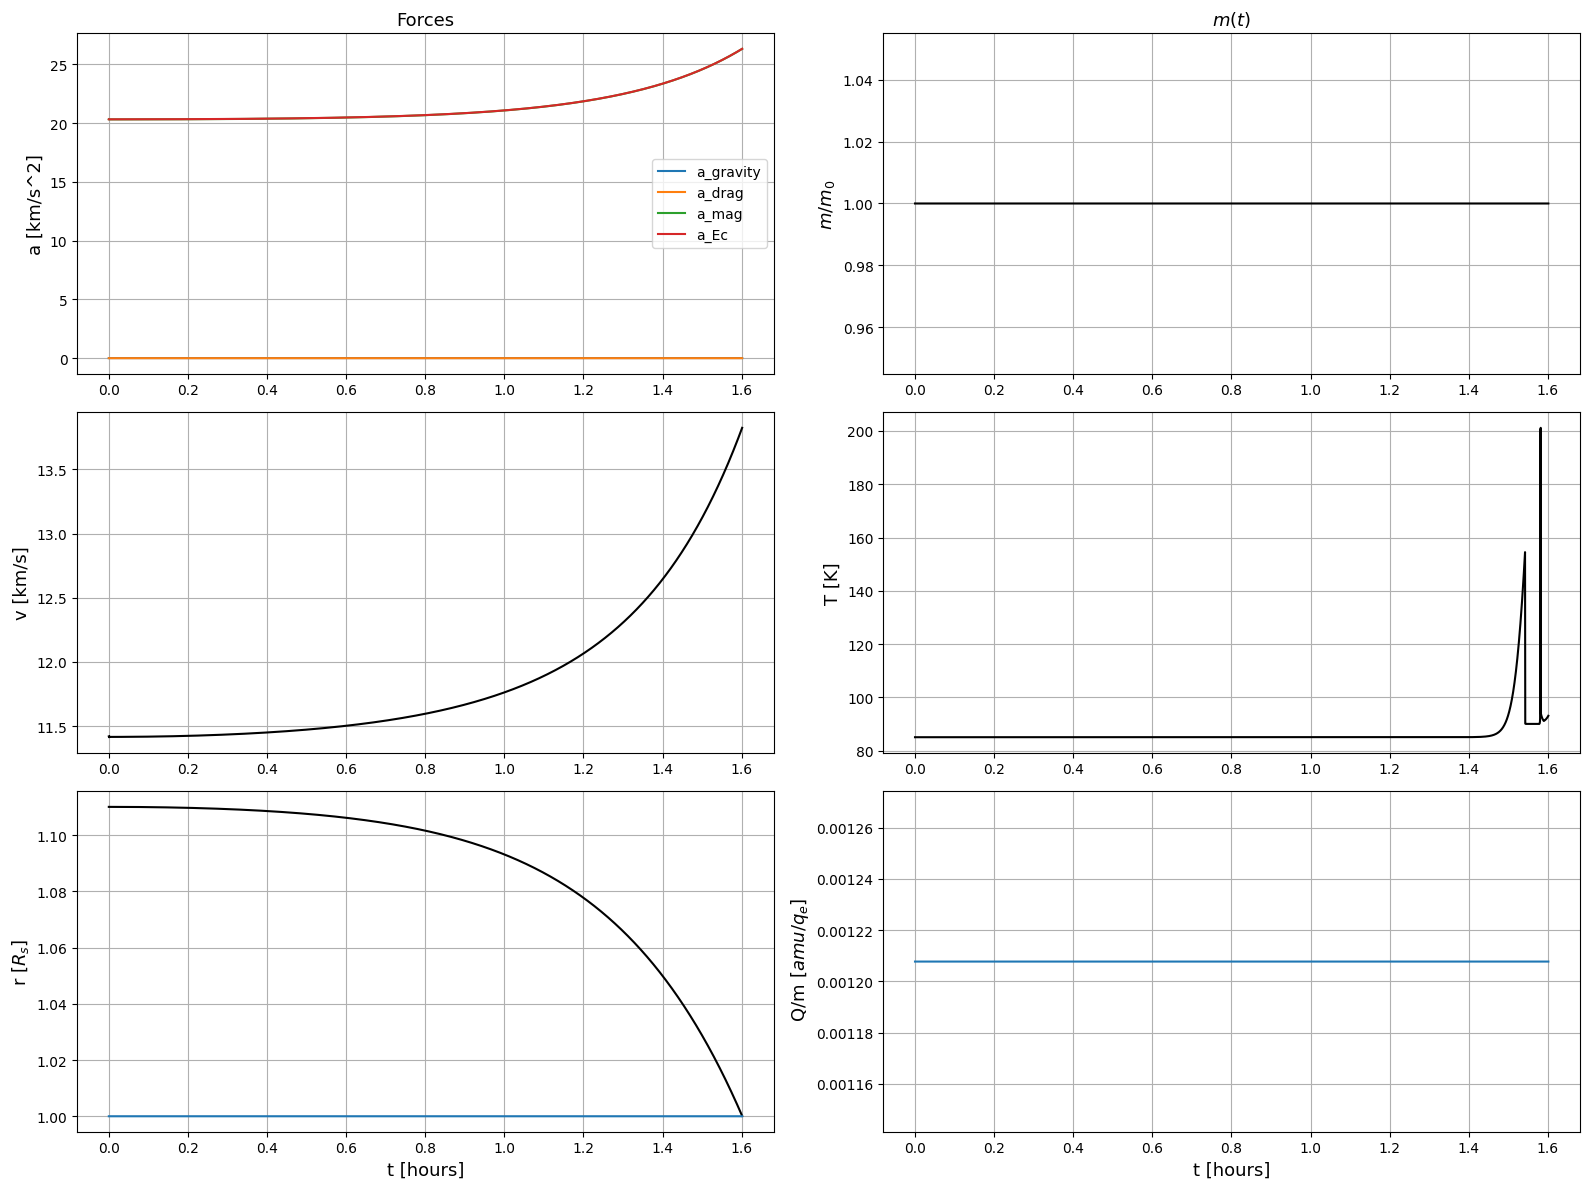

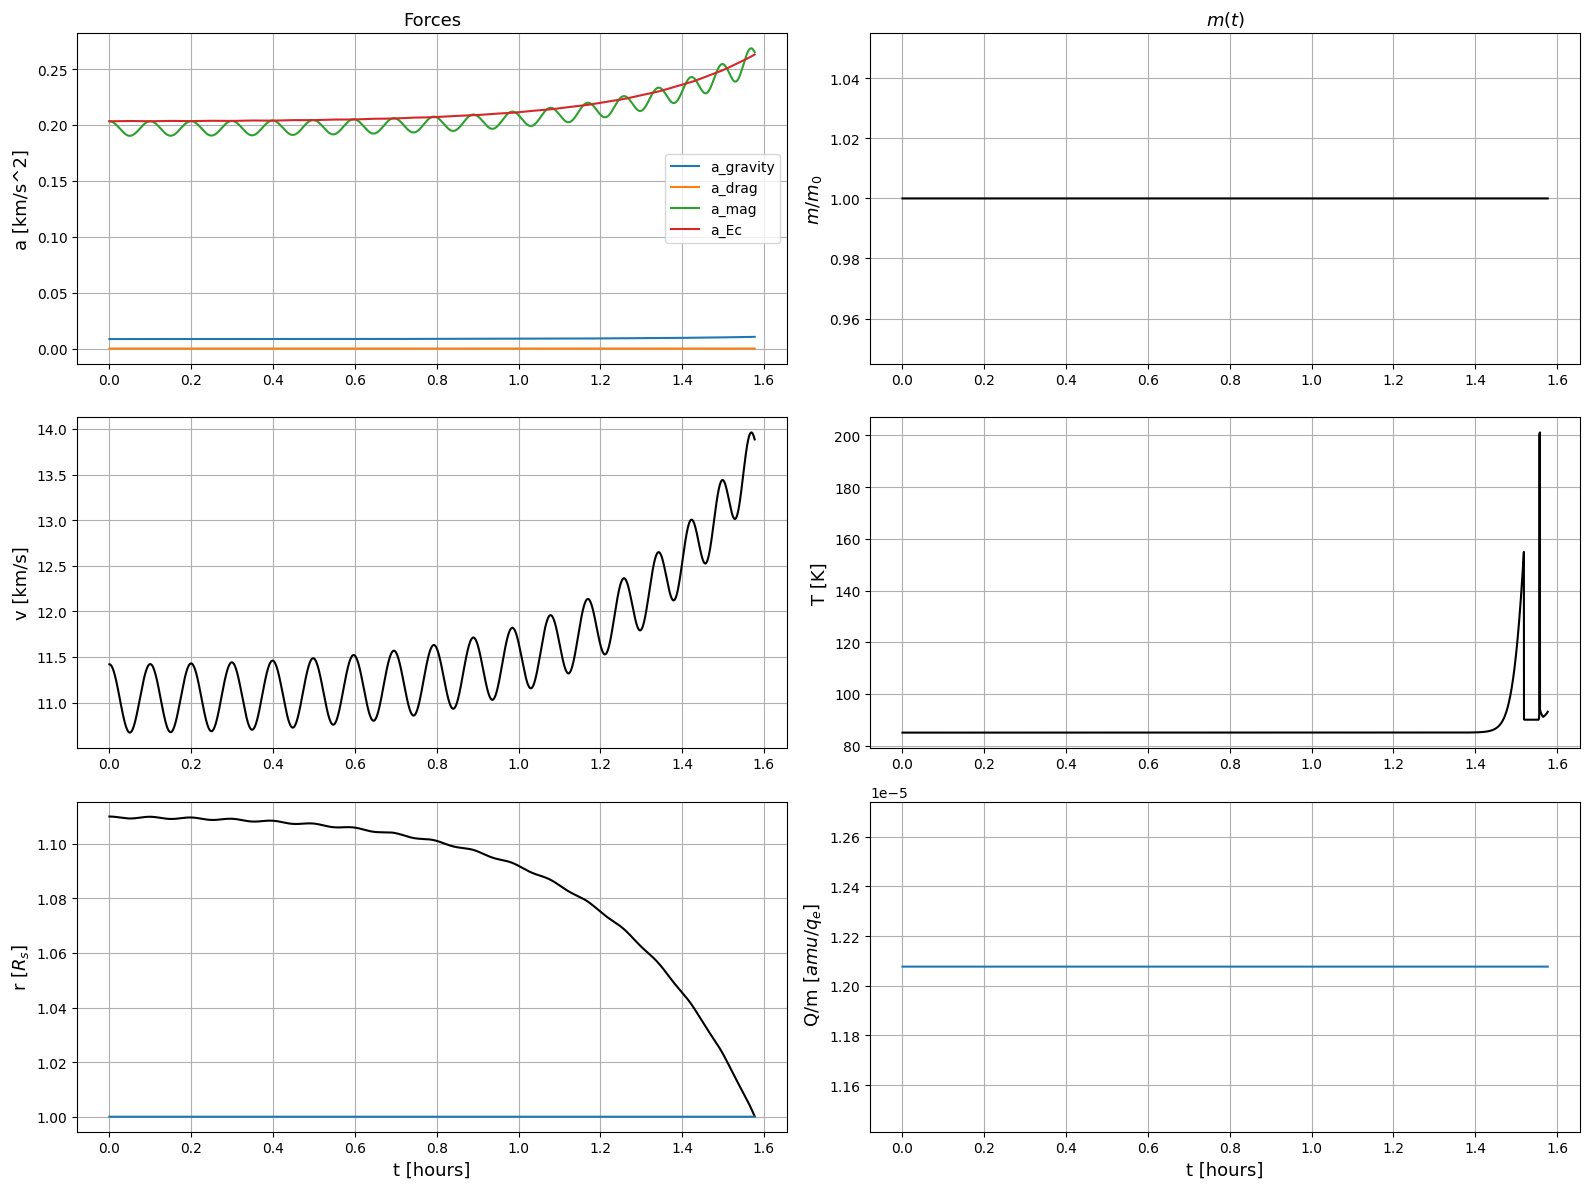

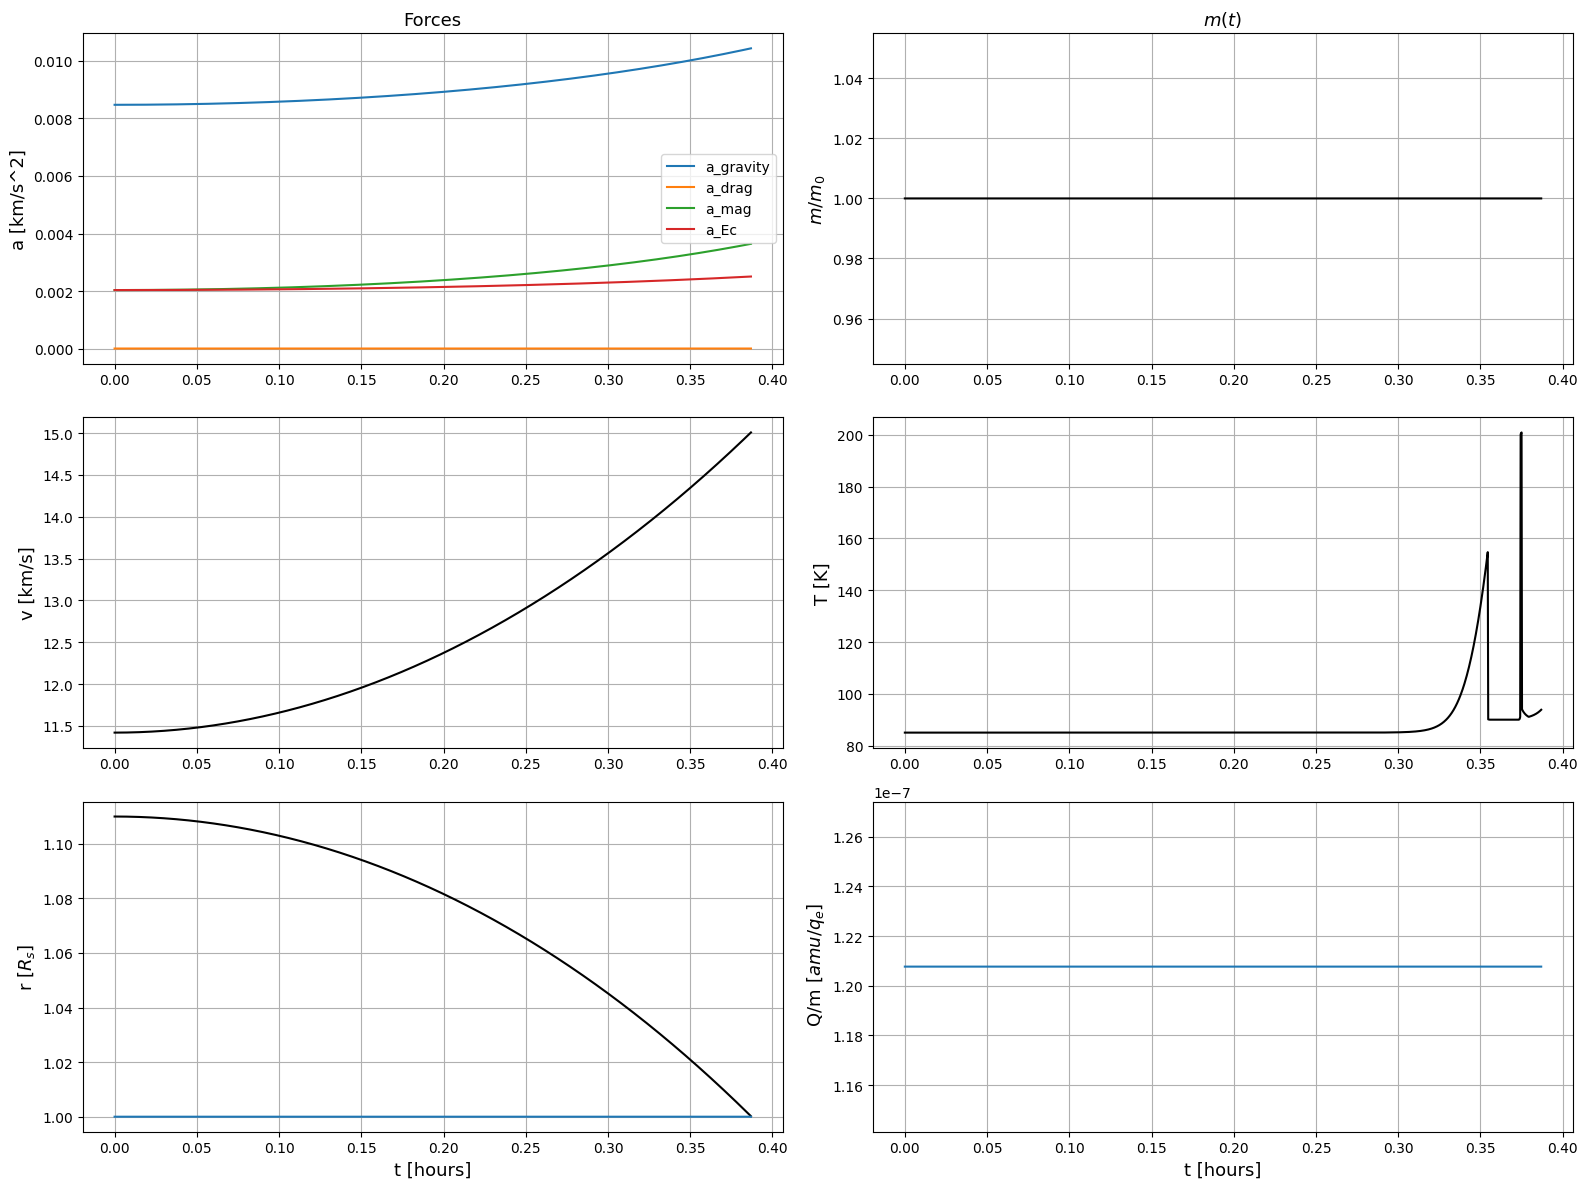

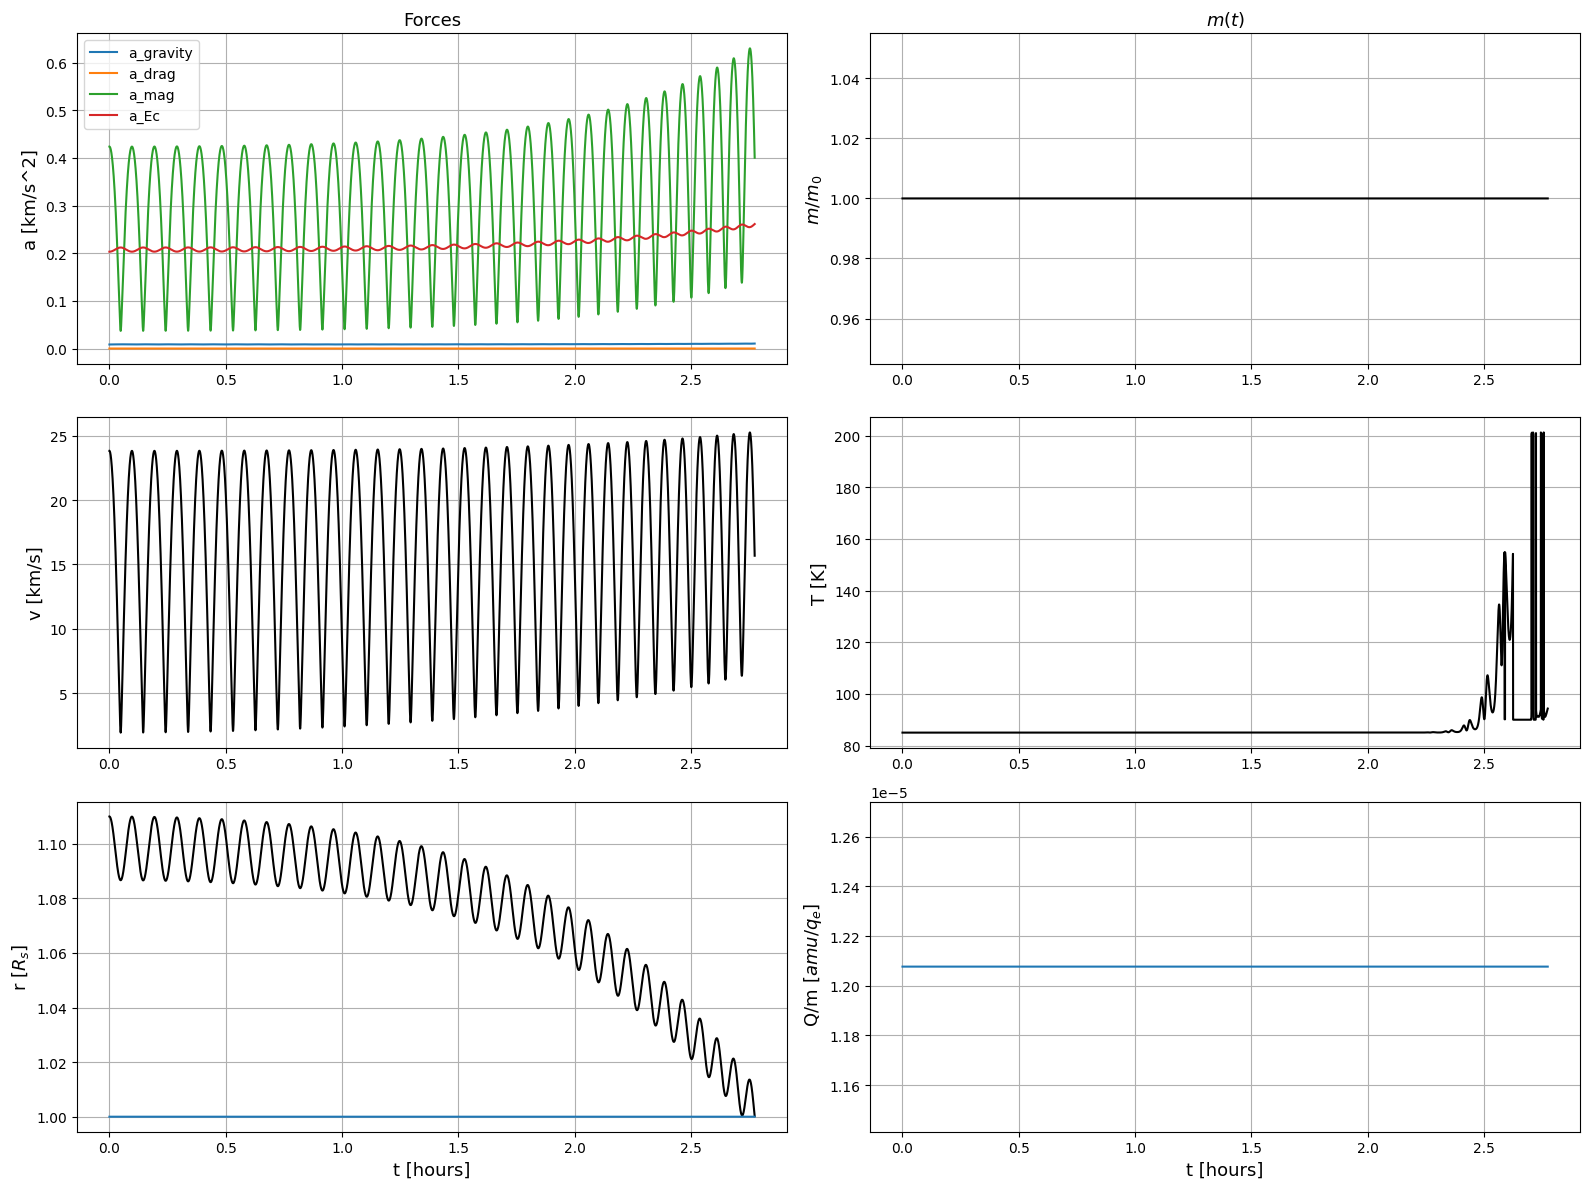

In [108]:
for U in U_plot:
    #fig_r, axs_r = plt.subplots(1,1, figsize=(10,10))
    if np.sign(U)<0:
        V_txt='U = m_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    elif np.sign(U)>0:
        V_txt='U = p_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    else:
        V_txt='drag_only_'
    
    for Rg0 in R_g0_plot:
        
        le=int(len(particle[U][Rg0]['r']))
        tt=np.linspace(0, particle[U][Rg0]['t_final'], le)/(60*60)
        gr_mag=particle[U][Rg0]['gr_mag']; drag_mag=particle[U][Rg0]['drag_mag']; mag_mag=particle[U][Rg0]['mag_mag']; Ec_mag=particle[U][Rg0]['Ec_mag']
        r=particle[U][Rg0]['r']; vtot=particle[U][Rg0]['vtot']; m=particle[U][Rg0]['m']; Q=particle[U][Rg0]['Q']; T=particle[U][Rg0]['T']
        
        fig, axs = plt.subplots(3, 2, figsize=(16,12))
        #fig.suptitle(V_txt +'Rg_0 = ' + str("{:.1f}".format(Rg0*1e9)) + ' nm')
        axs[0,0].plot(tt, gr_mag, label='a_gravity')
        axs[0,0].plot(tt, drag_mag, label='a_drag')
        axs[0,0].plot(tt, mag_mag, label='a_mag')
        axs[0,0].plot(tt, Ec_mag, label='a_Ec')
        axs[0,0].set_title('Forces', fontsize=13)
        axs[0,0].legend()
        axs[0,0].set_ylabel('a [km/s^2]', fontsize=13)
        axs[0,0].grid()
        
        axs[0,1].plot(tt, np.array(m)/particle[U][Rg0]['m0'], 'k')
        axs[0,1].set_title('$m(t)$', fontsize=13)
        axs[0,1].set_ylabel('$m/m_0$', fontsize=13)
        axs[0,1].grid()
        
        axs[1,0].plot(tt, vtot, 'k')
        axs[1,0].set_ylabel('v [km/s]', fontsize=13)
        axs[1,0].grid()
        
        axs[1,1].plot(tt, T, 'k')
        axs[1,1].set_ylabel('T [K]', fontsize=13)
        axs[1,1].grid()
        
        axs[2,0].plot(tt, np.array(r)/Rs, 'k')
        axs[2,0].set_ylabel('r [$R_s$]', fontsize=13)
        axs[2,0].plot(tt, np.linspace(1, 1,len(r)))
        axs[2,0].set_xlabel('t [hours]', fontsize=13)
        axs[2,0].grid()
        
        axs[2,1].plot(tt, np.array(Q)/np.array(m) * (amu/q_e))
        axs[2,1].set_ylabel(' Q/m [$amu/q_e$]', fontsize=13)
        axs[2,1].set_xlabel('t [hours]', fontsize=13)
        axs[2,1].grid()
        fig.tight_layout()
        fig.savefig('results_time_'+V_txt+str(int(Rg0*1e9))+' nm & '+particle[U][Rg0]['v0_txt'], dpi='figure')
        if V_txt=='drag_only_':
            
            fig, axs = plt.subplots(6, 1, figsize=(16,12))
            #fig.suptitle('Force components: '+V_txt + 'Rg_0 = ' + str("{:.1f}".format(Rg0*1e9)) + ' nm')
            gr_x=[]; gr_y=[]; gr_z=[]; dr_x=[]; dr_y=[]; dr_z=[]; mag_x=[]; mag_y=[]; mag_z=[]; Ec_x=[]; Ec_y=[]; Ec_z=[]
            for i in range(le):

                gr_x.append(particle[U][Rg0]['a_gr'][i][0]); gr_y.append(particle[U][Rg0]['a_gr'][i][1]); gr_z.append(particle[U][Rg0]['a_gr'][i][2]);
                dr_x.append(particle[U][Rg0]['a_drag'][i][0]); dr_y.append(particle[U][Rg0]['a_drag'][i][1]); dr_z.append(particle[U][Rg0]['a_drag'][i][2]);
                mag_x.append(particle[U][Rg0]['a_mag'][i][0]); mag_y.append(particle[U][Rg0]['a_mag'][i][1]); mag_z.append(particle[U][Rg0]['a_mag'][i][2]);
                Ec_x.append(particle[U][Rg0]['a_Ec'][i][0]); Ec_y.append(particle[U][Rg0]['a_Ec'][i][1]); Ec_z.append(particle[U][Rg0]['a_Ec'][i][2]); 

            axs[0].plot(tt, gr_x, label='gr_x')
            axs[0].plot(tt, dr_x, label='dr_x')
            axs[0].plot(tt, mag_x, label='mag_x')
            axs[0].plot(tt, Ec_x, label='Ec_x')
            axs[0].set_ylabel('a_x [$km/s^2$]', fontsize=13)
            axs[0].set_title('x-components', fontsize=13)
            axs[0].grid()
            axs[0].legend()

            axs[1].plot(tt, np.array(particle[U][Rg0]['vx'])*1e-3)
           # axs[1].set_ylim([-16,16])
            axs[1].set_ylabel('v_x [km/s]', fontsize=13)
            axs[1].grid()

            axs[2].plot(tt, gr_y, label='gr_y')
            axs[2].plot(tt, dr_y, label='dr_y')
            axs[2].plot(tt, mag_y, label='mag_y')
            axs[2].plot(tt, Ec_y, label='Ec_y')
            axs[2].set_ylabel('a_y [$km/s^2$]', fontsize=13)
            axs[2].set_title('y-components', fontsize=13)
            axs[2].grid()
            axs[2].legend(loc='upper right')

            axs[3].plot(tt, np.array(particle[U][Rg0]['vy'])*1e-3)
            axs[3].grid()
           # axs[3].set_ylim([-16,16])
            axs[3].set_ylabel('v_y [$km/s$]', fontsize=13)

            axs[4].plot(tt, gr_z, label='gr_z')
            axs[4].plot(tt, dr_z, label='dr_z')
            axs[4].plot(tt, mag_z, label='mag_z')
            axs[4].plot(tt, Ec_z, label='Ec_z')
            axs[4].set_ylabel('a_z [$km/s^2$]', fontsize=13)
            axs[4].set_title('z-components', fontsize=13)
            axs[4].grid()
            axs[4].legend()

            axs[5].plot(tt, np.array(particle[U][Rg0]['vz'])*1e-3)
            axs[5].grid()
            #axs[5].set_ylim([-16,16])
            axs[5].set_ylabel('v_z [$km/s$]', fontsize=13)
            fig.tight_layout()
            fig.savefig('force_components_time_' +V_txt+str(int(Rg0*1e9))+' nm & '+particle[U][Rg0]['v0_txt'], dpi='figure')
            


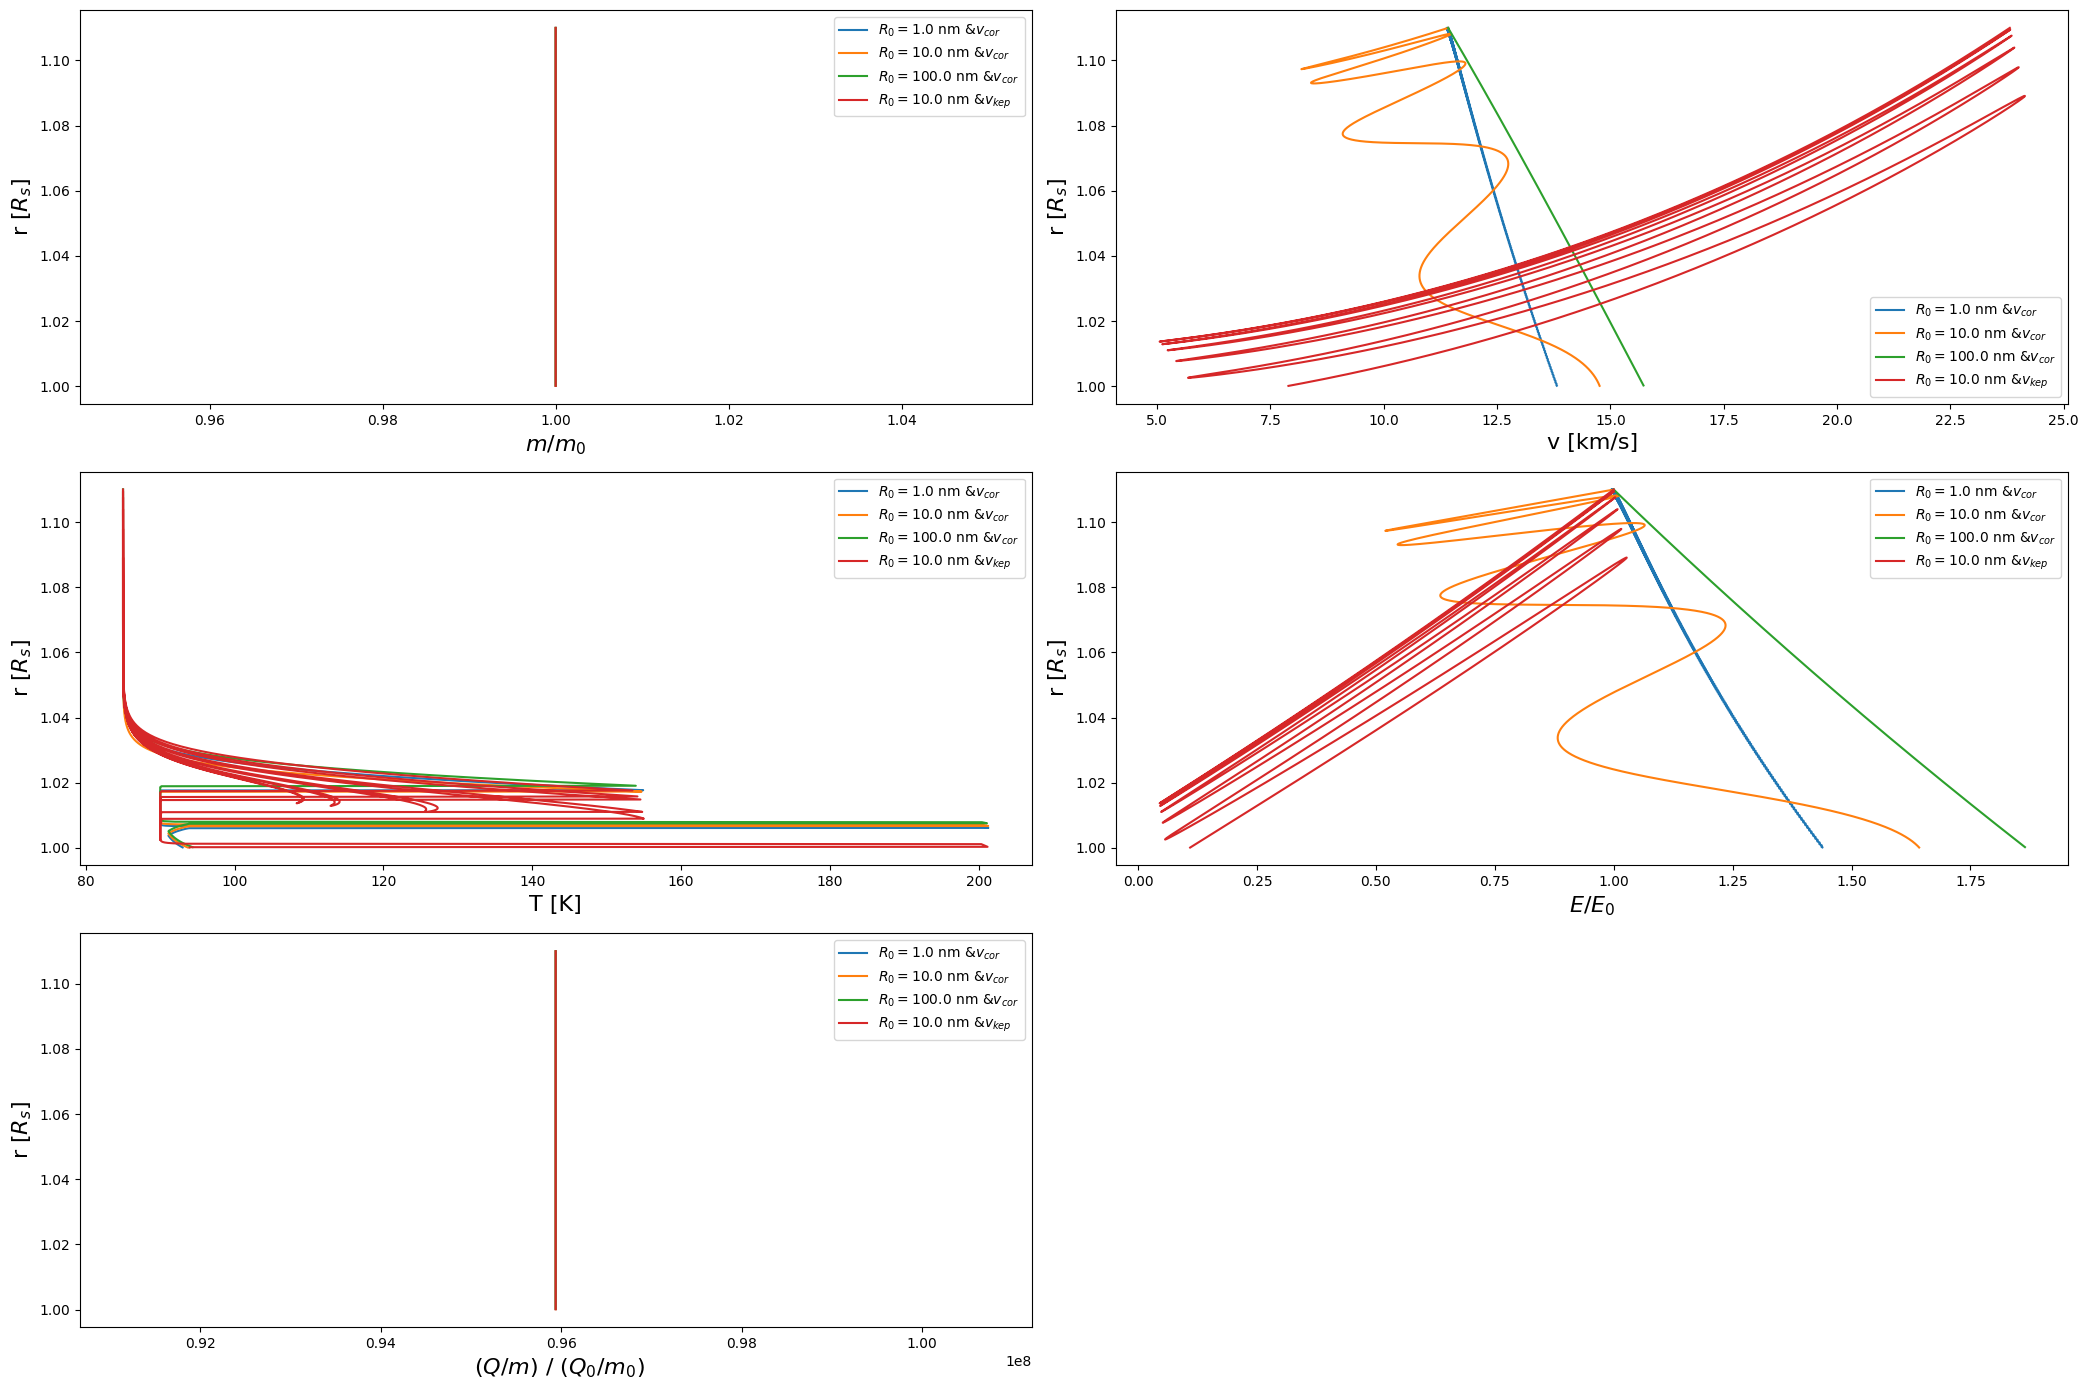

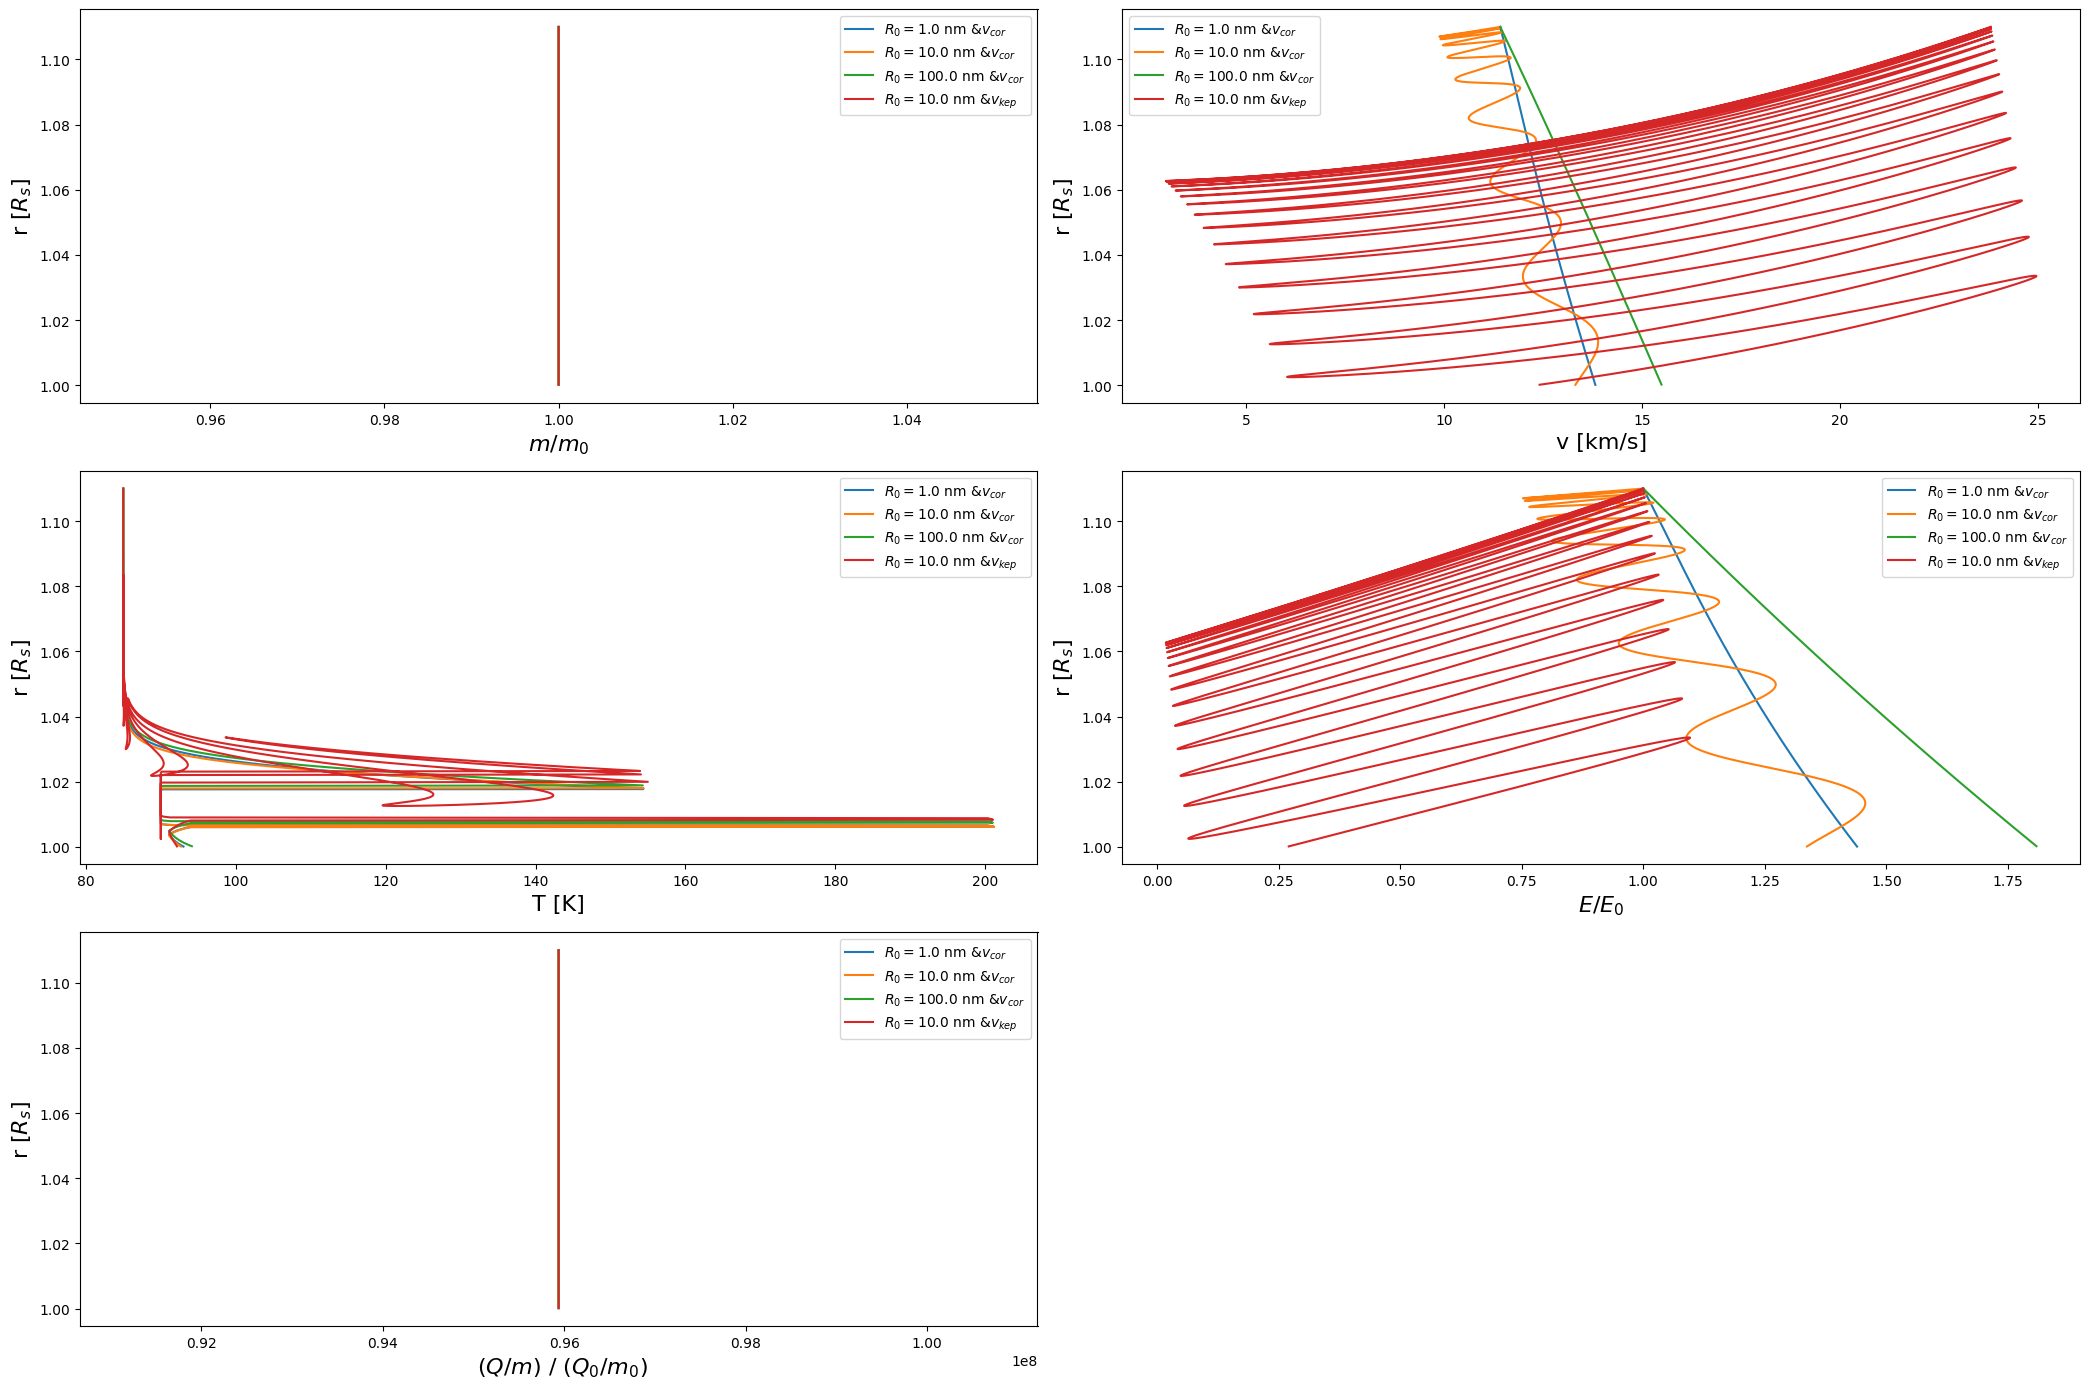

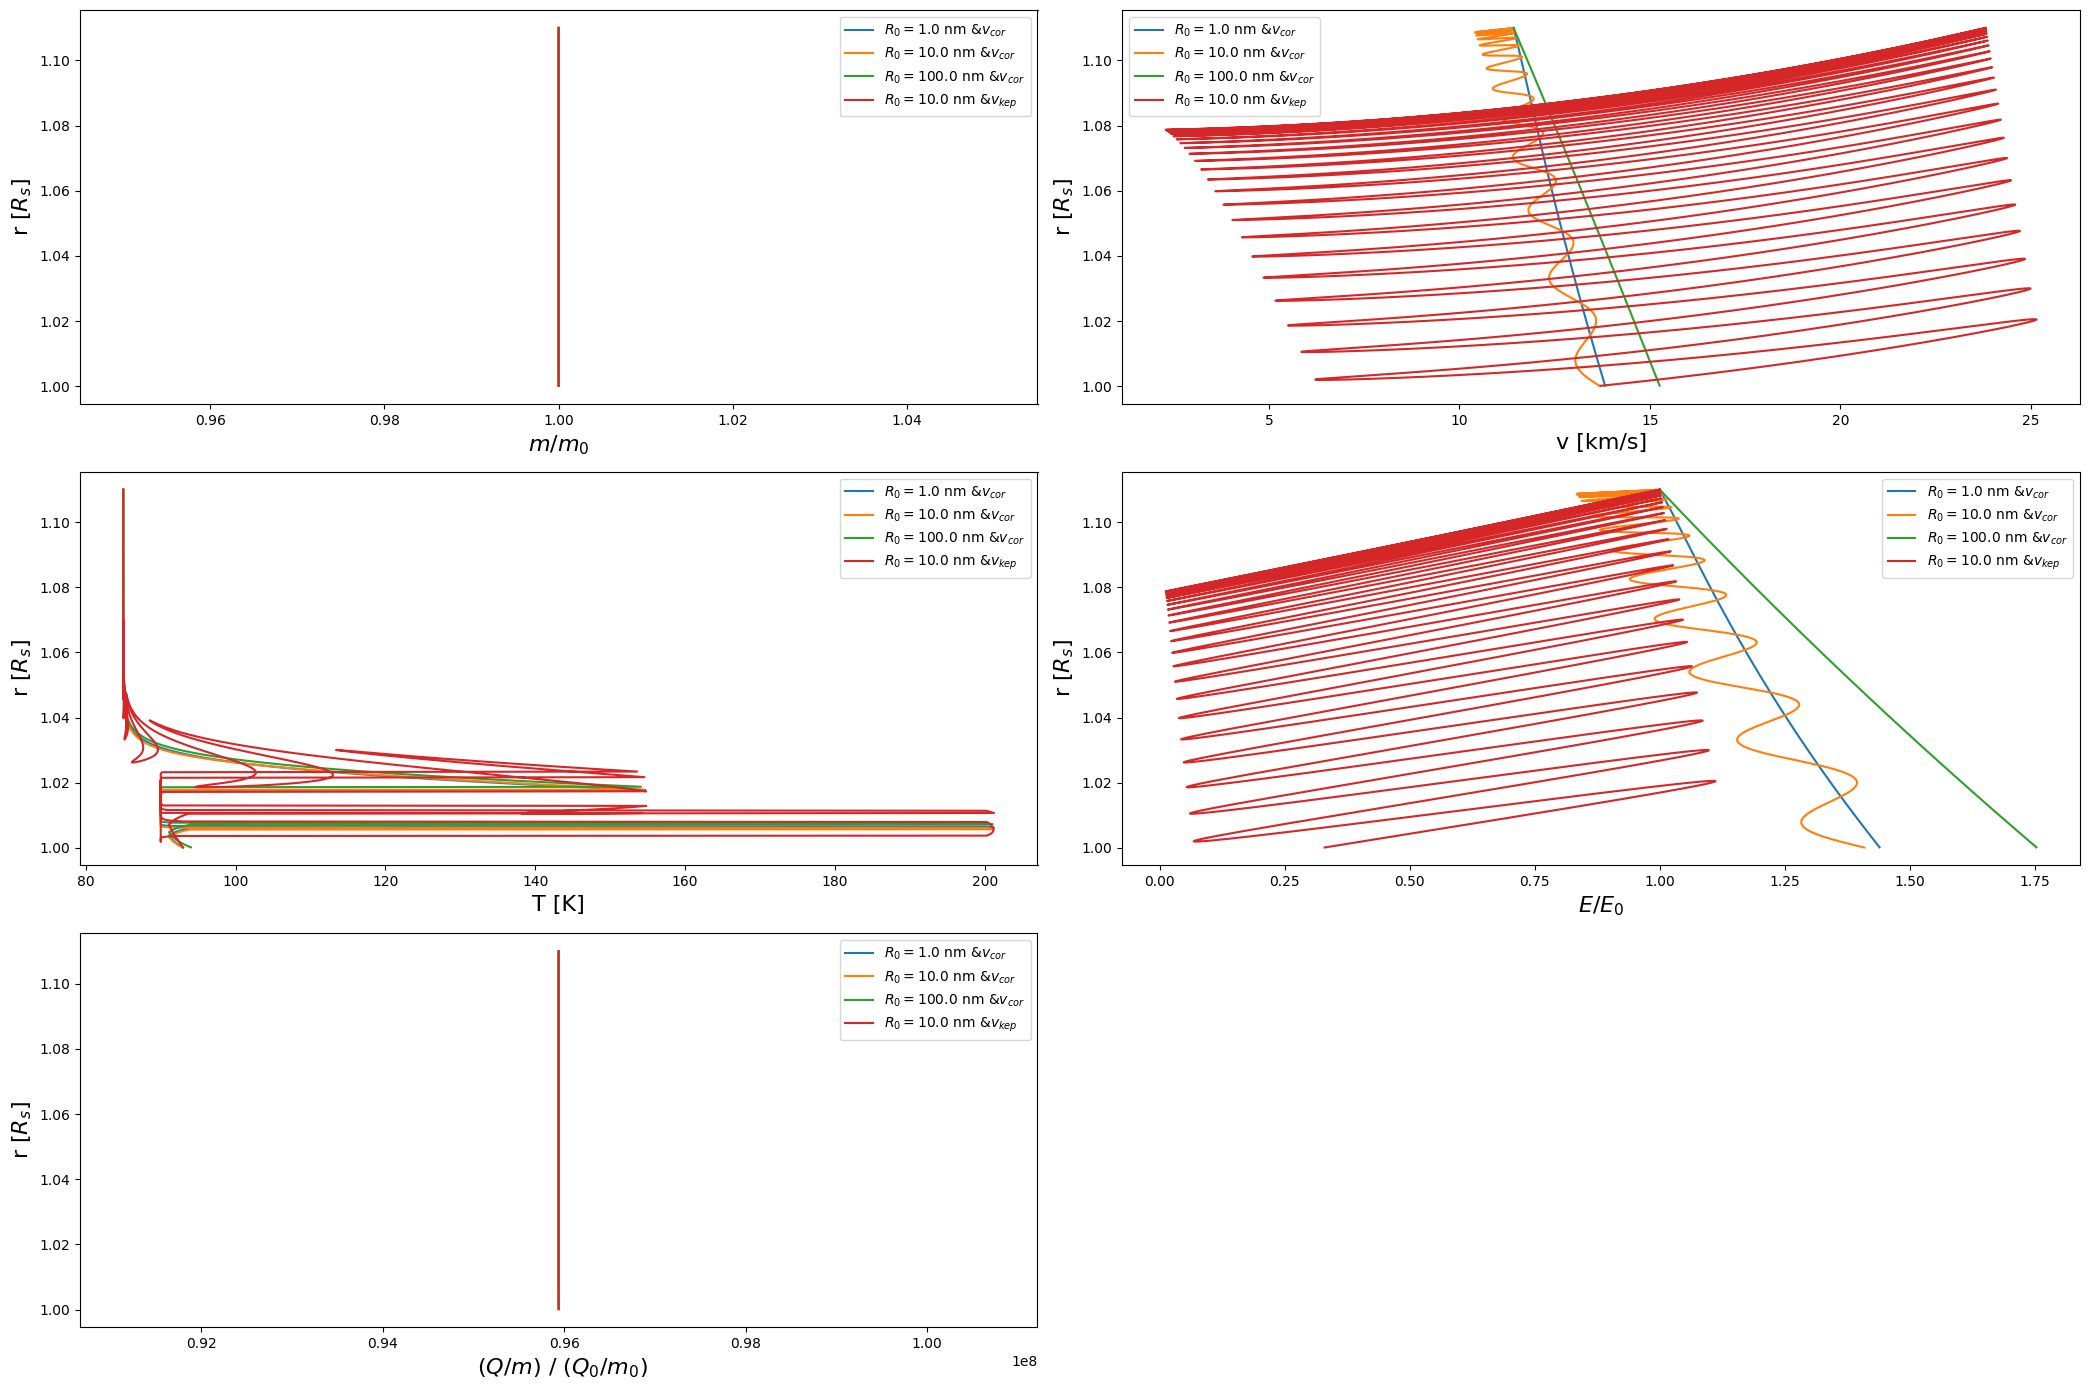

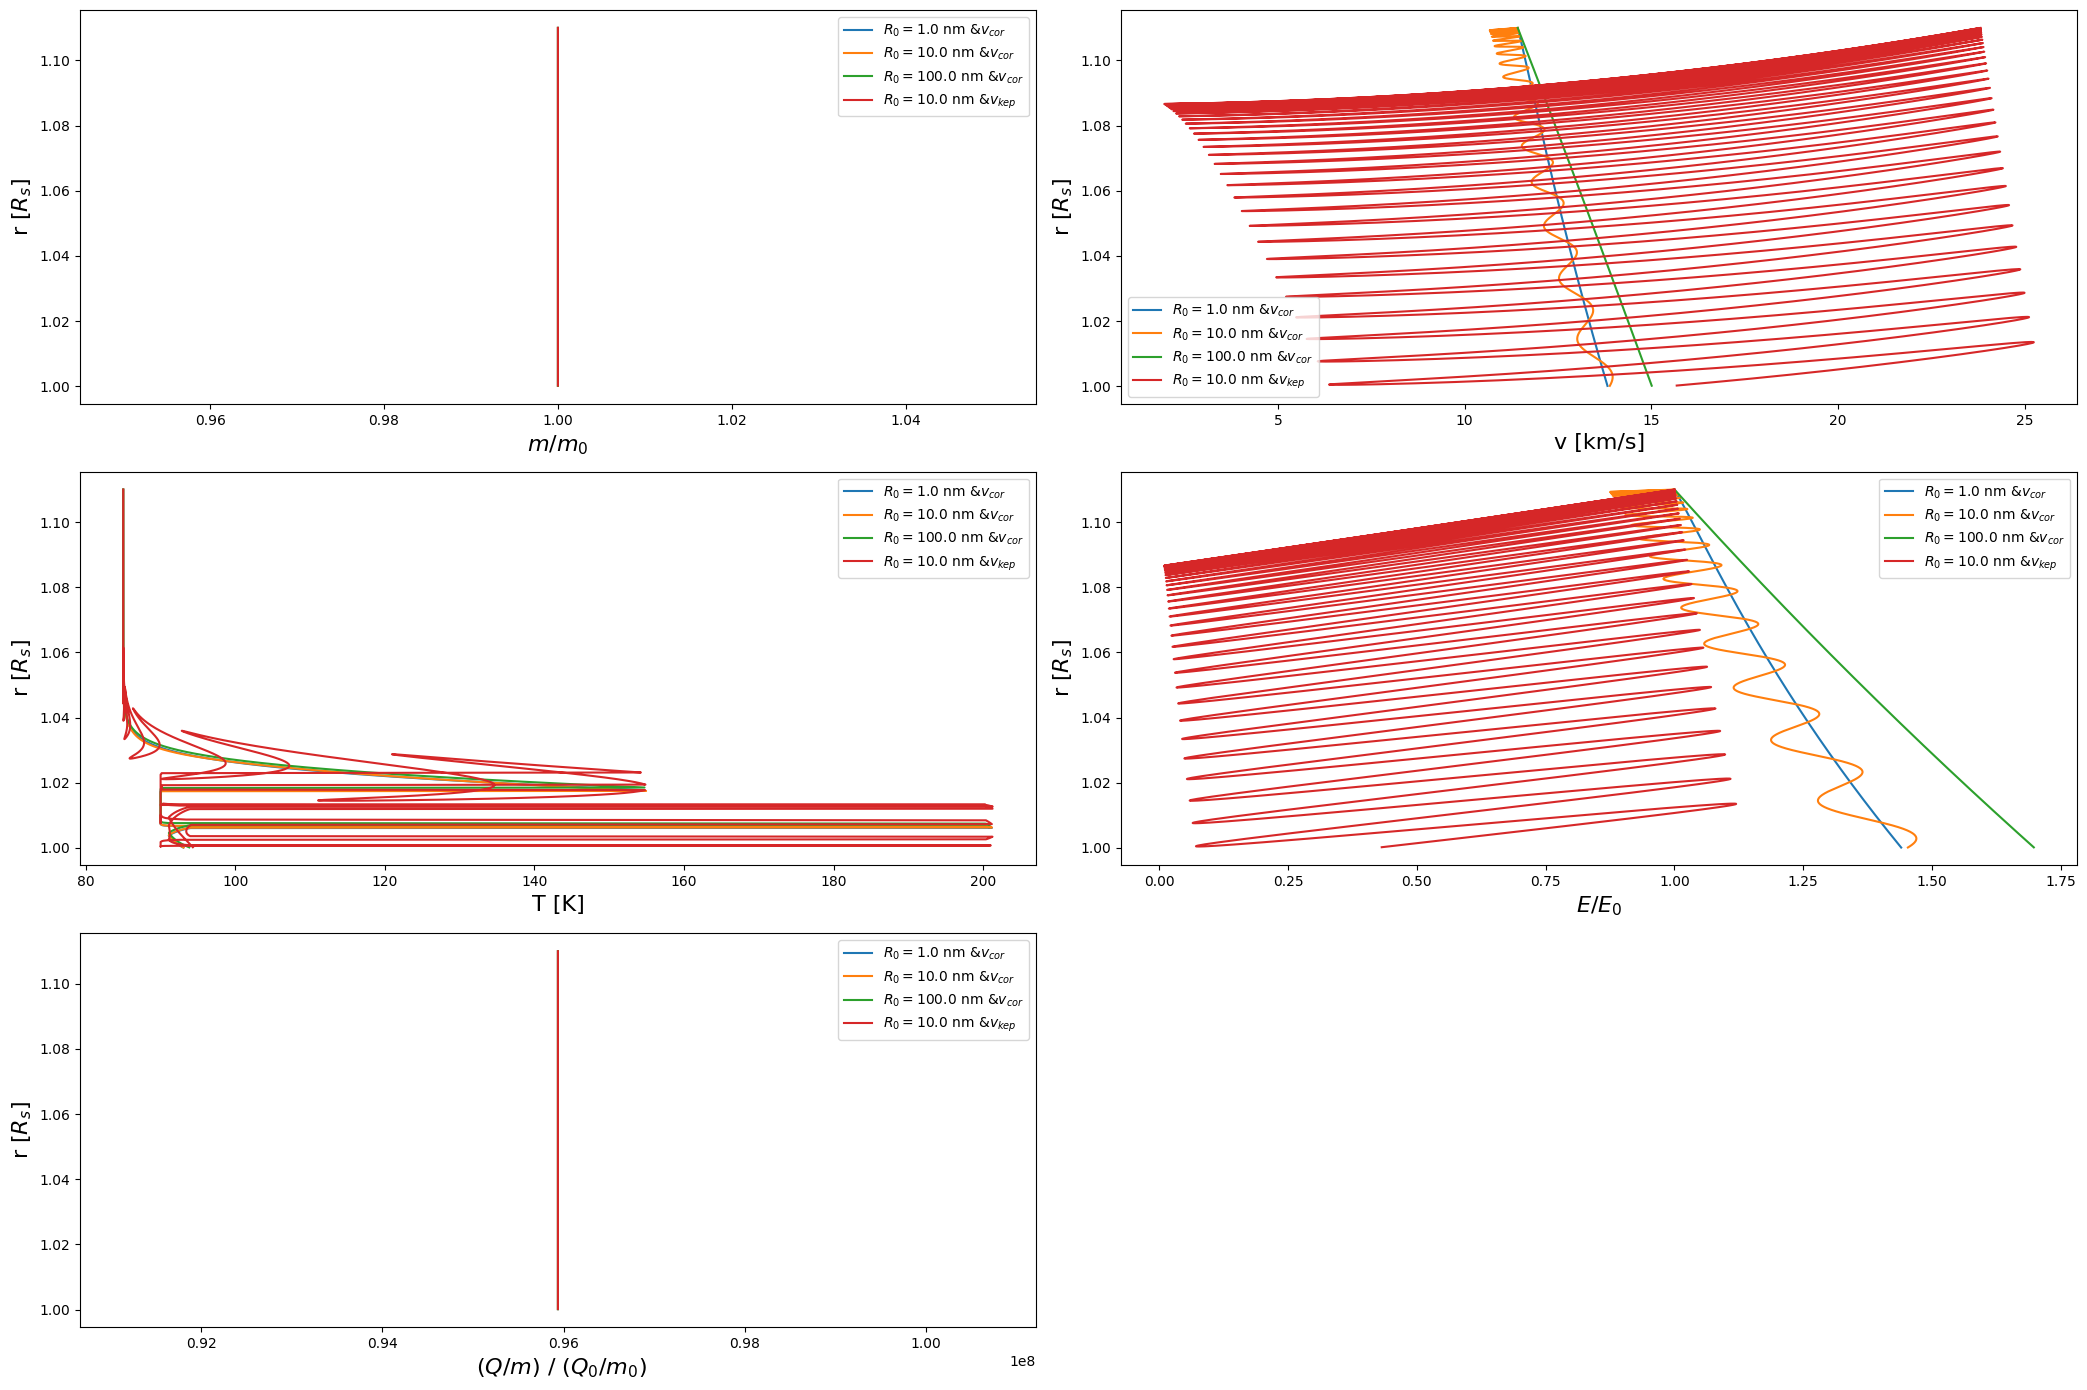

In [109]:
## using the variable axs for multiple Axes
#U_plot=U0#np.array([U0[0]])
#R_g0_plot=R_grain0#np.array([R_grain0[0], R_grain0[-1]])

for U in U_plot:
    if np.sign(U)<0:
        V_txt='U = m_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    elif np.sign(U)>0:
        V_txt='U = p_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    else:
        V_txt='drag_only_'
        
    if V_txt=='drag_only_':
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,14))
        axs[2,0].remove()
        axs[2,1].remove()
    else:
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(21,14))
        axs[2,1].remove()
    
    for Rg0 in R_g0_plot:
        if particle[U][Rg0]['v0_txt']=='$v_{kep}$':
            line='-'
        else:
            line='-'
        le=len(particle[U][Rg0]['r'])
        tt=np.arange(0, particle[U][Rg0]['t_final'], particle[U][Rg0]['dt'])/(60*60)
        gr_mag=particle[U][Rg0]['gr_mag']; drag_mag=particle[U][Rg0]['drag_mag']; mag_mag=particle[U][Rg0]['mag_mag']; Ec_mag=particle[U][Rg0]['Ec_mag']
        r=np.array(particle[U][Rg0]['r'])/Rs; vtot=np.array(particle[U][Rg0]['vtot']); m=np.array(particle[U][Rg0]['m']); Q=particle[U][Rg0]['Q']; T=particle[U][Rg0]['T']
        m0=particle[U][Rg0]['m0']
        Ep_0=1/2*m0*vtot[0]**2 + m0*G*Ms/Rs**2 * (r[0]-r[-1])
        Ep=1/2*m*vtot**2+m*G*Ms/Rs**2 * (r-r[-1])
        
        axs[0,0].plot(m/m0, r, linestyle=line, label='$R_0 = $'+str("{:.1f}".format(Rg0*1e9))+' nm &'+particle[U][Rg0]['v0_txt'])
        axs[0,0].set_ylabel('r [$R_s$]', fontsize=16)
        axs[0,0].set_xlabel('$m/m_0$', fontsize=16)
        axs[0,0].grid()
        axs[0,0].legend()
        
        axs[0,1].plot(vtot, r, linestyle=line, label='$R_0 = $'+str("{:.1f}".format(Rg0*1e9))+' nm &'+particle[U][Rg0]['v0_txt'])
        axs[0,1].set_xlabel('v [km/s]', fontsize=16)
        axs[0,1].set_ylabel('r [$R_s$]', fontsize=16)
        axs[0,1].grid()
        axs[0,1].legend()
        
        axs[1,0].plot(T, r, linestyle=line, label='$R_0 = $'+str("{:.1f}".format(Rg0*1e9))+' nm &'+particle[U][Rg0]['v0_txt'])
        axs[1,0].set_ylabel('r [$R_s$]', fontsize=16)
        axs[1,0].set_xlabel('T [K]', fontsize=16)
        axs[1,0].grid()
        axs[1,0].legend()
        
        axs[1,1].plot(Ep/Ep_0, r, linestyle=line, label='$R_0 = $'+str("{:.1f}".format(Rg0*1e9))+' nm &'+particle[U][Rg0]['v0_txt'])
        axs[1,1].set_ylabel('r [$R_s$]', fontsize=16)
        axs[1,1].set_xlabel('$E/E_0$', fontsize=16)
        axs[1,1].grid()
        axs[1,1].legend()
        
        if V_txt!='drag_only_':
            axs[2,0].plot((np.array(Q)/np.array(m))/(particle[U][Rg0]['Q_0/m_0']), r, linestyle=line, label='$R_0 = $'+str("{:.1f}".format(Rg0*1e9))+' nm &'+particle[U][Rg0]['v0_txt'])
            axs[2,0].set_xlabel(' ($Q/m$) / ($Q_0/m_0$)', fontsize=16)
            axs[2,0].set_ylabel('r [$R_s$]', fontsize=16)
            axs[2,0].grid()
            axs[2,0].legend()
    fig.tight_layout()
    fig.savefig('results_r_'+V_txt, dpi='figure', bbox_inches='tight')


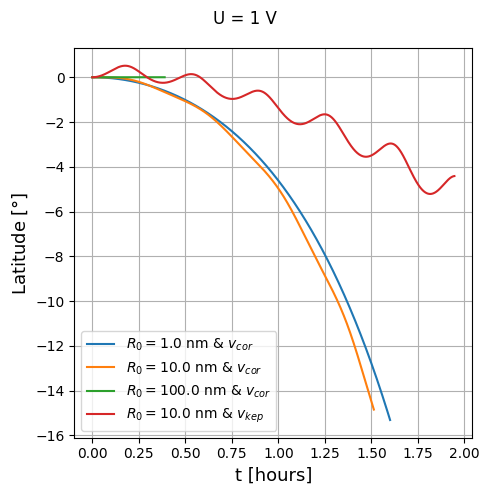

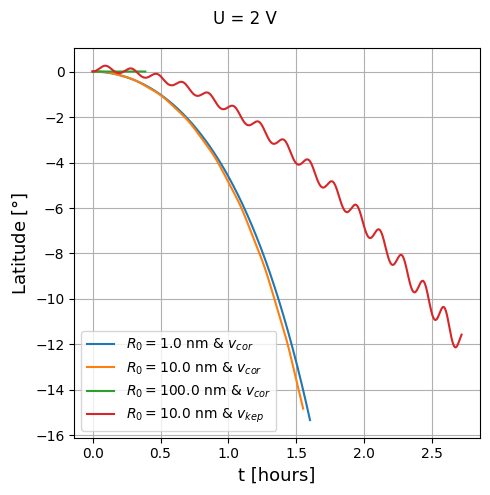

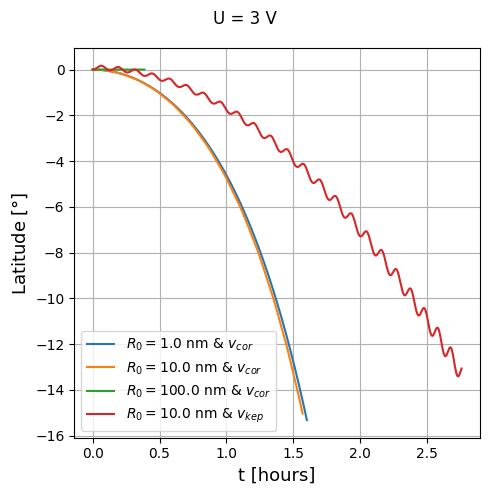

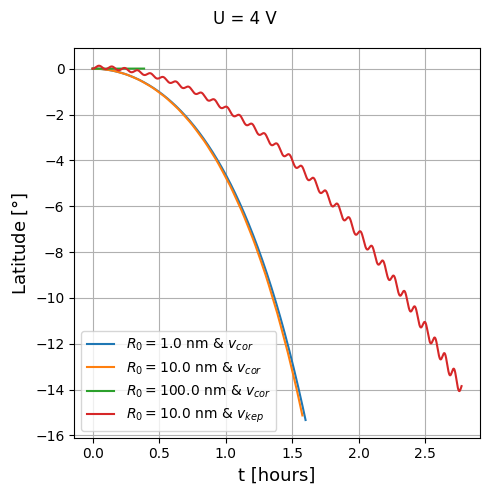

In [110]:
for U in U_plot:
    
    if np.sign(U)<0:
        V_txt='U = m_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    elif np.sign(U)>0:
        V_txt='U = p_'+str(int(abs(U)))+' V, '
        if Gamma==0:
            V_txt='mag_only_'+V_txt
    else:
        V_txt='drag_only_'
        
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
    for Rg0 in R_g0_plot:
        if particle[U][Rg0]['v0_txt']=='$v_{kep}$':
            line='-'
        else:
            line='-'
        le=int(len(particle[U][Rg0]['r']))
        tt=np.linspace(0, particle[U][Rg0]['t_final'], le)/(60*60)
        r=np.array(particle[U][Rg0]['r']); 
        x=np.array(particle[U][Rg0]['x']); y=np.array(particle[U][Rg0]['y']); z=np.array(particle[U][Rg0]['z'])
        
        lat=90-np.rad2deg(np.arctan2(np.sqrt(x**2+y**2),z))
        long=np.rad2deg(np.arctan2(y,x))
        
        axs.plot(tt, lat, linestyle=line, label='$R_0 = $'+str("{:.1f}".format(Rg0*1e9))+' nm & '+particle[U][Rg0]['v0_txt'])
        axs.set_xlabel('t [hours]', fontsize=13)
        axs.set_ylabel('Latitude [$\degree$]', fontsize=13)
        axs.grid(visible=True)
        axs.legend()
        
        #axs[1].plot(tt, long, linestyle=line, label='$R_0 = $'+str("{:.1f}".format(Rg0*1e9))+' nm & '+particle[U][Rg0]['v0_txt'])
        #axs[1].set_xlabel('t [hours]', fontsize=13)
        #axs[1].set_ylabel('Longtitude [$\degree$]', fontsize=13)
        #axs[1].grid(); axs[1].legend()
    
    fig.suptitle('U = '+str(U)+ ' V')
    fig.tight_layout()
    fig.savefig('long_lat_'+V_txt, dpi='figure', bbox_inches='tight')

In [128]:
1e-3*(1.11*Rs-Rs)

6629.480000000008